to-do: calculate average of k-fold X-validation when ranking models

In [1]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import History

Using TensorFlow backend.


# Importando dados

In [2]:
circular_database = pd.read_csv('./data/processed/circular_database.csv', index_col='Unnamed: 0')
circular_database['avg_temperature'] = circular_database[['max_temperature','min_temperature']].mean(axis=1)
circular_database['delta_temperature'] = circular_database['max_temperature'] - circular_database['min_temperature']
circular_database.drop(columns=['max_temperature','min_temperature'], inplace=True)
circular_database.sample(5)

week  weekday_0  weekday_1  weekday_2  weekday_3  weekday_4  \
2016-08-15    33          1          0          0          0          0   
2014-01-15     3          0          0          1          0          0   
2018-01-17     3          0          0          1          0          0   
2017-02-21     8          0          1          0          0          0   
2013-08-22    34          0          0          0          1          0   

            weekday_5  weekday_6  month_1  month_2  ...  month_8  month_9  \
2016-08-15          0          0        0        0  ...        1        0   
2014-01-15          0          0        1        0  ...        0        0   
2018-01-17          0          0        1        0  ...        0        0   
2017-02-21          0          0        0        1  ...        0        0   
2013-08-22          0          0        0        0  ...        1        0   

            month_10  month_11  month_12  precipitation    8012    8022  \
2016-08-15         0         0         0            0.0  4617.0  4037.0   
2014-01-15         0         0         0           21.3  2943.0  2522.0   
2018-01-17         0         0         0            5.8  2336.0  2248.0   
2017-02-21         0         0         0            0.0  4002.0  3352.0   
2013-08-22         0         0         0            0.0  4453.0  3806.0   

            avg_temperature  delta_temperature  
2016-08-15            21.60               16.0  
2014-01-15            24.95               13.5  
2018-01-17            25.80               10.0  
2017-02-21            25.40               13.0  
2013-08-22            20.80               11.0  

[5 rows x 25 columns]

# Visualização básica dos dados

Media diaria 5157.66
Media diaria dias de seamana 6591.32
Media diaria fins de seamana 1556.72


Text(0.5, 1.0, 'Total diário de passageiros no ano de 2018')

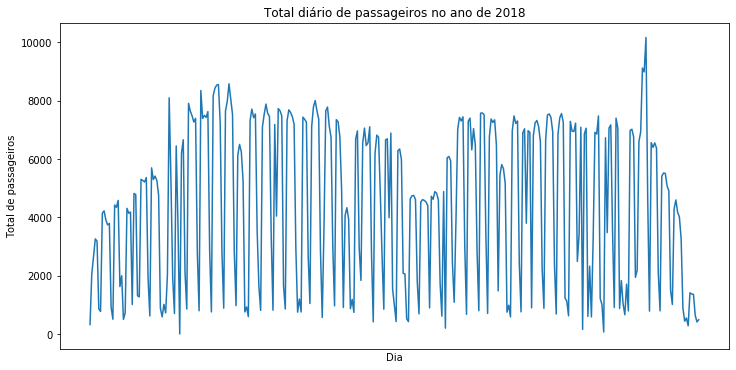

In [3]:
# media de passageiros transportados
print('Media diaria %.2f' % circular_database[['8012','8022']].sum(axis=1).mean())
print('Media diaria dias de seamana %.2f' % circular_database.loc[(circular_database['weekday_5']==0)&(circular_database['weekday_6']==0)][['8012','8022']].sum(axis=1).mean())
print('Media diaria fins de seamana %.2f' % circular_database.loc[(circular_database['weekday_5']==1)|(circular_database['weekday_6']==1)][['8012','8022']].sum(axis=1).mean())

df = circular_database.loc['2018-01-01':'2018-12-31']
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(df.index, df[['8012','8022']].sum(axis=1))
plt.xticks(())
plt.xlabel('Dia')
plt.ylabel('Total de passageiros')
plt.title('Total diário de passageiros no ano de 2018')

# Regressor linear

Coefficients: 
                              0
week                 40.967495
weekday_0          1353.552882
weekday_1          1624.972326
weekday_2          1625.168800
weekday_3          1560.811497
weekday_4          1029.764698
weekday_5         -2945.126398
weekday_6         -4249.143805
month_1            -858.045753
month_2             674.208745
month_3            1337.170301
month_4             896.477394
month_5             951.465538
month_6             189.904724
month_7           -1188.486691
month_8             642.684822
month_9             100.574766
month_10            -22.661946
month_11           -476.362005
month_12          -2246.929894
precipitation        -4.503587
avg_temperature     -17.990902
delta_temperature    11.234042 

Mean squared error:	3766800.73
train RMS:	1710.21
test RMS:	1940.82
test R2:	0.60


Text(0, 0.5, 'RS')

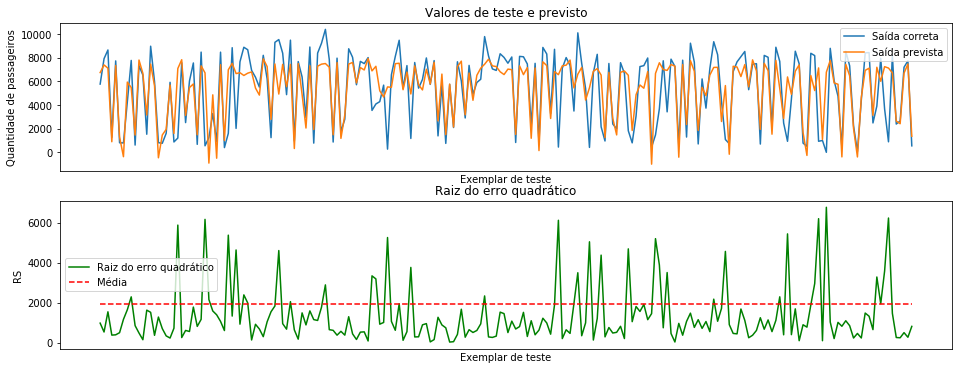

In [4]:
X = circular_database.drop(columns=['8012','8022'])
y = circular_database[['8012','8022']].sum(axis=1)
#create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Create linear regression object
regr = linear_model.LinearRegression(fit_intercept=True)
# Train the model using the training sets
regr.fit(X_train, y_train)
# Make predictions using the testing set
y_pred = regr.predict(X_test)
y_pred_train = regr.predict(X_train)

##Results
# The coefficients
print('Coefficients: \n', pd.DataFrame(regr.coef_, index=X.columns), '\n')
# The mean squared error
print("Mean squared error:\t%.2f" % mean_squared_error(y_test, y_pred))
# RMS
print("train RMS:\t%.2f" % np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("test RMS:\t%.2f" % np.sqrt(mean_squared_error(y_test, y_pred)))
# Explained variance score (1 is perfect prediction)
print('test R2:\t%.2f' % r2_score(y_test, y_pred))
# Plot outputs
df = pd.DataFrame(index=y_test.index, columns=['y_test', 'y_pred'])
df['y_test'] = y_test
df['y_pred'] = y_pred
df.sort_index()

plt.figure(figsize=(16,6))

ax0 = plt.subplot(211)
plt.title('Valores de teste e previsto')
plt.plot(df.index, df['y_test'], df.index, df['y_pred'])
plt.xticks(())
plt.xlabel('Exemplar de teste')
plt.ylabel('Quantidade de passageiros')
plt.legend(['Saída correta', 'Saída prevista'])

plt.subplot(212, sharex=ax0)
plt.title('Raiz do erro quadrático')
plt.plot(df.index,
         np.sqrt(np.square(df['y_test']-df['y_pred'])), '-g',
         df.index,
         np.ones(len(df)) * np.sqrt(mean_squared_error(y_test, y_pred)), '--r')
plt.legend(['Raiz do erro quadrático', 'Média'])
plt.xticks(())
plt.xlabel('Exemplar de teste')
plt.ylabel('RS')

# Definindo primeira rede neural

In [5]:
X = circular_database.drop(columns=['8012','8022'])
y = circular_database[['8012','8022']].sum(axis=1)
#create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

model = Sequential()
hist = History()

# topologia 23-23-10-5-1
model.add(Dense(23, activation='tanh', input_dim = X_train.shape[1], use_bias=True))
model.add(Dense(10, activation='tanh'))
model.add(Dense(5, activation='tanh'))
model.add(Dense(1, activation='linear'))

adam = optimizers.Adam(lr=0.001)
model.compile(optimizer=adam,
              loss='mse', 
              metrics=['mse', 'mape'])
model.summary()

model.fit(X_train, y_train, epochs = 10000, validation_split = .1, callbacks = [hist])

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print('\ntrain RMS:\t%.2f' % np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('test RMS:\t%.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))
print('test R2:\t%.2f\n' % r2_score(y_test, y_pred))

plt.figure(figsize=(10,8))
ax0 = plt.subplot(111)
ax0.plot(np.sqrt(hist.history['mean_squared_error']))
ax0.plot(np.sqrt(hist.history['val_mean_squared_error']))
plt.xlabel('Epochs')
plt.ylabel('RMS')
plt.legend(['RMS', 'RMS validation'])
"""ax1 = ax0.twinx()
ax1.plot(hist.history['mean_absolute_percentage_error'], '--C2')
ax1.plot(hist.history['val_mean_absolute_percentage_error'], '--C3')
plt.ylabel('MAPE')
plt.legend(['MAPE', 'MAPE validation'])"""

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 23)                552       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                240       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 853
Trainable params: 853
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 1701 samples, validate on 189 samples
Epoch 1/10000
1701/1701 [==============================] - 0s 197us/step - loss: 35216632.3410 - mean_squared

Epoch 25/10000
1701/1701 [==============================] - 0s 49us/step - loss: 35123515.7366 - mean_squared_error: 35123515.7366 - mean_absolute_percentage_error: 99.4630 - val_loss: 39359475.0053 - val_mean_squared_error: 39359475.0053 - val_mean_absolute_percentage_error: 99.6153
Epoch 26/10000
1701/1701 [==============================] - 0s 39us/step - loss: 35120203.4650 - mean_squared_error: 35120203.4650 - mean_absolute_percentage_error: 99.4521 - val_loss: 39355876.4021 - val_mean_squared_error: 39355876.4021 - val_mean_absolute_percentage_error: 99.6041
Epoch 27/10000
1701/1701 [==============================] - 0s 41us/step - loss: 35116898.4198 - mean_squared_error: 35116898.4198 - mean_absolute_percentage_error: 99.4351 - val_loss: 39352249.1217 - val_mean_squared_error: 39352249.1217 - val_mean_absolute_percentage_error: 99.5929
Epoch 28/10000
1701/1701 [==============================] - 0s 39us/step - loss: 35113591.1464 - mean_squared_error: 35113591.1464 - mean_absolut

Epoch 54/10000
1701/1701 [==============================] - 0s 59us/step - loss: 35028054.7748 - mean_squared_error: 35028054.7748 - mean_absolute_percentage_error: 99.1425 - val_loss: 39254869.9683 - val_mean_squared_error: 39254869.9683 - val_mean_absolute_percentage_error: 99.2905
Epoch 55/10000
1701/1701 [==============================] - 0s 59us/step - loss: 35024772.9641 - mean_squared_error: 35024772.9641 - mean_absolute_percentage_error: 99.1336 - val_loss: 39251256.7196 - val_mean_squared_error: 39251256.7196 - val_mean_absolute_percentage_error: 99.2793
Epoch 56/10000
1701/1701 [==============================] - 0s 36us/step - loss: 35021496.7407 - mean_squared_error: 35021496.7407 - mean_absolute_percentage_error: 99.1251 - val_loss: 39247661.5026 - val_mean_squared_error: 39247661.5026 - val_mean_absolute_percentage_error: 99.2681
Epoch 57/10000
1701/1701 [==============================] - 0s 37us/step - loss: 35018210.0176 - mean_squared_error: 35018210.0176 - mean_absolut

Epoch 83/10000
1701/1701 [==============================] - 0s 52us/step - loss: 34933276.8959 - mean_squared_error: 34933276.8959 - mean_absolute_percentage_error: 98.8608 - val_loss: 39150936.3386 - val_mean_squared_error: 39150936.3386 - val_mean_absolute_percentage_error: 98.9673
Epoch 84/10000
1701/1701 [==============================] - 0s 38us/step - loss: 34930022.2175 - mean_squared_error: 34930022.2175 - mean_absolute_percentage_error: 98.8476 - val_loss: 39147368.7831 - val_mean_squared_error: 39147368.7831 - val_mean_absolute_percentage_error: 98.9562
Epoch 85/10000
1701/1701 [==============================] - 0s 43us/step - loss: 34926746.9536 - mean_squared_error: 34926746.9536 - mean_absolute_percentage_error: 98.8377 - val_loss: 39143775.5344 - val_mean_squared_error: 39143775.5344 - val_mean_absolute_percentage_error: 98.9450
Epoch 86/10000
1701/1701 [==============================] - 0s 41us/step - loss: 34923481.4685 - mean_squared_error: 34923481.4685 - mean_absolut

Epoch 112/10000
1701/1701 [==============================] - 0s 47us/step - loss: 34838725.1240 - mean_squared_error: 34838725.1240 - mean_absolute_percentage_error: 98.5747 - val_loss: 39047240.7407 - val_mean_squared_error: 39047240.7407 - val_mean_absolute_percentage_error: 98.6443
Epoch 113/10000
1701/1701 [==============================] - 0s 51us/step - loss: 34835470.5209 - mean_squared_error: 34835470.5209 - mean_absolute_percentage_error: 98.5646 - val_loss: 39043638.8148 - val_mean_squared_error: 39043638.8148 - val_mean_absolute_percentage_error: 98.6330
Epoch 114/10000
1701/1701 [==============================] - 0s 39us/step - loss: 34832204.7937 - mean_squared_error: 34832204.7937 - mean_absolute_percentage_error: 98.5562 - val_loss: 39040084.8889 - val_mean_squared_error: 39040084.8889 - val_mean_absolute_percentage_error: 98.6220
Epoch 115/10000
1701/1701 [==============================] - 0s 40us/step - loss: 34828958.8807 - mean_squared_error: 34828958.8807 - mean_abs

KeyboardInterrupt: 

# Testando outras topologias de rede neural

In [6]:
X = circular_database.drop(columns=['8012','8022'])
y = circular_database[['8012','8022']].sum(axis=1)
#create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

if not os.path.exists('./model_scores'):
    os.makedirs('./model_scores')
if not os.path.exists('./model_scores/images'):
    os.makedirs('./model_scores/images')

for i in range(12, 17):
    for j in range(3, 11):
            
        start = time.time()
        model = Sequential()
        hist = History()
        model.add(Dense(i, activation='relu', input_dim = X_train.shape[1]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(j, activation='relu'))
        model.add(Dense(1, activation='linear'))
        
        filename = str(i) + '-' + str(10) + '-' + str(j)
        
        with open('./model_scores/{filename}'.format(filename=filename) + '.txt','w') as fh:
            model.summary(print_fn = lambda x: fh.write(x + '\n'))
        
        model.compile(optimizer=optimizers.Adam(lr=0.001),loss='mse', metrics=['mse', 'mape'])
        
        print('Training ' + filename)
        model.fit(X_train, y_train, epochs = 300, validation_split = .1, verbose = 0, callbacks = [hist])
        y_pred = model.predict(X_test)
        train_RMS = np.sqrt(hist.history['mean_squared_error'][-1])
        val_RMS = np.sqrt(hist.history['val_mean_squared_error'][-1])
        test_RMS = np.sqrt(mean_squared_error(y_test, y_pred))
        test_r2 = r2_score(y_test, y_pred)
        
        with open('./model_scores/{filename}'.format(filename=filename) + '.txt','a') as fh:
            fh.write('train_rms=' + str(train_RMS) + '\n')
            fh.write('val_rms=' + str(val_RMS) + '\n')
            fh.write('test_rms=' + str(test_RMS) + '\n')
            fh.write('test_r2=' + str(test_r2) + '\n')
          
        with open('./model_scores/ranking.txt','a') as fh:
            fh.write(str(i) + ',' + str(j) + ',' + str(test_RMS) + ',' + str(test_r2) + '\n')
        
        plt.figure(figsize=(10,8))
        ax0 = plt.subplot(111)
        ax0.plot(np.sqrt(hist.history['mean_squared_error']))
        ax0.plot(np.sqrt(hist.history['val_mean_squared_error']))
        plt.xlabel('Epochs')
        plt.ylabel('RMS')
        plt.legend(['RMS', 'RMS validation'])
        ax1 = ax0.twinx()
        ax1.plot(hist.history['mean_absolute_percentage_error'], '--C2')
        plt.ylabel('MAPE')
        plt.savefig('./model_scores/images/{filename}'.format(filename=filename) + '.png')
        plt.close()
        
        end = time.time()
        print('\t Time taken (seconds): %.0f' % (end - start))


Training 15-10-3
	 Time taken (seconds): 15
Training 15-10-4
	 Time taken (seconds): 16
Training 15-10-5
	 Time taken (seconds): 18
Training 15-10-6
	 Time taken (seconds): 17
Training 15-10-7
	 Time taken (seconds): 15
Training 15-10-8
	 Time taken (seconds): 16
Training 15-10-9
	 Time taken (seconds): 16
Training 15-10-10
	 Time taken (seconds): 16
Training 16-10-3
	 Time taken (seconds): 20
Training 16-10-4
	 Time taken (seconds): 21
Training 16-10-5
	 Time taken (seconds): 19
Training 16-10-6
	 Time taken (seconds): 20
Training 16-10-7
	 Time taken (seconds): 19
Training 16-10-8
	 Time taken (seconds): 21
Training 16-10-9
	 Time taken (seconds): 20
Training 16-10-10
	 Time taken (seconds): 20


# Testando modelo por Random Forest

RMS train:	608.38
RMS test:	1392.59
Variance score:	0.80

Features sorted by their score:
[(0.32, 'weekday_6'), (0.25, 'weekday_5'), (0.18, 'week'), (0.08, 'delta_temperature'), (0.07, 'avg_temperature'), (0.03, 'precipitation'), (0.02, 'month_7'), (0.01, 'weekday_4'), (0.01, 'weekday_3'), (0.01, 'weekday_1'), (0.01, 'weekday_0'), (0.0, 'weekday_2'), (0.0, 'month_9'), (0.0, 'month_8'), (0.0, 'month_6'), (0.0, 'month_5'), (0.0, 'month_4'), (0.0, 'month_3'), (0.0, 'month_2'), (0.0, 'month_12'), (0.0, 'month_11'), (0.0, 'month_10'), (0.0, 'month_1')]


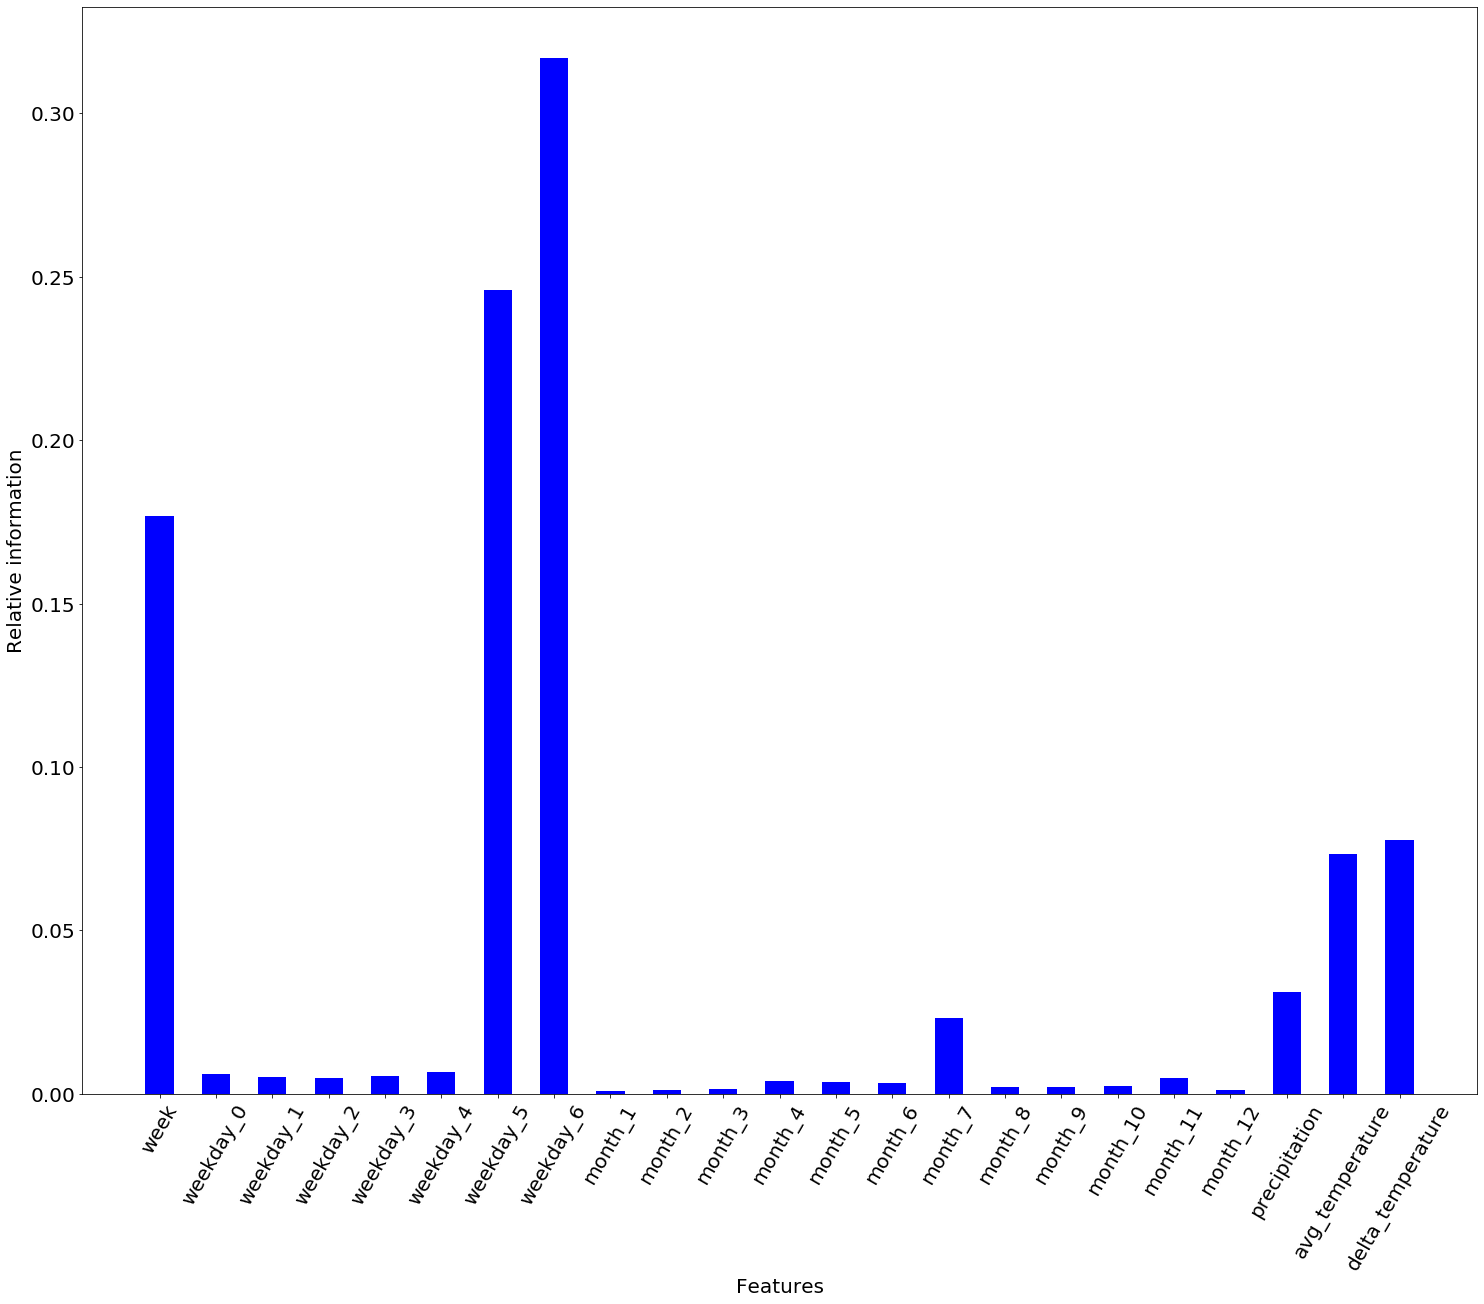

In [7]:
X = circular_database.drop(columns=['8012','8022'])
y = circular_database[['8012','8022']].sum(axis=1)
#create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

rfr = RandomForestRegressor(n_estimators=1000)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
 
print('RMS train:\t%.2f' % np.sqrt(mean_squared_error(y_train, rfr.predict(X_train))))
print('RMS test:\t%.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))
print('Variance score:\t%.2f' % r2_score(y_test, y_pred))

# Analyze feature importance
features = X.columns
plt_x = np.linspace(0,len(features)-1,len(features))
print("\nFeatures sorted by their score:")
print(sorted(zip(map(lambda x: float("{0:.2f}".format(round(x, 4))), rfr.feature_importances_), features),
             reverse=True))

fig, ax = plt.subplots(figsize=(25,20))
plt.bar(plt_x, rfr.feature_importances_, width=0.5, color='blue',align='center')
plt.gca().set_xticklabels(plt_x, rotation=60 )
plt.xticks(plt_x, features)
plt.ylabel('Relative information')
plt.xlabel('Features')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

# Análise da significância das variáveis

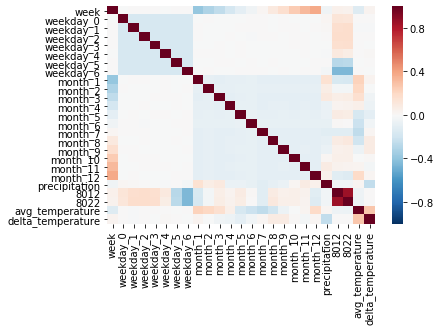

In [4]:
corr = circular_database.corr(method='kendall')
sns.heatmap(corr, vmin=-1, vmax=1, xticklabels=corr.columns, yticklabels=corr.columns, cmap="RdBu_r")

## Dados de data

### Semana

Text(0, 0.5, 'Passageiros')

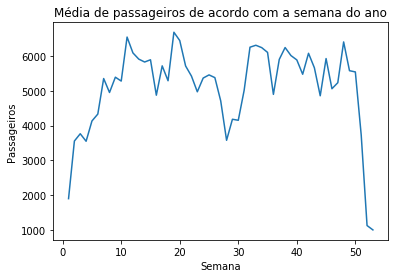

In [6]:
df = circular_database[['week', '8012', '8022']].groupby('week').mean()
df = df.sum(axis=1)
plt.plot(df)
plt.title('Média de passageiros de acordo com a semana do ano')
plt.xlabel('Semana')
plt.ylabel('Passageiros')

### Mês

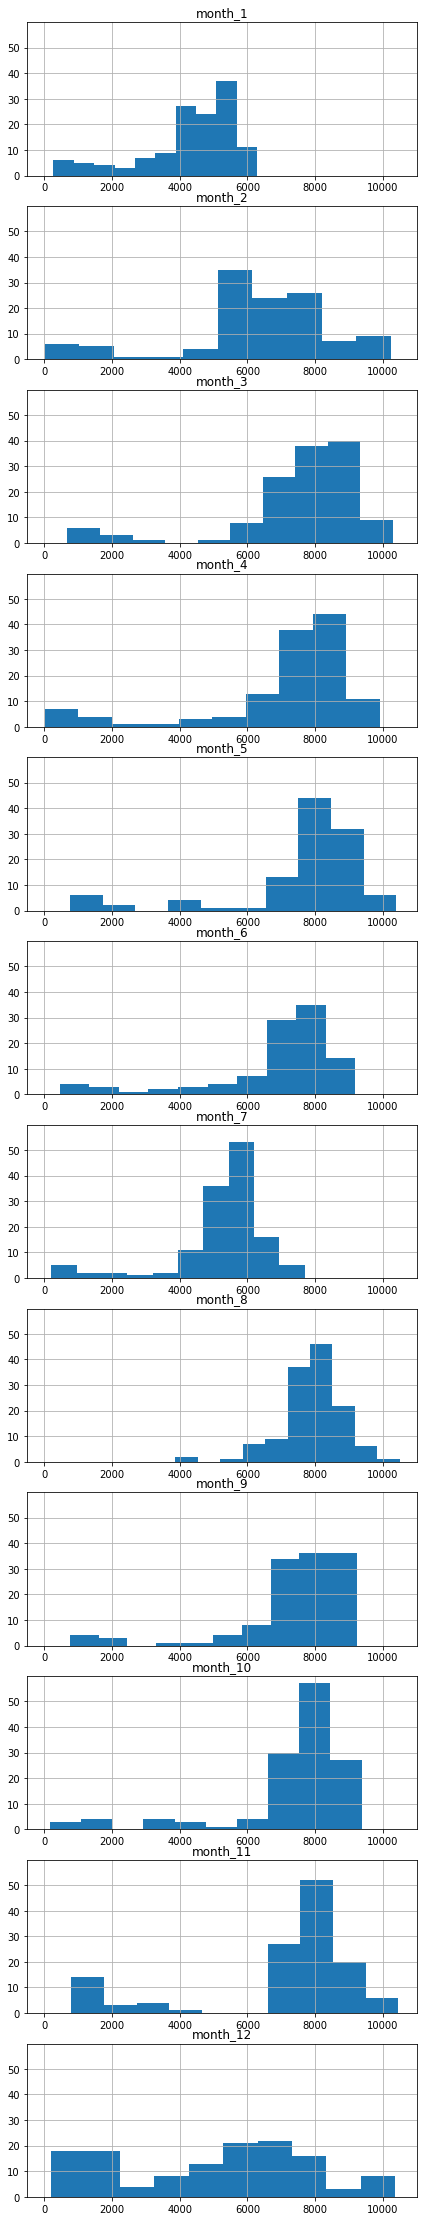

In [8]:
weekday_circular = circular_database.loc[(circular_database['weekday_5'] == 0) & (circular_database['weekday_6'] == 0)]

plt.figure(figsize=(7,40))
ax0 = plt.subplot(12, 1, 1)
weekday_circular.loc[weekday_circular['month_1'] == 1][['8012','8022']].sum(axis=1).hist()
plt.title('month_1')
for i in range(2, 13):
    plt.subplot(12, 1, i, sharex=ax0, sharey=ax0)
    weekday_circular.loc[weekday_circular['month_{i}'.format(i=i)] == 1][['8012','8022']].sum(axis=1).hist()
    plt.title('month_{i}'.format(i=i))


## Dados climáticos

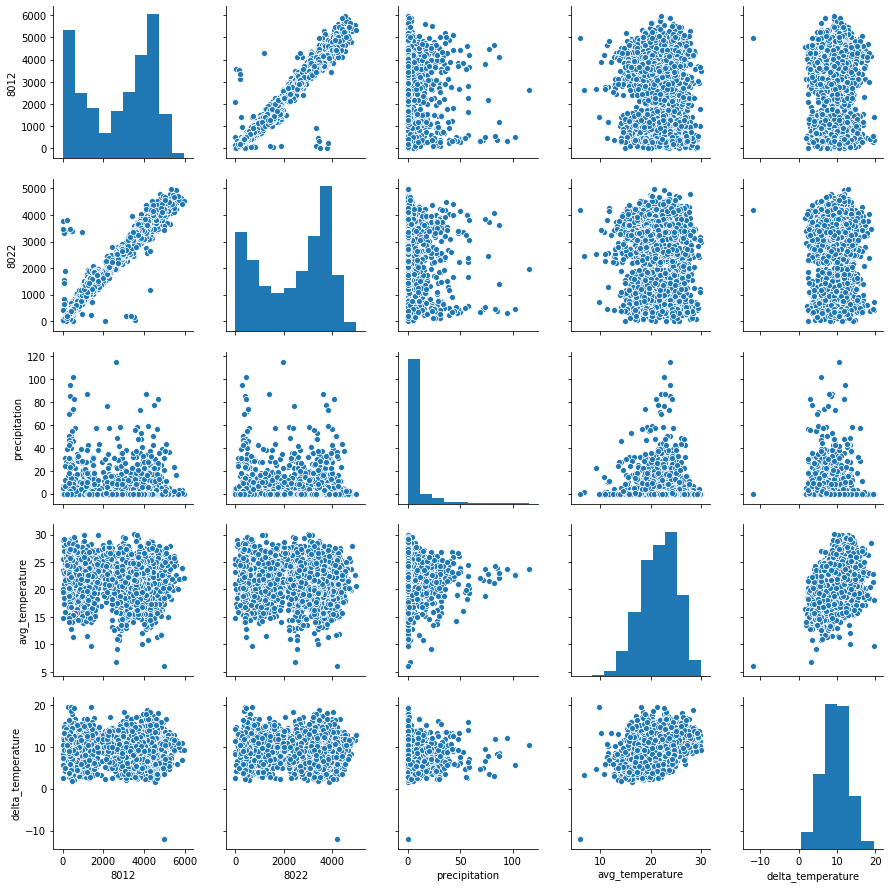

In [9]:
sns.pairplot(circular_database[['8012','8022','precipitation','avg_temperature','delta_temperature']])

# Regressão sem dados de clima

## Regressão linear

Coefficients: 
                      0
week         40.286845
weekday_0  1280.710842
weekday_1  1657.862343
weekday_2  1694.727177
weekday_3  1616.074694
weekday_4   969.905211
weekday_5 -2993.018769
weekday_6 -4226.261498
month_1    -908.546920
month_2     576.685278
month_3    1269.537589
month_4     835.302355
month_5    1079.269166
month_6     277.294089
month_7   -1172.428612
month_8     708.801779
month_9     110.093370
month_10   -135.857632
month_11   -461.206399
month_12  -2178.944062 

Mean squared error:	2988813.77
train RMS:	1736.16
test RMS:	1728.82
test R2:	0.68


Text(0, 0.5, 'RS')

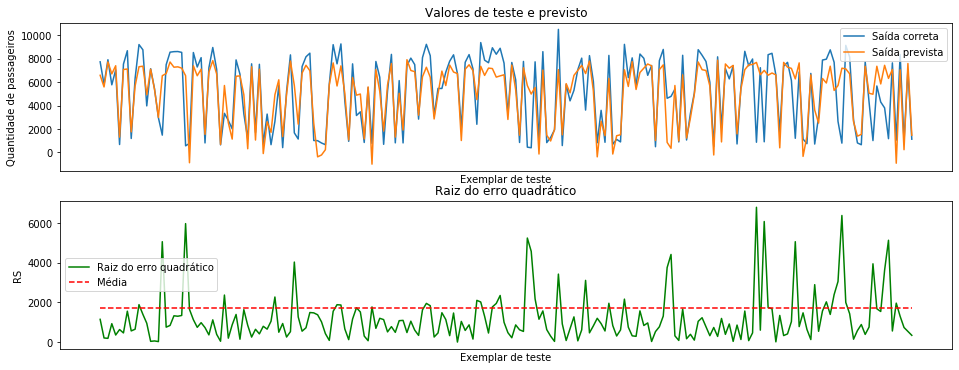

In [60]:
X = circular_database.drop(columns=['8012','8022', 'precipitation', 'avg_temperature', 'delta_temperature'])
y = circular_database[['8012','8022']].sum(axis=1)
#create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Create linear regression object
regr = linear_model.LinearRegression(fit_intercept=True)
# Train the model using the training sets
regr.fit(X_train, y_train)
# Make predictions using the testing set
y_pred = regr.predict(X_test)
y_pred_train = regr.predict(X_train)

##Results
# The coefficients
print('Coefficients: \n', pd.DataFrame(regr.coef_, index=X.columns), '\n')
# The mean squared error
print("Mean squared error:\t%.2f" % mean_squared_error(y_test, y_pred))
# RMS
print("train RMS:\t%.2f" % np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("test RMS:\t%.2f" % np.sqrt(mean_squared_error(y_test, y_pred)))
# Explained variance score (1 is perfect prediction)
print('test R2:\t%.2f' % r2_score(y_test, y_pred))
# Plot outputs
df = pd.DataFrame(index=y_test.index, columns=['y_test', 'y_pred'])
df['y_test'] = y_test
df['y_pred'] = y_pred
df.sort_index()

plt.figure(figsize=(16,6))

ax0 = plt.subplot(211)
plt.title('Valores de teste e previsto')
plt.plot(df.index, df['y_test'], df.index, df['y_pred'])
plt.xticks(())
plt.xlabel('Exemplar de teste')
plt.ylabel('Quantidade de passageiros')
plt.legend(['Saída correta', 'Saída prevista'])

plt.subplot(212, sharex=ax0)
plt.title('Raiz do erro quadrático')
plt.plot(df.index,
         np.sqrt(np.square(df['y_test']-df['y_pred'])), '-g',
         df.index,
         np.ones(len(df)) * np.sqrt(mean_squared_error(y_test, y_pred)), '--r')
plt.legend(['Raiz do erro quadrático', 'Média'])
plt.xticks(())
plt.xlabel('Exemplar de teste')
plt.ylabel('RS')

## Rede neural inicial

Train on 1701 samples, validate on 189 samples
Epoch 1/10000
1701/1701 [==============================] - 1s 382us/step - loss: 35090570.5279 - mean_squared_error: 35090570.5279 - mean_absolute_percentage_error: 99.9213 - val_loss: 41555052.2751 - val_mean_squared_error: 41555052.2751 - val_mean_absolute_percentage_error: 99.9187
Epoch 2/10000
1701/1701 [==============================] - 0s 56us/step - loss: 35078977.7202 - mean_squared_error: 35078977.7202 - mean_absolute_percentage_error: 99.8635 - val_loss: 41544755.2381 - val_mean_squared_error: 41544755.2381 - val_mean_absolute_percentage_error: 99.8814
Epoch 3/10000
1701/1701 [==============================] - 0s 52us/step - loss: 35071862.3280 - mean_squared_error: 35071862.3280 - mean_absolute_percentage_error: 99.8237 - val_loss: 41538417.2275 - val_mean_squared_error: 41538417.2275 - val_mean_absolute_percentage_error: 99.8583
Epoch 4/10000
1701/1701 [==============================] - 0s 49us/step - loss: 35066751.4286 - mean

Epoch 30/10000
1701/1701 [==============================] - 0s 56us/step - loss: 34975312.2775 - mean_squared_error: 34975312.2775 - mean_absolute_percentage_error: 99.4662 - val_loss: 41430719.8095 - val_mean_squared_error: 41430719.8095 - val_mean_absolute_percentage_error: 99.4676
Epoch 31/10000
1701/1701 [==============================] - 0s 38us/step - loss: 34972006.4897 - mean_squared_error: 34972006.4897 - mean_absolute_percentage_error: 99.4566 - val_loss: 41426962.0317 - val_mean_squared_error: 41426962.0317 - val_mean_absolute_percentage_error: 99.4539
Epoch 32/10000
1701/1701 [==============================] - 0s 44us/step - loss: 34968710.0929 - mean_squared_error: 34968710.0929 - mean_absolute_percentage_error: 99.4452 - val_loss: 41423262.0952 - val_mean_squared_error: 41423262.0952 - val_mean_absolute_percentage_error: 99.4405
Epoch 33/10000
1701/1701 [==============================] - 0s 49us/step - loss: 34965410.0858 - mean_squared_error: 34965410.0858 - mean_absolut

Epoch 59/10000
1701/1701 [==============================] - 0s 53us/step - loss: 34879986.6420 - mean_squared_error: 34879986.6420 - mean_absolute_percentage_error: 99.1578 - val_loss: 41323174.4127 - val_mean_squared_error: 41323174.4127 - val_mean_absolute_percentage_error: 99.0768
Epoch 60/10000
1701/1701 [==============================] - 0s 39us/step - loss: 34876719.6543 - mean_squared_error: 34876719.6543 - mean_absolute_percentage_error: 99.1478 - val_loss: 41319486.5397 - val_mean_squared_error: 41319486.5397 - val_mean_absolute_percentage_error: 99.0634
Epoch 61/10000
1701/1701 [==============================] - 0s 43us/step - loss: 34873437.5121 - mean_squared_error: 34873437.5121 - mean_absolute_percentage_error: 99.1362 - val_loss: 41315755.3439 - val_mean_squared_error: 41315755.3439 - val_mean_absolute_percentage_error: 99.0498
Epoch 62/10000
1701/1701 [==============================] - 0s 46us/step - loss: 34870148.6185 - mean_squared_error: 34870148.6185 - mean_absolut

Epoch 88/10000
1701/1701 [==============================] - 0s 60us/step - loss: 34785350.7866 - mean_squared_error: 34785350.7866 - mean_absolute_percentage_error: 98.8493 - val_loss: 41216376.6561 - val_mean_squared_error: 41216376.6561 - val_mean_absolute_percentage_error: 98.6881
Epoch 89/10000
1701/1701 [==============================] - 0s 39us/step - loss: 34782082.6925 - mean_squared_error: 34782082.6925 - mean_absolute_percentage_error: 98.8396 - val_loss: 41212697.4603 - val_mean_squared_error: 41212697.4603 - val_mean_absolute_percentage_error: 98.6747
Epoch 90/10000
1701/1701 [==============================] - 0s 51us/step - loss: 34778835.9550 - mean_squared_error: 34778835.9550 - mean_absolute_percentage_error: 98.8306 - val_loss: 41209036.9735 - val_mean_squared_error: 41209036.9735 - val_mean_absolute_percentage_error: 98.6614
Epoch 91/10000
1701/1701 [==============================] - 0s 48us/step - loss: 34775601.6226 - mean_squared_error: 34775601.6226 - mean_absolut

Epoch 117/10000
1701/1701 [==============================] - 0s 50us/step - loss: 34690925.6531 - mean_squared_error: 34690925.6531 - mean_absolute_percentage_error: 98.5445 - val_loss: 41109844.1905 - val_mean_squared_error: 41109844.1905 - val_mean_absolute_percentage_error: 98.2998
Epoch 118/10000
1701/1701 [==============================] - 0s 46us/step - loss: 34687677.7072 - mean_squared_error: 34687677.7072 - mean_absolute_percentage_error: 98.5335 - val_loss: 41106148.3810 - val_mean_squared_error: 41106148.3810 - val_mean_absolute_percentage_error: 98.2863
Epoch 119/10000
1701/1701 [==============================] - 0s 41us/step - loss: 34684415.8307 - mean_squared_error: 34684415.8307 - mean_absolute_percentage_error: 98.5235 - val_loss: 41102468.5714 - val_mean_squared_error: 41102468.5714 - val_mean_absolute_percentage_error: 98.2729
Epoch 120/10000
1701/1701 [==============================] - 0s 44us/step - loss: 34681155.4991 - mean_squared_error: 34681155.4991 - mean_abs

Epoch 146/10000
1701/1701 [==============================] - 0s 46us/step - loss: 34596750.2199 - mean_squared_error: 34596750.2199 - mean_absolute_percentage_error: 98.2345 - val_loss: 41003513.2063 - val_mean_squared_error: 41003513.2063 - val_mean_absolute_percentage_error: 97.9115
Epoch 147/10000
1701/1701 [==============================] - 0s 44us/step - loss: 34593516.1928 - mean_squared_error: 34593516.1928 - mean_absolute_percentage_error: 98.2258 - val_loss: 40999825.3333 - val_mean_squared_error: 40999825.3333 - val_mean_absolute_percentage_error: 97.8981
Epoch 148/10000
1701/1701 [==============================] - 0s 43us/step - loss: 34590271.4650 - mean_squared_error: 34590271.4650 - mean_absolute_percentage_error: 98.2134 - val_loss: 40996192.2328 - val_mean_squared_error: 40996192.2328 - val_mean_absolute_percentage_error: 97.8848
Epoch 149/10000
1701/1701 [==============================] - 0s 47us/step - loss: 34587041.8460 - mean_squared_error: 34587041.8460 - mean_abs

Epoch 175/10000
1701/1701 [==============================] - 0s 49us/step - loss: 34502783.7695 - mean_squared_error: 34502783.7695 - mean_absolute_percentage_error: 97.9304 - val_loss: 40897372.1270 - val_mean_squared_error: 40897372.1270 - val_mean_absolute_percentage_error: 97.5234
Epoch 176/10000
1701/1701 [==============================] - 0s 41us/step - loss: 34499535.0782 - mean_squared_error: 34499535.0782 - mean_absolute_percentage_error: 97.9174 - val_loss: 40893732.9947 - val_mean_squared_error: 40893732.9947 - val_mean_absolute_percentage_error: 97.5100
Epoch 177/10000
1701/1701 [==============================] - 0s 41us/step - loss: 34496287.2710 - mean_squared_error: 34496287.2710 - mean_absolute_percentage_error: 97.9091 - val_loss: 40890049.1217 - val_mean_squared_error: 40890049.1217 - val_mean_absolute_percentage_error: 97.4965
Epoch 178/10000
1701/1701 [==============================] - 0s 43us/step - loss: 34493044.8395 - mean_squared_error: 34493044.8395 - mean_abs

Epoch 204/10000
1701/1701 [==============================] - 0s 49us/step - loss: 34408974.8760 - mean_squared_error: 34408974.8760 - mean_absolute_percentage_error: 97.6219 - val_loss: 40791445.0794 - val_mean_squared_error: 40791445.0794 - val_mean_absolute_percentage_error: 97.1353
Epoch 205/10000
1701/1701 [==============================] - 0s 46us/step - loss: 34405728.1387 - mean_squared_error: 34405728.1387 - mean_absolute_percentage_error: 97.6100 - val_loss: 40787761.9471 - val_mean_squared_error: 40787761.9471 - val_mean_absolute_percentage_error: 97.1218
Epoch 206/10000
1701/1701 [==============================] - 0s 58us/step - loss: 34402493.6461 - mean_squared_error: 34402493.6461 - mean_absolute_percentage_error: 97.6020 - val_loss: 40784092.7831 - val_mean_squared_error: 40784092.7831 - val_mean_absolute_percentage_error: 97.1084
Epoch 207/10000
1701/1701 [==============================] - 0s 41us/step - loss: 34399247.0047 - mean_squared_error: 34399247.0047 - mean_abs

Epoch 233/10000
1701/1701 [==============================] - 0s 44us/step - loss: 34315308.9342 - mean_squared_error: 34315308.9342 - mean_absolute_percentage_error: 97.3136 - val_loss: 40685640.0635 - val_mean_squared_error: 40685640.0635 - val_mean_absolute_percentage_error: 96.8377
Epoch 234/10000
1701/1701 [==============================] - 0s 76us/step - loss: 34312098.3845 - mean_squared_error: 34312098.3845 - mean_absolute_percentage_error: 97.3052 - val_loss: 40682003.5767 - val_mean_squared_error: 40682003.5767 - val_mean_absolute_percentage_error: 96.8291
Epoch 235/10000
1701/1701 [==============================] - 0s 71us/step - loss: 34308865.5403 - mean_squared_error: 34308865.5403 - mean_absolute_percentage_error: 97.2928 - val_loss: 40678353.1217 - val_mean_squared_error: 40678353.1217 - val_mean_absolute_percentage_error: 96.8204
Epoch 236/10000
1701/1701 [==============================] - 0s 75us/step - loss: 34305654.1681 - mean_squared_error: 34305654.1681 - mean_abs

Epoch 262/10000
1701/1701 [==============================] - 0s 47us/step - loss: 34221804.8607 - mean_squared_error: 34221804.8607 - mean_absolute_percentage_error: 97.0099 - val_loss: 40580010.4339 - val_mean_squared_error: 40580010.4339 - val_mean_absolute_percentage_error: 96.5866
Epoch 263/10000
1701/1701 [==============================] - 0s 41us/step - loss: 34218600.9735 - mean_squared_error: 34218600.9735 - mean_absolute_percentage_error: 96.9971 - val_loss: 40576342.5608 - val_mean_squared_error: 40576342.5608 - val_mean_absolute_percentage_error: 96.5779
Epoch 264/10000
1701/1701 [==============================] - 0s 42us/step - loss: 34215392.6725 - mean_squared_error: 34215392.6725 - mean_absolute_percentage_error: 96.9868 - val_loss: 40572726.6878 - val_mean_squared_error: 40572726.6878 - val_mean_absolute_percentage_error: 96.5693
Epoch 265/10000
1701/1701 [==============================] - 0s 43us/step - loss: 34212174.6620 - mean_squared_error: 34212174.6620 - mean_abs

Epoch 291/10000
1701/1701 [==============================] - 0s 43us/step - loss: 34128566.5561 - mean_squared_error: 34128566.5561 - mean_absolute_percentage_error: 96.6997 - val_loss: 40474618.0317 - val_mean_squared_error: 40474618.0317 - val_mean_absolute_percentage_error: 96.3356
Epoch 292/10000
1701/1701 [==============================] - 0s 46us/step - loss: 34125342.7725 - mean_squared_error: 34125342.7725 - mean_absolute_percentage_error: 96.6882 - val_loss: 40470941.5450 - val_mean_squared_error: 40470941.5450 - val_mean_absolute_percentage_error: 96.3269
Epoch 293/10000
1701/1701 [==============================] - 0s 44us/step - loss: 34122114.4280 - mean_squared_error: 34122114.4280 - mean_absolute_percentage_error: 96.6782 - val_loss: 40467315.0265 - val_mean_squared_error: 40467315.0265 - val_mean_absolute_percentage_error: 96.3182
Epoch 294/10000
1701/1701 [==============================] - 0s 44us/step - loss: 34118899.8354 - mean_squared_error: 34118899.8354 - mean_abs

Epoch 320/10000
1701/1701 [==============================] - 0s 50us/step - loss: 34035423.7954 - mean_squared_error: 34035423.7954 - mean_absolute_percentage_error: 96.4047 - val_loss: 40369324.9524 - val_mean_squared_error: 40369324.9524 - val_mean_absolute_percentage_error: 96.0845
Epoch 321/10000
1701/1701 [==============================] - 0s 49us/step - loss: 34032222.9253 - mean_squared_error: 34032222.9253 - mean_absolute_percentage_error: 96.3959 - val_loss: 40365719.8519 - val_mean_squared_error: 40365719.8519 - val_mean_absolute_percentage_error: 96.0759
Epoch 322/10000
1701/1701 [==============================] - 0s 49us/step - loss: 34029021.3122 - mean_squared_error: 34029021.3122 - mean_absolute_percentage_error: 96.3825 - val_loss: 40362059.9788 - val_mean_squared_error: 40362059.9788 - val_mean_absolute_percentage_error: 96.0671
Epoch 323/10000
1701/1701 [==============================] - 0s 46us/step - loss: 34025789.6955 - mean_squared_error: 34025789.6955 - mean_abs

Epoch 349/10000
1701/1701 [==============================] - 0s 55us/step - loss: 33942432.0259 - mean_squared_error: 33942432.0259 - mean_absolute_percentage_error: 96.1104 - val_loss: 40264167.8730 - val_mean_squared_error: 40264167.8730 - val_mean_absolute_percentage_error: 95.8332
Epoch 350/10000
1701/1701 [==============================] - 0s 45us/step - loss: 33939222.0482 - mean_squared_error: 33939222.0482 - mean_absolute_percentage_error: 96.0969 - val_loss: 40260554.7090 - val_mean_squared_error: 40260554.7090 - val_mean_absolute_percentage_error: 95.8246
Epoch 351/10000
1701/1701 [==============================] - 0s 43us/step - loss: 33936037.0700 - mean_squared_error: 33936037.0700 - mean_absolute_percentage_error: 96.0885 - val_loss: 40256949.6085 - val_mean_squared_error: 40256949.6085 - val_mean_absolute_percentage_error: 95.8160
Epoch 352/10000
1701/1701 [==============================] - 0s 48us/step - loss: 33932828.5550 - mean_squared_error: 33932828.5550 - mean_abs

Epoch 378/10000
1701/1701 [==============================] - 0s 46us/step - loss: 33849697.6978 - mean_squared_error: 33849697.6978 - mean_absolute_percentage_error: 95.8124 - val_loss: 40159314.9206 - val_mean_squared_error: 40159314.9206 - val_mean_absolute_percentage_error: 95.5823
Epoch 379/10000
1701/1701 [==============================] - 0s 40us/step - loss: 33846499.3157 - mean_squared_error: 33846499.3157 - mean_absolute_percentage_error: 95.8046 - val_loss: 40155681.6931 - val_mean_squared_error: 40155681.6931 - val_mean_absolute_percentage_error: 95.5736
Epoch 380/10000
1701/1701 [==============================] - 0s 42us/step - loss: 33843293.6085 - mean_squared_error: 33843293.6085 - mean_absolute_percentage_error: 95.7930 - val_loss: 40152056.5291 - val_mean_squared_error: 40152056.5291 - val_mean_absolute_percentage_error: 95.5649
Epoch 381/10000
1701/1701 [==============================] - 0s 43us/step - loss: 33840074.4080 - mean_squared_error: 33840074.4080 - mean_abs

Epoch 407/10000
1701/1701 [==============================] - 0s 49us/step - loss: 33757159.0688 - mean_squared_error: 33757159.0688 - mean_absolute_percentage_error: 95.5180 - val_loss: 40054643.1958 - val_mean_squared_error: 40054643.1958 - val_mean_absolute_percentage_error: 95.3314
Epoch 408/10000
1701/1701 [==============================] - 0s 43us/step - loss: 33753988.6690 - mean_squared_error: 33753988.6690 - mean_absolute_percentage_error: 95.5070 - val_loss: 40051056.8042 - val_mean_squared_error: 40051056.8042 - val_mean_absolute_percentage_error: 95.3228
Epoch 409/10000
1701/1701 [==============================] - 0s 46us/step - loss: 33750817.6249 - mean_squared_error: 33750817.6249 - mean_absolute_percentage_error: 95.4967 - val_loss: 40047475.5767 - val_mean_squared_error: 40047475.5767 - val_mean_absolute_percentage_error: 95.3142
Epoch 410/10000
1701/1701 [==============================] - 0s 46us/step - loss: 33747618.9900 - mean_squared_error: 33747618.9900 - mean_abs

Epoch 436/10000
1701/1701 [==============================] - 0s 51us/step - loss: 33664652.5338 - mean_squared_error: 33664652.5338 - mean_absolute_percentage_error: 95.2288 - val_loss: 39949972.1481 - val_mean_squared_error: 39949972.1481 - val_mean_absolute_percentage_error: 95.0801
Epoch 437/10000
1701/1701 [==============================] - 0s 38us/step - loss: 33661454.4056 - mean_squared_error: 33661454.4056 - mean_absolute_percentage_error: 95.2213 - val_loss: 39946369.6296 - val_mean_squared_error: 39946369.6296 - val_mean_absolute_percentage_error: 95.0714
Epoch 438/10000
1701/1701 [==============================] - 0s 45us/step - loss: 33658257.1205 - mean_squared_error: 33658257.1205 - mean_absolute_percentage_error: 95.2098 - val_loss: 39942765.1429 - val_mean_squared_error: 39942765.1429 - val_mean_absolute_percentage_error: 95.0628
Epoch 439/10000
1701/1701 [==============================] - 0s 48us/step - loss: 33655086.5726 - mean_squared_error: 33655086.5726 - mean_abs

Epoch 465/10000
1701/1701 [==============================] - 0s 49us/step - loss: 33572527.8777 - mean_squared_error: 33572527.8777 - mean_absolute_percentage_error: 94.9424 - val_loss: 39845688.4868 - val_mean_squared_error: 39845688.4868 - val_mean_absolute_percentage_error: 94.8293
Epoch 466/10000
1701/1701 [==============================] - 0s 39us/step - loss: 33569334.7960 - mean_squared_error: 33569334.7960 - mean_absolute_percentage_error: 94.9315 - val_loss: 39842126.6455 - val_mean_squared_error: 39842126.6455 - val_mean_absolute_percentage_error: 94.8207
Epoch 467/10000
1701/1701 [==============================] - 0s 43us/step - loss: 33566154.0682 - mean_squared_error: 33566154.0682 - mean_absolute_percentage_error: 94.9223 - val_loss: 39838515.5132 - val_mean_squared_error: 39838515.5132 - val_mean_absolute_percentage_error: 94.8120
Epoch 468/10000
1701/1701 [==============================] - 0s 42us/step - loss: 33562988.6135 - mean_squared_error: 33562988.6135 - mean_abs

Epoch 494/10000
1701/1701 [==============================] - 0s 47us/step - loss: 33480360.8854 - mean_squared_error: 33480360.8854 - mean_absolute_percentage_error: 94.6550 - val_loss: 39741399.4074 - val_mean_squared_error: 39741399.4074 - val_mean_absolute_percentage_error: 94.5780
Epoch 495/10000
1701/1701 [==============================] - 0s 43us/step - loss: 33477208.2493 - mean_squared_error: 33477208.2493 - mean_absolute_percentage_error: 94.6467 - val_loss: 39737852.2116 - val_mean_squared_error: 39737852.2116 - val_mean_absolute_percentage_error: 94.5695
Epoch 496/10000
1701/1701 [==============================] - 0s 46us/step - loss: 33474030.6667 - mean_squared_error: 33474030.6667 - mean_absolute_percentage_error: 94.6356 - val_loss: 39734254.4339 - val_mean_squared_error: 39734254.4339 - val_mean_absolute_percentage_error: 94.5608
Epoch 497/10000
1701/1701 [==============================] - 0s 42us/step - loss: 33470849.7848 - mean_squared_error: 33470849.7848 - mean_abs

Epoch 523/10000
1701/1701 [==============================] - 0s 47us/step - loss: 33388504.2116 - mean_squared_error: 33388504.2116 - mean_absolute_percentage_error: 94.3753 - val_loss: 39637417.0370 - val_mean_squared_error: 39637417.0370 - val_mean_absolute_percentage_error: 94.3271
Epoch 524/10000
1701/1701 [==============================] - 0s 45us/step - loss: 33385349.5708 - mean_squared_error: 33385349.5708 - mean_absolute_percentage_error: 94.3640 - val_loss: 39633847.9365 - val_mean_squared_error: 39633847.9365 - val_mean_absolute_percentage_error: 94.3185
Epoch 525/10000
1701/1701 [==============================] - 0s 46us/step - loss: 33382185.8507 - mean_squared_error: 33382185.8507 - mean_absolute_percentage_error: 94.3536 - val_loss: 39630252.7407 - val_mean_squared_error: 39630252.7407 - val_mean_absolute_percentage_error: 94.3098
Epoch 526/10000
1701/1701 [==============================] - 0s 44us/step - loss: 33379008.6949 - mean_squared_error: 33379008.6949 - mean_abs

Epoch 552/10000
1701/1701 [==============================] - 0s 51us/step - loss: 33296757.0594 - mean_squared_error: 33296757.0594 - mean_absolute_percentage_error: 94.0915 - val_loss: 39533528.0212 - val_mean_squared_error: 39533528.0212 - val_mean_absolute_percentage_error: 94.0760
Epoch 553/10000
1701/1701 [==============================] - 0s 43us/step - loss: 33293597.0582 - mean_squared_error: 33293597.0582 - mean_absolute_percentage_error: 94.0813 - val_loss: 39529949.5661 - val_mean_squared_error: 39529949.5661 - val_mean_absolute_percentage_error: 94.0673
Epoch 554/10000
1701/1701 [==============================] - 0s 45us/step - loss: 33290445.1335 - mean_squared_error: 33290445.1335 - mean_absolute_percentage_error: 94.0742 - val_loss: 39526388.4021 - val_mean_squared_error: 39526388.4021 - val_mean_absolute_percentage_error: 94.0587
Epoch 555/10000
1701/1701 [==============================] - 0s 46us/step - loss: 33287277.7872 - mean_squared_error: 33287277.7872 - mean_abs

Epoch 581/10000
1701/1701 [==============================] - 0s 51us/step - loss: 33205180.8325 - mean_squared_error: 33205180.8325 - mean_absolute_percentage_error: 93.8118 - val_loss: 39429805.6508 - val_mean_squared_error: 39429805.6508 - val_mean_absolute_percentage_error: 93.8249
Epoch 582/10000
1701/1701 [==============================] - 0s 38us/step - loss: 33202018.2457 - mean_squared_error: 33202018.2457 - mean_absolute_percentage_error: 93.8012 - val_loss: 39426250.5185 - val_mean_squared_error: 39426250.5185 - val_mean_absolute_percentage_error: 93.8162
Epoch 583/10000
1701/1701 [==============================] - 0s 40us/step - loss: 33198881.5826 - mean_squared_error: 33198881.5826 - mean_absolute_percentage_error: 93.7909 - val_loss: 39422677.2910 - val_mean_squared_error: 39422677.2910 - val_mean_absolute_percentage_error: 93.8076
Epoch 584/10000
1701/1701 [==============================] - 0s 48us/step - loss: 33195732.5644 - mean_squared_error: 33195732.5644 - mean_abs

Epoch 610/10000
1701/1701 [==============================] - 0s 52us/step - loss: 33113828.3998 - mean_squared_error: 33113828.3998 - mean_absolute_percentage_error: 93.5321 - val_loss: 39326327.3439 - val_mean_squared_error: 39326327.3439 - val_mean_absolute_percentage_error: 93.5739
Epoch 611/10000
1701/1701 [==============================] - 0s 40us/step - loss: 33110660.8395 - mean_squared_error: 33110660.8395 - mean_absolute_percentage_error: 93.5216 - val_loss: 39322711.4074 - val_mean_squared_error: 39322711.4074 - val_mean_absolute_percentage_error: 93.5651
Epoch 612/10000
1701/1701 [==============================] - 0s 49us/step - loss: 33107498.5185 - mean_squared_error: 33107498.5185 - mean_absolute_percentage_error: 93.5129 - val_loss: 39319132.9524 - val_mean_squared_error: 39319132.9524 - val_mean_absolute_percentage_error: 93.5564
Epoch 613/10000
1701/1701 [==============================] - 0s 48us/step - loss: 33104347.9553 - mean_squared_error: 33104347.9553 - mean_abs

Epoch 639/10000
1701/1701 [==============================] - 0s 53us/step - loss: 33022664.5667 - mean_squared_error: 33022664.5667 - mean_absolute_percentage_error: 93.2581 - val_loss: 39223016.9735 - val_mean_squared_error: 39223016.9735 - val_mean_absolute_percentage_error: 93.3229
Epoch 640/10000
1701/1701 [==============================] - 0s 38us/step - loss: 33019530.6737 - mean_squared_error: 33019530.6737 - mean_absolute_percentage_error: 93.2469 - val_loss: 39219468.4233 - val_mean_squared_error: 39219468.4233 - val_mean_absolute_percentage_error: 93.3143
Epoch 641/10000
1701/1701 [==============================] - 0s 43us/step - loss: 33016373.5755 - mean_squared_error: 33016373.5755 - mean_absolute_percentage_error: 93.2393 - val_loss: 39215903.3228 - val_mean_squared_error: 39215903.3228 - val_mean_absolute_percentage_error: 93.3056
Epoch 642/10000
1701/1701 [==============================] - 0s 44us/step - loss: 33013222.5608 - mean_squared_error: 33013222.5608 - mean_abs

Epoch 668/10000
1701/1701 [==============================] - 0s 50us/step - loss: 32931596.5644 - mean_squared_error: 32931596.5644 - mean_absolute_percentage_error: 92.9874 - val_loss: 39119789.1852 - val_mean_squared_error: 39119789.1852 - val_mean_absolute_percentage_error: 93.0717
Epoch 669/10000
1701/1701 [==============================] - 0s 41us/step - loss: 32928441.1993 - mean_squared_error: 32928441.1993 - mean_absolute_percentage_error: 92.9774 - val_loss: 39116212.3598 - val_mean_squared_error: 39116212.3598 - val_mean_absolute_percentage_error: 93.0630
Epoch 670/10000
1701/1701 [==============================] - 0s 42us/step - loss: 32925304.3798 - mean_squared_error: 32925304.3798 - mean_absolute_percentage_error: 92.9675 - val_loss: 39112656.8889 - val_mean_squared_error: 39112656.8889 - val_mean_absolute_percentage_error: 93.0543
Epoch 671/10000
1701/1701 [==============================] - 0s 47us/step - loss: 32922166.4130 - mean_squared_error: 32922166.4130 - mean_abs

Epoch 697/10000
1701/1701 [==============================] - 0s 45us/step - loss: 32840764.1481 - mean_squared_error: 32840764.1481 - mean_absolute_percentage_error: 92.7166 - val_loss: 39016839.5556 - val_mean_squared_error: 39016839.5556 - val_mean_absolute_percentage_error: 92.8208
Epoch 698/10000
1701/1701 [==============================] - 0s 48us/step - loss: 32837639.6026 - mean_squared_error: 32837639.6026 - mean_absolute_percentage_error: 92.7093 - val_loss: 39013280.3598 - val_mean_squared_error: 39013280.3598 - val_mean_absolute_percentage_error: 92.8121
Epoch 699/10000
1701/1701 [==============================] - 0s 49us/step - loss: 32834497.4580 - mean_squared_error: 32834497.4580 - mean_absolute_percentage_error: 92.6993 - val_loss: 39009728.2116 - val_mean_squared_error: 39009728.2116 - val_mean_absolute_percentage_error: 92.8034
Epoch 700/10000
1701/1701 [==============================] - 0s 47us/step - loss: 32831373.0347 - mean_squared_error: 32831373.0347 - mean_abs

Epoch 726/10000
1701/1701 [==============================] - 0s 50us/step - loss: 32750167.9342 - mean_squared_error: 32750167.9342 - mean_absolute_percentage_error: 92.4521 - val_loss: 38914097.2487 - val_mean_squared_error: 38914097.2487 - val_mean_absolute_percentage_error: 92.5699
Epoch 727/10000
1701/1701 [==============================] - 0s 38us/step - loss: 32747031.4297 - mean_squared_error: 32747031.4297 - mean_absolute_percentage_error: 92.4417 - val_loss: 38910539.0053 - val_mean_squared_error: 38910539.0053 - val_mean_absolute_percentage_error: 92.5612
Epoch 728/10000
1701/1701 [==============================] - 0s 43us/step - loss: 32743925.9095 - mean_squared_error: 32743925.9095 - mean_absolute_percentage_error: 92.4326 - val_loss: 38907012.8889 - val_mean_squared_error: 38907012.8889 - val_mean_absolute_percentage_error: 92.5526
Epoch 729/10000
1701/1701 [==============================] - 0s 44us/step - loss: 32740784.5315 - mean_squared_error: 32740784.5315 - mean_abs

Epoch 755/10000
1701/1701 [==============================] - 0s 51us/step - loss: 32659675.8965 - mean_squared_error: 32659675.8965 - mean_absolute_percentage_error: 92.1868 - val_loss: 38811476.1693 - val_mean_squared_error: 38811476.1693 - val_mean_absolute_percentage_error: 92.3189
Epoch 756/10000
1701/1701 [==============================] - 0s 41us/step - loss: 32656561.0817 - mean_squared_error: 32656561.0817 - mean_absolute_percentage_error: 92.1778 - val_loss: 38807924.0212 - val_mean_squared_error: 38807924.0212 - val_mean_absolute_percentage_error: 92.3102
Epoch 757/10000
1701/1701 [==============================] - 0s 44us/step - loss: 32653430.1423 - mean_squared_error: 32653430.1423 - mean_absolute_percentage_error: 92.1701 - val_loss: 38804367.1323 - val_mean_squared_error: 38804367.1323 - val_mean_absolute_percentage_error: 92.3015
Epoch 758/10000
1701/1701 [==============================] - 0s 42us/step - loss: 32650297.4039 - mean_squared_error: 32650297.4039 - mean_abs

Epoch 784/10000
1701/1701 [==============================] - 0s 49us/step - loss: 32569368.2446 - mean_squared_error: 32569368.2446 - mean_absolute_percentage_error: 91.9242 - val_loss: 38709028.5079 - val_mean_squared_error: 38709028.5079 - val_mean_absolute_percentage_error: 92.0679
Epoch 785/10000
1701/1701 [==============================] - 0s 48us/step - loss: 32566261.7449 - mean_squared_error: 32566261.7449 - mean_absolute_percentage_error: 91.9125 - val_loss: 38705512.6984 - val_mean_squared_error: 38705512.6984 - val_mean_absolute_percentage_error: 92.0593
Epoch 786/10000
1701/1701 [==============================] - 0s 48us/step - loss: 32563141.5309 - mean_squared_error: 32563141.5309 - mean_absolute_percentage_error: 91.9026 - val_loss: 38701964.1481 - val_mean_squared_error: 38701964.1481 - val_mean_absolute_percentage_error: 92.0506
Epoch 787/10000
1701/1701 [==============================] - 0s 47us/step - loss: 32560014.6384 - mean_squared_error: 32560014.6384 - mean_abs

Epoch 813/10000
1701/1701 [==============================] - 0s 52us/step - loss: 32479260.3151 - mean_squared_error: 32479260.3151 - mean_absolute_percentage_error: 91.6571 - val_loss: 38606809.5238 - val_mean_squared_error: 38606809.5238 - val_mean_absolute_percentage_error: 91.8170
Epoch 814/10000
1701/1701 [==============================] - 0s 37us/step - loss: 32476149.1099 - mean_squared_error: 32476149.1099 - mean_absolute_percentage_error: 91.6468 - val_loss: 38603255.6825 - val_mean_squared_error: 38603255.6825 - val_mean_absolute_percentage_error: 91.8083
Epoch 815/10000
1701/1701 [==============================] - 0s 47us/step - loss: 32473041.0999 - mean_squared_error: 32473041.0999 - mean_absolute_percentage_error: 91.6401 - val_loss: 38599722.1799 - val_mean_squared_error: 38599722.1799 - val_mean_absolute_percentage_error: 91.7996
Epoch 816/10000
1701/1701 [==============================] - 0s 45us/step - loss: 32469954.5844 - mean_squared_error: 32469954.5844 - mean_abs

Epoch 842/10000
1701/1701 [==============================] - 0s 45us/step - loss: 32389265.2181 - mean_squared_error: 32389265.2181 - mean_absolute_percentage_error: 91.3908 - val_loss: 38504639.0899 - val_mean_squared_error: 38504639.0899 - val_mean_absolute_percentage_error: 91.5659
Epoch 843/10000
1701/1701 [==============================] - 0s 66us/step - loss: 32386147.9118 - mean_squared_error: 32386147.9118 - mean_absolute_percentage_error: 91.3838 - val_loss: 38501098.2646 - val_mean_squared_error: 38501098.2646 - val_mean_absolute_percentage_error: 91.5572
Epoch 844/10000
1701/1701 [==============================] - 0s 51us/step - loss: 32383058.8019 - mean_squared_error: 32383058.8019 - mean_absolute_percentage_error: 91.3750 - val_loss: 38497609.4392 - val_mean_squared_error: 38497609.4392 - val_mean_absolute_percentage_error: 91.5486
Epoch 845/10000
1701/1701 [==============================] - 0s 57us/step - loss: 32379971.4662 - mean_squared_error: 32379971.4662 - mean_abs

Epoch 871/10000
1701/1701 [==============================] - 0s 41us/step - loss: 32299530.6032 - mean_squared_error: 32299530.6032 - mean_absolute_percentage_error: 91.1283 - val_loss: 38402783.4286 - val_mean_squared_error: 38402783.4286 - val_mean_absolute_percentage_error: 91.3150
Epoch 872/10000
1701/1701 [==============================] - 0s 32us/step - loss: 32296431.2299 - mean_squared_error: 32296431.2299 - mean_absolute_percentage_error: 91.1176 - val_loss: 38399278.3280 - val_mean_squared_error: 38399278.3280 - val_mean_absolute_percentage_error: 91.3064
Epoch 873/10000
1701/1701 [==============================] - 0s 31us/step - loss: 32293354.8289 - mean_squared_error: 32293354.8289 - mean_absolute_percentage_error: 91.1103 - val_loss: 38395769.1640 - val_mean_squared_error: 38395769.1640 - val_mean_absolute_percentage_error: 91.2978
Epoch 874/10000
1701/1701 [==============================] - 0s 31us/step - loss: 32290261.9400 - mean_squared_error: 32290261.9400 - mean_abs

Epoch 900/10000
1701/1701 [==============================] - 0s 31us/step - loss: 32209958.9959 - mean_squared_error: 32209958.9959 - mean_absolute_percentage_error: 90.8651 - val_loss: 38301081.1217 - val_mean_squared_error: 38301081.1217 - val_mean_absolute_percentage_error: 91.0642
Epoch 901/10000
1701/1701 [==============================] - 0s 32us/step - loss: 32206871.2875 - mean_squared_error: 32206871.2875 - mean_absolute_percentage_error: 90.8548 - val_loss: 38297581.3122 - val_mean_squared_error: 38297581.3122 - val_mean_absolute_percentage_error: 91.0555
Epoch 902/10000
1701/1701 [==============================] - 0s 32us/step - loss: 32203790.7454 - mean_squared_error: 32203790.7454 - mean_absolute_percentage_error: 90.8476 - val_loss: 38294078.8571 - val_mean_squared_error: 38294078.8571 - val_mean_absolute_percentage_error: 91.0469
Epoch 903/10000
1701/1701 [==============================] - 0s 31us/step - loss: 32200709.7907 - mean_squared_error: 32200709.7907 - mean_abs

Epoch 929/10000
1701/1701 [==============================] - 0s 39us/step - loss: 32120450.5761 - mean_squared_error: 32120450.5761 - mean_absolute_percentage_error: 90.6073 - val_loss: 38199413.3968 - val_mean_squared_error: 38199413.3968 - val_mean_absolute_percentage_error: 90.8130
Epoch 930/10000
1701/1701 [==============================] - 0s 41us/step - loss: 32117382.2928 - mean_squared_error: 32117382.2928 - mean_absolute_percentage_error: 90.5974 - val_loss: 38195933.9259 - val_mean_squared_error: 38195933.9259 - val_mean_absolute_percentage_error: 90.8044
Epoch 931/10000
1701/1701 [==============================] - 0s 31us/step - loss: 32114301.0770 - mean_squared_error: 32114301.0770 - mean_absolute_percentage_error: 90.5872 - val_loss: 38192441.1005 - val_mean_squared_error: 38192441.1005 - val_mean_absolute_percentage_error: 90.7957
Epoch 932/10000
1701/1701 [==============================] - 0s 31us/step - loss: 32111219.6872 - mean_squared_error: 32111219.6872 - mean_abs

Epoch 958/10000
1701/1701 [==============================] - 0s 32us/step - loss: 32031227.7484 - mean_squared_error: 32031227.7484 - mean_absolute_percentage_error: 90.3480 - val_loss: 38098087.0899 - val_mean_squared_error: 38098087.0899 - val_mean_absolute_percentage_error: 90.5622
Epoch 959/10000
1701/1701 [==============================] - 0s 32us/step - loss: 32028145.0453 - mean_squared_error: 32028145.0453 - mean_absolute_percentage_error: 90.3408 - val_loss: 38094552.5714 - val_mean_squared_error: 38094552.5714 - val_mean_absolute_percentage_error: 90.5534
Epoch 960/10000
1701/1701 [==============================] - 0s 31us/step - loss: 32025059.0241 - mean_squared_error: 32025059.0241 - mean_absolute_percentage_error: 90.3295 - val_loss: 38091082.7937 - val_mean_squared_error: 38091082.7937 - val_mean_absolute_percentage_error: 90.5448
Epoch 961/10000
1701/1701 [==============================] - 0s 31us/step - loss: 32021997.0511 - mean_squared_error: 32021997.0511 - mean_abs

Epoch 987/10000
1701/1701 [==============================] - 0s 31us/step - loss: 31942178.3163 - mean_squared_error: 31942178.3163 - mean_absolute_percentage_error: 90.0917 - val_loss: 37996894.0741 - val_mean_squared_error: 37996894.0741 - val_mean_absolute_percentage_error: 90.3113
Epoch 988/10000
1701/1701 [==============================] - 0s 31us/step - loss: 31939111.4521 - mean_squared_error: 31939111.4521 - mean_absolute_percentage_error: 90.0802 - val_loss: 37993399.2804 - val_mean_squared_error: 37993399.2804 - val_mean_absolute_percentage_error: 90.3026
Epoch 989/10000
1701/1701 [==============================] - 0s 31us/step - loss: 31936026.6055 - mean_squared_error: 31936026.6055 - mean_absolute_percentage_error: 90.0716 - val_loss: 37989887.7460 - val_mean_squared_error: 37989887.7460 - val_mean_absolute_percentage_error: 90.2939
Epoch 990/10000
1701/1701 [==============================] - 0s 31us/step - loss: 31932954.7537 - mean_squared_error: 31932954.7537 - mean_abs

Epoch 1016/10000
1701/1701 [==============================] - 0s 31us/step - loss: 31853329.2546 - mean_squared_error: 31853329.2546 - mean_absolute_percentage_error: 89.8370 - val_loss: 37895912.4444 - val_mean_squared_error: 37895912.4444 - val_mean_absolute_percentage_error: 90.0604
Epoch 1017/10000
1701/1701 [==============================] - 0s 31us/step - loss: 31850273.1287 - mean_squared_error: 31850273.1287 - mean_absolute_percentage_error: 89.8291 - val_loss: 37892471.0053 - val_mean_squared_error: 37892471.0053 - val_mean_absolute_percentage_error: 90.0519
Epoch 1018/10000
1701/1701 [==============================] - 0s 31us/step - loss: 31847226.6831 - mean_squared_error: 31847226.6831 - mean_absolute_percentage_error: 89.8190 - val_loss: 37888974.7937 - val_mean_squared_error: 37888974.7937 - val_mean_absolute_percentage_error: 90.0432
Epoch 1019/10000
1701/1701 [==============================] - 0s 31us/step - loss: 31844155.2698 - mean_squared_error: 31844155.2698 - mean

Epoch 1073/10000
1701/1701 [==============================] - 0s 40us/step - loss: 31679123.3298 - mean_squared_error: 31679123.3298 - mean_absolute_percentage_error: 89.3538 - val_loss: 37697870.6243 - val_mean_squared_error: 37697870.6243 - val_mean_absolute_percentage_error: 89.5673
Epoch 1074/10000
1701/1701 [==============================] - 0s 43us/step - loss: 31676078.2975 - mean_squared_error: 31676078.2975 - mean_absolute_percentage_error: 89.3478 - val_loss: 37694388.1058 - val_mean_squared_error: 37694388.1058 - val_mean_absolute_percentage_error: 89.5586
Epoch 1075/10000
1701/1701 [==============================] - 0s 45us/step - loss: 31673022.7842 - mean_squared_error: 31673022.7842 - mean_absolute_percentage_error: 89.3375 - val_loss: 37690910.9418 - val_mean_squared_error: 37690910.9418 - val_mean_absolute_percentage_error: 89.5499
Epoch 1076/10000
1701/1701 [==============================] - 0s 45us/step - loss: 31669956.7831 - mean_squared_error: 31669956.7831 - mean

Epoch 1130/10000
1701/1701 [==============================] - 0s 32us/step - loss: 31505619.6332 - mean_squared_error: 31505619.6332 - mean_absolute_percentage_error: 88.8828 - val_loss: 37500509.7566 - val_mean_squared_error: 37500509.7566 - val_mean_absolute_percentage_error: 89.0742
Epoch 1131/10000
1701/1701 [==============================] - 0s 31us/step - loss: 31502566.7325 - mean_squared_error: 31502566.7325 - mean_absolute_percentage_error: 88.8717 - val_loss: 37497041.6720 - val_mean_squared_error: 37497041.6720 - val_mean_absolute_percentage_error: 89.0655
Epoch 1132/10000
1701/1701 [==============================] - 0s 32us/step - loss: 31499536.7149 - mean_squared_error: 31499536.7149 - mean_absolute_percentage_error: 88.8647 - val_loss: 37493568.4444 - val_mean_squared_error: 37493568.4444 - val_mean_absolute_percentage_error: 89.0568
Epoch 1133/10000
1701/1701 [==============================] - 0s 32us/step - loss: 31496483.0265 - mean_squared_error: 31496483.0265 - mean

Epoch 1187/10000
1701/1701 [==============================] - 0s 31us/step - loss: 31332694.9888 - mean_squared_error: 31332694.9888 - mean_absolute_percentage_error: 88.4079 - val_loss: 37303737.2275 - val_mean_squared_error: 37303737.2275 - val_mean_absolute_percentage_error: 88.5809
Epoch 1188/10000
1701/1701 [==============================] - 0s 31us/step - loss: 31329665.4615 - mean_squared_error: 31329665.4615 - mean_absolute_percentage_error: 88.3980 - val_loss: 37300272.7407 - val_mean_squared_error: 37300272.7407 - val_mean_absolute_percentage_error: 88.5722
Epoch 1189/10000
1701/1701 [==============================] - 0s 32us/step - loss: 31326635.8566 - mean_squared_error: 31326635.8566 - mean_absolute_percentage_error: 88.3909 - val_loss: 37296868.2540 - val_mean_squared_error: 37296868.2540 - val_mean_absolute_percentage_error: 88.5636
Epoch 1190/10000
1701/1701 [==============================] - 0s 32us/step - loss: 31323612.2986 - mean_squared_error: 31323612.2986 - mean

Epoch 1244/10000
1701/1701 [==============================] - 0s 32us/step - loss: 31160492.4703 - mean_squared_error: 31160492.4703 - mean_absolute_percentage_error: 87.9354 - val_loss: 37107697.1005 - val_mean_squared_error: 37107697.1005 - val_mean_absolute_percentage_error: 88.0909
Epoch 1245/10000
1701/1701 [==============================] - 0s 30us/step - loss: 31157483.1440 - mean_squared_error: 31157483.1440 - mean_absolute_percentage_error: 87.9268 - val_loss: 37104246.8571 - val_mean_squared_error: 37104246.8571 - val_mean_absolute_percentage_error: 88.0831
Epoch 1246/10000
1701/1701 [==============================] - 0s 31us/step - loss: 31154463.1675 - mean_squared_error: 31154463.1675 - mean_absolute_percentage_error: 87.9160 - val_loss: 37100782.0952 - val_mean_squared_error: 37100782.0952 - val_mean_absolute_percentage_error: 88.0752
Epoch 1247/10000
1701/1701 [==============================] - 0s 38us/step - loss: 31151424.8983 - mean_squared_error: 31151424.8983 - mean

Epoch 1301/10000
1701/1701 [==============================] - 0s 37us/step - loss: 30989013.1946 - mean_squared_error: 30989013.1946 - mean_absolute_percentage_error: 87.4724 - val_loss: 36912337.1852 - val_mean_squared_error: 36912337.1852 - val_mean_absolute_percentage_error: 87.6653
Epoch 1302/10000
1701/1701 [==============================] - 0s 32us/step - loss: 30986008.5820 - mean_squared_error: 30986008.5820 - mean_absolute_percentage_error: 87.4619 - val_loss: 36908927.0688 - val_mean_squared_error: 36908927.0688 - val_mean_absolute_percentage_error: 87.6584
Epoch 1303/10000
1701/1701 [==============================] - 0s 31us/step - loss: 30983022.5608 - mean_squared_error: 30983022.5608 - mean_absolute_percentage_error: 87.4560 - val_loss: 36905523.9365 - val_mean_squared_error: 36905523.9365 - val_mean_absolute_percentage_error: 87.6514
Epoch 1304/10000
1701/1701 [==============================] - 0s 31us/step - loss: 30980010.8007 - mean_squared_error: 30980010.8007 - mean

Epoch 1358/10000
1701/1701 [==============================] - 0s 33us/step - loss: 30818210.8865 - mean_squared_error: 30818210.8865 - mean_absolute_percentage_error: 87.0304 - val_loss: 36717697.0582 - val_mean_squared_error: 36717697.0582 - val_mean_absolute_percentage_error: 87.2673
Epoch 1359/10000
1701/1701 [==============================] - 0s 32us/step - loss: 30815213.9988 - mean_squared_error: 30815213.9988 - mean_absolute_percentage_error: 87.0233 - val_loss: 36714302.8783 - val_mean_squared_error: 36714302.8783 - val_mean_absolute_percentage_error: 87.2604
Epoch 1360/10000
1701/1701 [==============================] - 0s 32us/step - loss: 30812230.9818 - mean_squared_error: 30812230.9818 - mean_absolute_percentage_error: 87.0159 - val_loss: 36710898.3915 - val_mean_squared_error: 36710898.3915 - val_mean_absolute_percentage_error: 87.2534
Epoch 1361/10000
1701/1701 [==============================] - 0s 33us/step - loss: 30809240.4198 - mean_squared_error: 30809240.4198 - mean

Epoch 1415/10000
1701/1701 [==============================] - 0s 31us/step - loss: 30648097.6908 - mean_squared_error: 30648097.6908 - mean_absolute_percentage_error: 86.6002 - val_loss: 36523761.6085 - val_mean_squared_error: 36523761.6085 - val_mean_absolute_percentage_error: 86.8698
Epoch 1416/10000
1701/1701 [==============================] - 0s 31us/step - loss: 30645122.7854 - mean_squared_error: 30645122.7854 - mean_absolute_percentage_error: 86.5918 - val_loss: 36520339.4286 - val_mean_squared_error: 36520339.4286 - val_mean_absolute_percentage_error: 86.8635
Epoch 1417/10000
1701/1701 [==============================] - 0s 31us/step - loss: 30642135.7484 - mean_squared_error: 30642135.7484 - mean_absolute_percentage_error: 86.5869 - val_loss: 36516983.6190 - val_mean_squared_error: 36516983.6190 - val_mean_absolute_percentage_error: 86.8574
Epoch 1418/10000
1701/1701 [==============================] - 0s 31us/step - loss: 30639173.3239 - mean_squared_error: 30639173.3239 - mean

Epoch 1472/10000
1701/1701 [==============================] - 0s 32us/step - loss: 30478645.8601 - mean_squared_error: 30478645.8601 - mean_absolute_percentage_error: 86.1835 - val_loss: 36330455.1111 - val_mean_squared_error: 36330455.1111 - val_mean_absolute_percentage_error: 86.5141
Epoch 1473/10000
1701/1701 [==============================] - 0s 30us/step - loss: 30475670.1070 - mean_squared_error: 30475670.1070 - mean_absolute_percentage_error: 86.1739 - val_loss: 36327065.2698 - val_mean_squared_error: 36327065.2698 - val_mean_absolute_percentage_error: 86.5079
Epoch 1474/10000
1701/1701 [==============================] - 0s 31us/step - loss: 30472704.4115 - mean_squared_error: 30472704.4115 - mean_absolute_percentage_error: 86.1695 - val_loss: 36323664.7831 - val_mean_squared_error: 36323664.7831 - val_mean_absolute_percentage_error: 86.5016
Epoch 1475/10000
1701/1701 [==============================] - 0s 30us/step - loss: 30469741.8436 - mean_squared_error: 30469741.8436 - mean

Epoch 1529/10000
1701/1701 [==============================] - 0s 31us/step - loss: 30309959.4121 - mean_squared_error: 30309959.4121 - mean_absolute_percentage_error: 85.7698 - val_loss: 36137935.6614 - val_mean_squared_error: 36137935.6614 - val_mean_absolute_percentage_error: 86.1587
Epoch 1530/10000
1701/1701 [==============================] - 0s 31us/step - loss: 30306994.9242 - mean_squared_error: 30306994.9242 - mean_absolute_percentage_error: 85.7635 - val_loss: 36134577.8836 - val_mean_squared_error: 36134577.8836 - val_mean_absolute_percentage_error: 86.1524
Epoch 1531/10000
1701/1701 [==============================] - 0s 32us/step - loss: 30304048.5397 - mean_squared_error: 30304048.5397 - mean_absolute_percentage_error: 85.7567 - val_loss: 36131194.0741 - val_mean_squared_error: 36131194.0741 - val_mean_absolute_percentage_error: 86.1462
Epoch 1532/10000
1701/1701 [==============================] - 0s 31us/step - loss: 30301089.5097 - mean_squared_error: 30301089.5097 - mean

Epoch 1586/10000
1701/1701 [==============================] - 0s 32us/step - loss: 30141790.9418 - mean_squared_error: 30141790.9418 - mean_absolute_percentage_error: 85.3742 - val_loss: 35945924.2116 - val_mean_squared_error: 35945924.2116 - val_mean_absolute_percentage_error: 85.8029
Epoch 1587/10000
1701/1701 [==============================] - 0s 32us/step - loss: 30138841.3451 - mean_squared_error: 30138841.3451 - mean_absolute_percentage_error: 85.3673 - val_loss: 35942557.6931 - val_mean_squared_error: 35942557.6931 - val_mean_absolute_percentage_error: 85.7966
Epoch 1588/10000
1701/1701 [==============================] - 0s 31us/step - loss: 30135898.8636 - mean_squared_error: 30135898.8636 - mean_absolute_percentage_error: 85.3599 - val_loss: 35939182.5608 - val_mean_squared_error: 35939182.5608 - val_mean_absolute_percentage_error: 85.7904
Epoch 1589/10000
1701/1701 [==============================] - 0s 31us/step - loss: 30132973.8178 - mean_squared_error: 30132973.8178 - mean

Epoch 1643/10000
1701/1701 [==============================] - 0s 31us/step - loss: 29974513.6014 - mean_squared_error: 29974513.6014 - mean_absolute_percentage_error: 84.9864 - val_loss: 35754840.8254 - val_mean_squared_error: 35754840.8254 - val_mean_absolute_percentage_error: 85.4476
Epoch 1644/10000
1701/1701 [==============================] - 0s 52us/step - loss: 29971565.0700 - mean_squared_error: 29971565.0700 - mean_absolute_percentage_error: 84.9800 - val_loss: 35751490.9841 - val_mean_squared_error: 35751490.9841 - val_mean_absolute_percentage_error: 85.4413
Epoch 1645/10000
1701/1701 [==============================] - 0s 30us/step - loss: 29968628.4115 - mean_squared_error: 29968628.4115 - mean_absolute_percentage_error: 84.9722 - val_loss: 35748113.1746 - val_mean_squared_error: 35748113.1746 - val_mean_absolute_percentage_error: 85.4350
Epoch 1646/10000
1701/1701 [==============================] - 0s 31us/step - loss: 29965701.2840 - mean_squared_error: 29965701.2840 - mean

Epoch 1700/10000
1701/1701 [==============================] - 0s 31us/step - loss: 29807851.3439 - mean_squared_error: 29807851.3439 - mean_absolute_percentage_error: 84.6082 - val_loss: 35564346.3915 - val_mean_squared_error: 35564346.3915 - val_mean_absolute_percentage_error: 85.0921
Epoch 1701/10000
1701/1701 [==============================] - 0s 31us/step - loss: 29804910.5350 - mean_squared_error: 29804910.5350 - mean_absolute_percentage_error: 84.6019 - val_loss: 35561003.9048 - val_mean_squared_error: 35561003.9048 - val_mean_absolute_percentage_error: 85.0859
Epoch 1702/10000
1701/1701 [==============================] - 0s 30us/step - loss: 29801990.7090 - mean_squared_error: 29801990.7090 - mean_absolute_percentage_error: 84.5948 - val_loss: 35557650.7407 - val_mean_squared_error: 35557650.7407 - val_mean_absolute_percentage_error: 85.0796
Epoch 1703/10000
1701/1701 [==============================] - 0s 31us/step - loss: 29799077.1781 - mean_squared_error: 29799077.1781 - mean

Epoch 1757/10000
1701/1701 [==============================] - 0s 31us/step - loss: 29641733.0970 - mean_squared_error: 29641733.0970 - mean_absolute_percentage_error: 84.2398 - val_loss: 35374404.2646 - val_mean_squared_error: 35374404.2646 - val_mean_absolute_percentage_error: 84.7365
Epoch 1758/10000
1701/1701 [==============================] - 0s 30us/step - loss: 29638839.6096 - mean_squared_error: 29638839.6096 - mean_absolute_percentage_error: 84.2330 - val_loss: 35371085.1323 - val_mean_squared_error: 35371085.1323 - val_mean_absolute_percentage_error: 84.7302
Epoch 1759/10000
1701/1701 [==============================] - 0s 31us/step - loss: 29635917.1487 - mean_squared_error: 29635917.1487 - mean_absolute_percentage_error: 84.2249 - val_loss: 35367733.6296 - val_mean_squared_error: 35367733.6296 - val_mean_absolute_percentage_error: 84.7239
Epoch 1760/10000
1701/1701 [==============================] - 0s 31us/step - loss: 29633021.8342 - mean_squared_error: 29633021.8342 - mean

Epoch 1814/10000
1701/1701 [==============================] - 0s 36us/step - loss: 29476524.8760 - mean_squared_error: 29476524.8760 - mean_absolute_percentage_error: 83.8898 - val_loss: 35185366.2328 - val_mean_squared_error: 35185366.2328 - val_mean_absolute_percentage_error: 84.3812
Epoch 1815/10000
1701/1701 [==============================] - 0s 34us/step - loss: 29473637.5850 - mean_squared_error: 29473637.5850 - mean_absolute_percentage_error: 83.8816 - val_loss: 35182071.1005 - val_mean_squared_error: 35182071.1005 - val_mean_absolute_percentage_error: 84.3750
Epoch 1816/10000
1701/1701 [==============================] - 0s 32us/step - loss: 29470732.8807 - mean_squared_error: 29470732.8807 - mean_absolute_percentage_error: 83.8744 - val_loss: 35178748.2751 - val_mean_squared_error: 35178748.2751 - val_mean_absolute_percentage_error: 84.3688
Epoch 1817/10000
1701/1701 [==============================] - 0s 32us/step - loss: 29467847.2228 - mean_squared_error: 29467847.2228 - mean

Epoch 1871/10000
1701/1701 [==============================] - 0s 31us/step - loss: 29311819.5979 - mean_squared_error: 29311819.5979 - mean_absolute_percentage_error: 83.5564 - val_loss: 34996806.4444 - val_mean_squared_error: 34996806.4444 - val_mean_absolute_percentage_error: 84.0256
Epoch 1872/10000
1701/1701 [==============================] - 0s 32us/step - loss: 29308922.3962 - mean_squared_error: 29308922.3962 - mean_absolute_percentage_error: 83.5529 - val_loss: 34993523.6190 - val_mean_squared_error: 34993523.6190 - val_mean_absolute_percentage_error: 84.0194
Epoch 1873/10000
1701/1701 [==============================] - 0s 31us/step - loss: 29306044.8783 - mean_squared_error: 29306044.8783 - mean_absolute_percentage_error: 83.5468 - val_loss: 34990208.1481 - val_mean_squared_error: 34990208.1481 - val_mean_absolute_percentage_error: 84.0132
Epoch 1874/10000
1701/1701 [==============================] - 0s 31us/step - loss: 29303162.6549 - mean_squared_error: 29303162.6549 - mean

Epoch 1928/10000
1701/1701 [==============================] - 0s 31us/step - loss: 29147773.1840 - mean_squared_error: 29147773.1840 - mean_absolute_percentage_error: 83.2462 - val_loss: 34808945.6720 - val_mean_squared_error: 34808945.6720 - val_mean_absolute_percentage_error: 83.6803
Epoch 1929/10000
1701/1701 [==============================] - 0s 32us/step - loss: 29144911.7531 - mean_squared_error: 29144911.7531 - mean_absolute_percentage_error: 83.2412 - val_loss: 34805669.5556 - val_mean_squared_error: 34805669.5556 - val_mean_absolute_percentage_error: 83.6746
Epoch 1930/10000
1701/1701 [==============================] - 0s 31us/step - loss: 29142044.6337 - mean_squared_error: 29142044.6337 - mean_absolute_percentage_error: 83.2363 - val_loss: 34802404.6984 - val_mean_squared_error: 34802404.6984 - val_mean_absolute_percentage_error: 83.6690
Epoch 1931/10000
1701/1701 [==============================] - 0s 31us/step - loss: 29139173.1640 - mean_squared_error: 29139173.1640 - mean

Epoch 1985/10000
1701/1701 [==============================] - 0s 31us/step - loss: 28984443.2563 - mean_squared_error: 28984443.2563 - mean_absolute_percentage_error: 82.9526 - val_loss: 34621785.6085 - val_mean_squared_error: 34621785.6085 - val_mean_absolute_percentage_error: 83.3562
Epoch 1986/10000
1701/1701 [==============================] - 0s 32us/step - loss: 28981594.5703 - mean_squared_error: 28981594.5703 - mean_absolute_percentage_error: 82.9495 - val_loss: 34618532.4444 - val_mean_squared_error: 34618532.4444 - val_mean_absolute_percentage_error: 83.3506
Epoch 1987/10000
1701/1701 [==============================] - 0s 31us/step - loss: 28978740.1176 - mean_squared_error: 28978740.1176 - mean_absolute_percentage_error: 82.9444 - val_loss: 34615264.2963 - val_mean_squared_error: 34615264.2963 - val_mean_absolute_percentage_error: 83.3449
Epoch 1988/10000
1701/1701 [==============================] - 0s 31us/step - loss: 28975878.0212 - mean_squared_error: 28975878.0212 - mean

Epoch 2042/10000
1701/1701 [==============================] - 0s 32us/step - loss: 28821745.2134 - mean_squared_error: 28821745.2134 - mean_absolute_percentage_error: 82.6897 - val_loss: 34435269.1746 - val_mean_squared_error: 34435269.1746 - val_mean_absolute_percentage_error: 83.0362
Epoch 2043/10000
1701/1701 [==============================] - 0s 30us/step - loss: 28818892.4562 - mean_squared_error: 28818892.4562 - mean_absolute_percentage_error: 82.6874 - val_loss: 34431990.6561 - val_mean_squared_error: 34431990.6561 - val_mean_absolute_percentage_error: 83.0310
Epoch 2044/10000
1701/1701 [==============================] - 0s 30us/step - loss: 28816046.7607 - mean_squared_error: 28816046.7607 - mean_absolute_percentage_error: 82.6804 - val_loss: 34428718.8148 - val_mean_squared_error: 34428718.8148 - val_mean_absolute_percentage_error: 83.0259
Epoch 2045/10000
1701/1701 [==============================] - 0s 31us/step - loss: 28813206.8548 - mean_squared_error: 28813206.8548 - mean

Epoch 2099/10000
1701/1701 [==============================] - 0s 32us/step - loss: 28659886.1587 - mean_squared_error: 28659886.1587 - mean_absolute_percentage_error: 82.4553 - val_loss: 34249587.1429 - val_mean_squared_error: 34249587.1429 - val_mean_absolute_percentage_error: 82.7418
Epoch 2100/10000
1701/1701 [==============================] - 0s 32us/step - loss: 28657054.5279 - mean_squared_error: 28657054.5279 - mean_absolute_percentage_error: 82.4511 - val_loss: 34246332.6561 - val_mean_squared_error: 34246332.6561 - val_mean_absolute_percentage_error: 82.7367
Epoch 2101/10000
1701/1701 [==============================] - 0s 31us/step - loss: 28654206.0317 - mean_squared_error: 28654206.0317 - mean_absolute_percentage_error: 82.4486 - val_loss: 34243073.4921 - val_mean_squared_error: 34243073.4921 - val_mean_absolute_percentage_error: 82.7315
Epoch 2102/10000
1701/1701 [==============================] - 0s 31us/step - loss: 28651363.1699 - mean_squared_error: 28651363.1699 - mean

Epoch 2156/10000
1701/1701 [==============================] - 0s 32us/step - loss: 28498680.6126 - mean_squared_error: 28498680.6126 - mean_absolute_percentage_error: 82.2517 - val_loss: 34064576.1270 - val_mean_squared_error: 34064576.1270 - val_mean_absolute_percentage_error: 82.5009
Epoch 2157/10000
1701/1701 [==============================] - 0s 32us/step - loss: 28495862.4491 - mean_squared_error: 28495862.4491 - mean_absolute_percentage_error: 82.2495 - val_loss: 34061336.3175 - val_mean_squared_error: 34061336.3175 - val_mean_absolute_percentage_error: 82.4967
Epoch 2158/10000
1701/1701 [==============================] - 0s 31us/step - loss: 28493040.3845 - mean_squared_error: 28493040.3845 - mean_absolute_percentage_error: 82.2455 - val_loss: 34058109.5238 - val_mean_squared_error: 34058109.5238 - val_mean_absolute_percentage_error: 82.4926
Epoch 2159/10000
1701/1701 [==============================] - 0s 31us/step - loss: 28490234.5808 - mean_squared_error: 28490234.5808 - mean

Epoch 2213/10000
1701/1701 [==============================] - 0s 31us/step - loss: 28338015.2393 - mean_squared_error: 28338015.2393 - mean_absolute_percentage_error: 82.0860 - val_loss: 33880077.0159 - val_mean_squared_error: 33880077.0159 - val_mean_absolute_percentage_error: 82.2633
Epoch 2214/10000
1701/1701 [==============================] - 0s 31us/step - loss: 28335205.4180 - mean_squared_error: 28335205.4180 - mean_absolute_percentage_error: 82.0859 - val_loss: 33876851.2063 - val_mean_squared_error: 33876851.2063 - val_mean_absolute_percentage_error: 82.2592
Epoch 2215/10000
1701/1701 [==============================] - 0s 38us/step - loss: 28332388.3915 - mean_squared_error: 28332388.3915 - mean_absolute_percentage_error: 82.0809 - val_loss: 33873583.0265 - val_mean_squared_error: 33873583.0265 - val_mean_absolute_percentage_error: 82.2550
Epoch 2216/10000
1701/1701 [==============================] - 0s 31us/step - loss: 28329584.2834 - mean_squared_error: 28329584.2834 - mean

Epoch 2270/10000
1701/1701 [==============================] - 0s 39us/step - loss: 28178070.9415 - mean_squared_error: 28178070.9415 - mean_absolute_percentage_error: 81.9528 - val_loss: 33696298.3069 - val_mean_squared_error: 33696298.3069 - val_mean_absolute_percentage_error: 82.0258
Epoch 2271/10000
1701/1701 [==============================] - 0s 31us/step - loss: 28175286.7737 - mean_squared_error: 28175286.7737 - mean_absolute_percentage_error: 81.9503 - val_loss: 33693136.5291 - val_mean_squared_error: 33693136.5291 - val_mean_absolute_percentage_error: 82.0217
Epoch 2272/10000
1701/1701 [==============================] - 0s 31us/step - loss: 28172525.2675 - mean_squared_error: 28172525.2675 - mean_absolute_percentage_error: 81.9486 - val_loss: 33689922.3492 - val_mean_squared_error: 33689922.3492 - val_mean_absolute_percentage_error: 82.0176
Epoch 2273/10000
1701/1701 [==============================] - 0s 31us/step - loss: 28169722.9089 - mean_squared_error: 28169722.9089 - mean

Epoch 2327/10000
1701/1701 [==============================] - 0s 31us/step - loss: 28018885.3945 - mean_squared_error: 28018885.3945 - mean_absolute_percentage_error: 81.8473 - val_loss: 33513334.6455 - val_mean_squared_error: 33513334.6455 - val_mean_absolute_percentage_error: 81.7885
Epoch 2328/10000
1701/1701 [==============================] - 0s 31us/step - loss: 28016090.6902 - mean_squared_error: 28016090.6902 - mean_absolute_percentage_error: 81.8469 - val_loss: 33510106.4656 - val_mean_squared_error: 33510106.4656 - val_mean_absolute_percentage_error: 81.7843
Epoch 2329/10000
1701/1701 [==============================] - 0s 32us/step - loss: 28013298.2269 - mean_squared_error: 28013298.2269 - mean_absolute_percentage_error: 81.8438 - val_loss: 33506887.6402 - val_mean_squared_error: 33506887.6402 - val_mean_absolute_percentage_error: 81.7802
Epoch 2330/10000
1701/1701 [==============================] - 0s 30us/step - loss: 28010508.6508 - mean_squared_error: 28010508.6508 - mean

Epoch 2384/10000
1701/1701 [==============================] - 0s 32us/step - loss: 27860477.0511 - mean_squared_error: 27860477.0511 - mean_absolute_percentage_error: 81.7654 - val_loss: 33331127.0476 - val_mean_squared_error: 33331127.0476 - val_mean_absolute_percentage_error: 81.5518
Epoch 2385/10000
1701/1701 [==============================] - 0s 32us/step - loss: 27857690.8054 - mean_squared_error: 27857690.8054 - mean_absolute_percentage_error: 81.7669 - val_loss: 33327885.1746 - val_mean_squared_error: 33327885.1746 - val_mean_absolute_percentage_error: 81.5480
Epoch 2386/10000
1701/1701 [==============================] - 0s 31us/step - loss: 27854896.5197 - mean_squared_error: 27854896.5197 - mean_absolute_percentage_error: 81.7645 - val_loss: 33324685.6720 - val_mean_squared_error: 33324685.6720 - val_mean_absolute_percentage_error: 81.5443
Epoch 2387/10000
1701/1701 [==============================] - 0s 31us/step - loss: 27852127.6026 - mean_squared_error: 27852127.6026 - mean

Epoch 2441/10000
1701/1701 [==============================] - 0s 31us/step - loss: 27702588.2363 - mean_squared_error: 27702588.2363 - mean_absolute_percentage_error: 81.7137 - val_loss: 33149429.0159 - val_mean_squared_error: 33149429.0159 - val_mean_absolute_percentage_error: 81.3404
Epoch 2442/10000
1701/1701 [==============================] - 0s 31us/step - loss: 27699832.1646 - mean_squared_error: 27699832.1646 - mean_absolute_percentage_error: 81.7123 - val_loss: 33146248.8360 - val_mean_squared_error: 33146248.8360 - val_mean_absolute_percentage_error: 81.3371
Epoch 2443/10000
1701/1701 [==============================] - 0s 31us/step - loss: 27697059.2569 - mean_squared_error: 27697059.2569 - mean_absolute_percentage_error: 81.7106 - val_loss: 33143063.3651 - val_mean_squared_error: 33143063.3651 - val_mean_absolute_percentage_error: 81.3338
Epoch 2444/10000
1701/1701 [==============================] - 0s 31us/step - loss: 27694286.7690 - mean_squared_error: 27694286.7690 - mean

Epoch 2498/10000
1701/1701 [==============================] - 0s 34us/step - loss: 27545508.8430 - mean_squared_error: 27545508.8430 - mean_absolute_percentage_error: 81.6908 - val_loss: 32968548.0317 - val_mean_squared_error: 32968548.0317 - val_mean_absolute_percentage_error: 81.1688
Epoch 2499/10000
1701/1701 [==============================] - 0s 31us/step - loss: 27542761.9318 - mean_squared_error: 27542761.9318 - mean_absolute_percentage_error: 81.6905 - val_loss: 32965371.2381 - val_mean_squared_error: 32965371.2381 - val_mean_absolute_percentage_error: 81.1659
Epoch 2500/10000
1701/1701 [==============================] - 0s 31us/step - loss: 27540017.6966 - mean_squared_error: 27540017.6966 - mean_absolute_percentage_error: 81.6878 - val_loss: 32962202.0741 - val_mean_squared_error: 32962202.0741 - val_mean_absolute_percentage_error: 81.1630
Epoch 2501/10000
1701/1701 [==============================] - 0s 31us/step - loss: 27537273.8457 - mean_squared_error: 27537273.8457 - mean

Epoch 2555/10000
1701/1701 [==============================] - 0s 30us/step - loss: 27389097.2472 - mean_squared_error: 27389097.2472 - mean_absolute_percentage_error: 81.6992 - val_loss: 32788308.4021 - val_mean_squared_error: 32788308.4021 - val_mean_absolute_percentage_error: 81.0283
Epoch 2556/10000
1701/1701 [==============================] - 0s 31us/step - loss: 27386372.1023 - mean_squared_error: 27386372.1023 - mean_absolute_percentage_error: 81.6989 - val_loss: 32785196.2857 - val_mean_squared_error: 32785196.2857 - val_mean_absolute_percentage_error: 81.0263
Epoch 2557/10000
1701/1701 [==============================] - 0s 31us/step - loss: 27383635.2651 - mean_squared_error: 27383635.2651 - mean_absolute_percentage_error: 81.6997 - val_loss: 32782042.1376 - val_mean_squared_error: 32782042.1376 - val_mean_absolute_percentage_error: 81.0243
Epoch 2558/10000
1701/1701 [==============================] - 0s 32us/step - loss: 27380900.2140 - mean_squared_error: 27380900.2140 - mean

Epoch 2612/10000
1701/1701 [==============================] - 0s 31us/step - loss: 27233323.4709 - mean_squared_error: 27233323.4709 - mean_absolute_percentage_error: 81.7412 - val_loss: 32608745.4497 - val_mean_squared_error: 32608745.4497 - val_mean_absolute_percentage_error: 80.9127
Epoch 2613/10000
1701/1701 [==============================] - 0s 41us/step - loss: 27230585.3733 - mean_squared_error: 27230585.3733 - mean_absolute_percentage_error: 81.7405 - val_loss: 32605607.3333 - val_mean_squared_error: 32605607.3333 - val_mean_absolute_percentage_error: 80.9106
Epoch 2614/10000
1701/1701 [==============================] - 0s 31us/step - loss: 27227854.6820 - mean_squared_error: 27227854.6820 - mean_absolute_percentage_error: 81.7419 - val_loss: 32602432.1376 - val_mean_squared_error: 32602432.1376 - val_mean_absolute_percentage_error: 80.9086
Epoch 2615/10000
1701/1701 [==============================] - 0s 31us/step - loss: 27225122.9935 - mean_squared_error: 27225122.9935 - mean

Epoch 2669/10000
1701/1701 [==============================] - 0s 31us/step - loss: 27078232.0447 - mean_squared_error: 27078232.0447 - mean_absolute_percentage_error: 81.8113 - val_loss: 32429875.5132 - val_mean_squared_error: 32429875.5132 - val_mean_absolute_percentage_error: 80.8364
Epoch 2670/10000
1701/1701 [==============================] - 0s 31us/step - loss: 27075519.0147 - mean_squared_error: 27075519.0147 - mean_absolute_percentage_error: 81.8132 - val_loss: 32426738.0423 - val_mean_squared_error: 32426738.0423 - val_mean_absolute_percentage_error: 80.8352
Epoch 2671/10000
1701/1701 [==============================] - 0s 31us/step - loss: 27072790.9959 - mean_squared_error: 27072790.9959 - mean_absolute_percentage_error: 81.8156 - val_loss: 32423591.5556 - val_mean_squared_error: 32423591.5556 - val_mean_absolute_percentage_error: 80.8340
Epoch 2672/10000
1701/1701 [==============================] - 0s 31us/step - loss: 27070086.9982 - mean_squared_error: 27070086.9982 - mean

Epoch 2726/10000
1701/1701 [==============================] - 0s 31us/step - loss: 26923706.9971 - mean_squared_error: 26923706.9971 - mean_absolute_percentage_error: 81.9160 - val_loss: 32251512.8360 - val_mean_squared_error: 32251512.8360 - val_mean_absolute_percentage_error: 80.7665
Epoch 2727/10000
1701/1701 [==============================] - 0s 31us/step - loss: 26920996.5855 - mean_squared_error: 26920996.5855 - mean_absolute_percentage_error: 81.9186 - val_loss: 32248396.0423 - val_mean_squared_error: 32248396.0423 - val_mean_absolute_percentage_error: 80.7653
Epoch 2728/10000
1701/1701 [==============================] - 0s 31us/step - loss: 26918286.8701 - mean_squared_error: 26918286.8701 - mean_absolute_percentage_error: 81.9185 - val_loss: 32245285.5238 - val_mean_squared_error: 32245285.5238 - val_mean_absolute_percentage_error: 80.7640
Epoch 2729/10000
1701/1701 [==============================] - 0s 31us/step - loss: 26915586.2387 - mean_squared_error: 26915586.2387 - mean

Epoch 2783/10000
1701/1701 [==============================] - 0s 32us/step - loss: 26769892.6326 - mean_squared_error: 26769892.6326 - mean_absolute_percentage_error: 82.0354 - val_loss: 32073896.4974 - val_mean_squared_error: 32073896.4974 - val_mean_absolute_percentage_error: 80.7138
Epoch 2784/10000
1701/1701 [==============================] - 0s 31us/step - loss: 26767184.8818 - mean_squared_error: 26767184.8818 - mean_absolute_percentage_error: 82.0381 - val_loss: 32070775.7354 - val_mean_squared_error: 32070775.7354 - val_mean_absolute_percentage_error: 80.7129
Epoch 2785/10000
1701/1701 [==============================] - 0s 31us/step - loss: 26764487.9588 - mean_squared_error: 26764487.9588 - mean_absolute_percentage_error: 82.0392 - val_loss: 32067647.5238 - val_mean_squared_error: 32067647.5238 - val_mean_absolute_percentage_error: 80.7121
Epoch 2786/10000
1701/1701 [==============================] - 0s 31us/step - loss: 26761789.1993 - mean_squared_error: 26761789.1993 - mean

Epoch 2840/10000
1701/1701 [==============================] - 0s 30us/step - loss: 26616834.0118 - mean_squared_error: 26616834.0118 - mean_absolute_percentage_error: 82.1774 - val_loss: 31897049.5450 - val_mean_squared_error: 31897049.5450 - val_mean_absolute_percentage_error: 80.6658
Epoch 2841/10000
1701/1701 [==============================] - 0s 31us/step - loss: 26614160.7266 - mean_squared_error: 26614160.7266 - mean_absolute_percentage_error: 82.1812 - val_loss: 31893962.4762 - val_mean_squared_error: 31893962.4762 - val_mean_absolute_percentage_error: 80.6649
Epoch 2842/10000
1701/1701 [==============================] - 0s 31us/step - loss: 26611478.4162 - mean_squared_error: 26611478.4162 - mean_absolute_percentage_error: 82.1833 - val_loss: 31890859.2487 - val_mean_squared_error: 31890859.2487 - val_mean_absolute_percentage_error: 80.6641
Epoch 2843/10000
1701/1701 [==============================] - 0s 33us/step - loss: 26608799.6814 - mean_squared_error: 26608799.6814 - mean

Epoch 2897/10000
1701/1701 [==============================] - 0s 31us/step - loss: 26464454.3292 - mean_squared_error: 26464454.3292 - mean_absolute_percentage_error: 82.3378 - val_loss: 31720873.6402 - val_mean_squared_error: 31720873.6402 - val_mean_absolute_percentage_error: 80.6178
Epoch 2898/10000
1701/1701 [==============================] - 0s 31us/step - loss: 26461782.9006 - mean_squared_error: 26461782.9006 - mean_absolute_percentage_error: 82.3440 - val_loss: 31717777.8624 - val_mean_squared_error: 31717777.8624 - val_mean_absolute_percentage_error: 80.6170
Epoch 2899/10000
1701/1701 [==============================] - 0s 31us/step - loss: 26459121.7672 - mean_squared_error: 26459121.7672 - mean_absolute_percentage_error: 82.3446 - val_loss: 31714710.6667 - val_mean_squared_error: 31714710.6667 - val_mean_absolute_percentage_error: 80.6161
Epoch 2900/10000
1701/1701 [==============================] - 0s 52us/step - loss: 26456476.7332 - mean_squared_error: 26456476.7332 - mean

Epoch 2954/10000
1701/1701 [==============================] - 0s 54us/step - loss: 26312712.7313 - mean_squared_error: 26312712.7313 - mean_absolute_percentage_error: 82.5302 - val_loss: 31545359.7037 - val_mean_squared_error: 31545359.7037 - val_mean_absolute_percentage_error: 80.5698
Epoch 2955/10000
1701/1701 [==============================] - 0s 32us/step - loss: 26310052.4539 - mean_squared_error: 26310052.4539 - mean_absolute_percentage_error: 82.5351 - val_loss: 31542268.2011 - val_mean_squared_error: 31542268.2011 - val_mean_absolute_percentage_error: 80.5690
Epoch 2956/10000
1701/1701 [==============================] - 0s 31us/step - loss: 26307386.4092 - mean_squared_error: 26307386.4092 - mean_absolute_percentage_error: 82.5376 - val_loss: 31539192.4233 - val_mean_squared_error: 31539192.4233 - val_mean_absolute_percentage_error: 80.5682
Epoch 2957/10000
1701/1701 [==============================] - 0s 31us/step - loss: 26304736.2375 - mean_squared_error: 26304736.2375 - mean

Epoch 3011/10000
1701/1701 [==============================] - 0s 31us/step - loss: 26161675.7978 - mean_squared_error: 26161675.7978 - mean_absolute_percentage_error: 82.7462 - val_loss: 31370501.7672 - val_mean_squared_error: 31370501.7672 - val_mean_absolute_percentage_error: 80.5219
Epoch 3012/10000
1701/1701 [==============================] - 0s 31us/step - loss: 26159029.4515 - mean_squared_error: 26159029.4515 - mean_absolute_percentage_error: 82.7486 - val_loss: 31367447.3122 - val_mean_squared_error: 31367447.3122 - val_mean_absolute_percentage_error: 80.5210
Epoch 3013/10000
1701/1701 [==============================] - 0s 31us/step - loss: 26156388.7431 - mean_squared_error: 26156388.7431 - mean_absolute_percentage_error: 82.7553 - val_loss: 31364412.1481 - val_mean_squared_error: 31364412.1481 - val_mean_absolute_percentage_error: 80.5202
Epoch 3014/10000
1701/1701 [==============================] - 0s 31us/step - loss: 26153761.2026 - mean_squared_error: 26153761.2026 - mean

Epoch 3068/10000
1701/1701 [==============================] - 0s 31us/step - loss: 26011337.7072 - mean_squared_error: 26011337.7072 - mean_absolute_percentage_error: 82.9803 - val_loss: 31196384.2011 - val_mean_squared_error: 31196384.2011 - val_mean_absolute_percentage_error: 80.4844
Epoch 3069/10000
1701/1701 [==============================] - 0s 31us/step - loss: 26008685.2745 - mean_squared_error: 26008685.2745 - mean_absolute_percentage_error: 82.9866 - val_loss: 31193328.0847 - val_mean_squared_error: 31193328.0847 - val_mean_absolute_percentage_error: 80.4839
Epoch 3070/10000
1701/1701 [==============================] - 0s 31us/step - loss: 26006047.6861 - mean_squared_error: 26006047.6861 - mean_absolute_percentage_error: 82.9912 - val_loss: 31190264.2116 - val_mean_squared_error: 31190264.2116 - val_mean_absolute_percentage_error: 80.4834
Epoch 3071/10000
1701/1701 [==============================] - 0s 30us/step - loss: 26003419.9077 - mean_squared_error: 26003419.9077 - mean

Epoch 3125/10000
1701/1701 [==============================] - 0s 31us/step - loss: 25861516.2681 - mean_squared_error: 25861516.2681 - mean_absolute_percentage_error: 83.2387 - val_loss: 31022763.2169 - val_mean_squared_error: 31022763.2169 - val_mean_absolute_percentage_error: 80.4562
Epoch 3126/10000
1701/1701 [==============================] - 0s 31us/step - loss: 25858910.4586 - mean_squared_error: 25858910.4586 - mean_absolute_percentage_error: 83.2418 - val_loss: 31019715.0370 - val_mean_squared_error: 31019715.0370 - val_mean_absolute_percentage_error: 80.4557
Epoch 3127/10000
1701/1701 [==============================] - 0s 30us/step - loss: 25856287.0082 - mean_squared_error: 25856287.0082 - mean_absolute_percentage_error: 83.2455 - val_loss: 31016704.2434 - val_mean_squared_error: 31016704.2434 - val_mean_absolute_percentage_error: 80.4552
Epoch 3128/10000
1701/1701 [==============================] - 0s 37us/step - loss: 25853687.2569 - mean_squared_error: 25853687.2569 - mean

Epoch 3182/10000
1701/1701 [==============================] - 0s 31us/step - loss: 25712582.0576 - mean_squared_error: 25712582.0576 - mean_absolute_percentage_error: 83.5092 - val_loss: 30850090.0529 - val_mean_squared_error: 30850090.0529 - val_mean_absolute_percentage_error: 80.4700
Epoch 3183/10000
1701/1701 [==============================] - 0s 31us/step - loss: 25709981.2687 - mean_squared_error: 25709981.2687 - mean_absolute_percentage_error: 83.5129 - val_loss: 30847029.8730 - val_mean_squared_error: 30847029.8730 - val_mean_absolute_percentage_error: 80.4712
Epoch 3184/10000
1701/1701 [==============================] - 0s 39us/step - loss: 25707362.8019 - mean_squared_error: 25707362.8019 - mean_absolute_percentage_error: 83.5183 - val_loss: 30844012.3704 - val_mean_squared_error: 30844012.3704 - val_mean_absolute_percentage_error: 80.4724
Epoch 3185/10000
1701/1701 [==============================] - 0s 37us/step - loss: 25704748.7748 - mean_squared_error: 25704748.7748 - mean

Epoch 3239/10000
1701/1701 [==============================] - 0s 31us/step - loss: 25564311.9118 - mean_squared_error: 25564311.9118 - mean_absolute_percentage_error: 83.7931 - val_loss: 30677999.1640 - val_mean_squared_error: 30677999.1640 - val_mean_absolute_percentage_error: 80.5477
Epoch 3240/10000
1701/1701 [==============================] - 0s 30us/step - loss: 25561711.6190 - mean_squared_error: 25561711.6190 - mean_absolute_percentage_error: 83.7968 - val_loss: 30674960.9841 - val_mean_squared_error: 30674960.9841 - val_mean_absolute_percentage_error: 80.5492
Epoch 3241/10000
1701/1701 [==============================] - 0s 31us/step - loss: 25559092.1305 - mean_squared_error: 25559092.1305 - mean_absolute_percentage_error: 83.8038 - val_loss: 30671939.8201 - val_mean_squared_error: 30671939.8201 - val_mean_absolute_percentage_error: 80.5507
Epoch 3242/10000
1701/1701 [==============================] - 0s 32us/step - loss: 25556488.5644 - mean_squared_error: 25556488.5644 - mean

Epoch 3296/10000
1701/1701 [==============================] - 0s 30us/step - loss: 25416598.8031 - mean_squared_error: 25416598.8031 - mean_absolute_percentage_error: 84.0852 - val_loss: 30506485.8730 - val_mean_squared_error: 30506485.8730 - val_mean_absolute_percentage_error: 80.6332
Epoch 3297/10000
1701/1701 [==============================] - 0s 32us/step - loss: 25413998.4938 - mean_squared_error: 25413998.4938 - mean_absolute_percentage_error: 84.0902 - val_loss: 30503495.4180 - val_mean_squared_error: 30503495.4180 - val_mean_absolute_percentage_error: 80.6347
Epoch 3298/10000
1701/1701 [==============================] - 0s 47us/step - loss: 25411434.5303 - mean_squared_error: 25411434.5303 - mean_absolute_percentage_error: 84.0928 - val_loss: 30500503.5767 - val_mean_squared_error: 30500503.5767 - val_mean_absolute_percentage_error: 80.6362
Epoch 3299/10000
1701/1701 [==============================] - 0s 32us/step - loss: 25408837.4255 - mean_squared_error: 25408837.4255 - mean

Epoch 3353/10000
1701/1701 [==============================] - 0s 31us/step - loss: 25269628.8748 - mean_squared_error: 25269628.8748 - mean_absolute_percentage_error: 84.3841 - val_loss: 30335749.0159 - val_mean_squared_error: 30335749.0159 - val_mean_absolute_percentage_error: 80.7308
Epoch 3354/10000
1701/1701 [==============================] - 0s 31us/step - loss: 25267034.0270 - mean_squared_error: 25267034.0270 - mean_absolute_percentage_error: 84.3899 - val_loss: 30332716.1587 - val_mean_squared_error: 30332716.1587 - val_mean_absolute_percentage_error: 80.7326
Epoch 3355/10000
1701/1701 [==============================] - 0s 32us/step - loss: 25264446.7690 - mean_squared_error: 25264446.7690 - mean_absolute_percentage_error: 84.3919 - val_loss: 30329741.3333 - val_mean_squared_error: 30329741.3333 - val_mean_absolute_percentage_error: 80.7344
Epoch 3356/10000
1701/1701 [==============================] - 0s 30us/step - loss: 25261887.6872 - mean_squared_error: 25261887.6872 - mean

Epoch 3410/10000
1701/1701 [==============================] - 0s 32us/step - loss: 25123283.0053 - mean_squared_error: 25123283.0053 - mean_absolute_percentage_error: 84.6906 - val_loss: 30165615.7884 - val_mean_squared_error: 30165615.7884 - val_mean_absolute_percentage_error: 80.8344
Epoch 3411/10000
1701/1701 [==============================] - 0s 30us/step - loss: 25120728.6008 - mean_squared_error: 25120728.6008 - mean_absolute_percentage_error: 84.6942 - val_loss: 30162663.2698 - val_mean_squared_error: 30162663.2698 - val_mean_absolute_percentage_error: 80.8362
Epoch 3412/10000
1701/1701 [==============================] - 0s 31us/step - loss: 25118192.6044 - mean_squared_error: 25118192.6044 - mean_absolute_percentage_error: 84.7014 - val_loss: 30159682.1058 - val_mean_squared_error: 30159682.1058 - val_mean_absolute_percentage_error: 80.8381
Epoch 3413/10000
1701/1701 [==============================] - 0s 33us/step - loss: 25115617.4421 - mean_squared_error: 25115617.4421 - mean

Epoch 3467/10000
1701/1701 [==============================] - 0s 31us/step - loss: 24977742.4486 - mean_squared_error: 24977742.4486 - mean_absolute_percentage_error: 85.0123 - val_loss: 29996318.2540 - val_mean_squared_error: 29996318.2540 - val_mean_absolute_percentage_error: 80.9380
Epoch 3468/10000
1701/1701 [==============================] - 0s 36us/step - loss: 24975206.1070 - mean_squared_error: 24975206.1070 - mean_absolute_percentage_error: 85.0183 - val_loss: 29993340.8148 - val_mean_squared_error: 29993340.8148 - val_mean_absolute_percentage_error: 80.9398
Epoch 3469/10000
1701/1701 [==============================] - 0s 31us/step - loss: 24972655.6243 - mean_squared_error: 24972655.6243 - mean_absolute_percentage_error: 85.0231 - val_loss: 29990395.6508 - val_mean_squared_error: 29990395.6508 - val_mean_absolute_percentage_error: 80.9416
Epoch 3470/10000
1701/1701 [==============================] - 0s 31us/step - loss: 24970123.7978 - mean_squared_error: 24970123.7978 - mean

Epoch 3524/10000
1701/1701 [==============================] - 0s 31us/step - loss: 24832962.6020 - mean_squared_error: 24832962.6020 - mean_absolute_percentage_error: 85.3466 - val_loss: 29827786.8783 - val_mean_squared_error: 29827786.8783 - val_mean_absolute_percentage_error: 81.0415
Epoch 3525/10000
1701/1701 [==============================] - 0s 30us/step - loss: 24830433.8225 - mean_squared_error: 24830433.8225 - mean_absolute_percentage_error: 85.3504 - val_loss: 29824854.7302 - val_mean_squared_error: 29824854.7302 - val_mean_absolute_percentage_error: 81.0433
Epoch 3526/10000
1701/1701 [==============================] - 0s 31us/step - loss: 24827903.8695 - mean_squared_error: 24827903.8695 - mean_absolute_percentage_error: 85.3585 - val_loss: 29821872.6138 - val_mean_squared_error: 29821872.6138 - val_mean_absolute_percentage_error: 81.0452
Epoch 3527/10000
1701/1701 [==============================] - 0s 31us/step - loss: 24825353.5215 - mean_squared_error: 24825353.5215 - mean

Epoch 3581/10000
1701/1701 [==============================] - 0s 32us/step - loss: 24688677.3075 - mean_squared_error: 24688677.3075 - mean_absolute_percentage_error: 85.6892 - val_loss: 29659719.0053 - val_mean_squared_error: 29659719.0053 - val_mean_absolute_percentage_error: 81.1451
Epoch 3582/10000
1701/1701 [==============================] - 0s 31us/step - loss: 24686144.9606 - mean_squared_error: 24686144.9606 - mean_absolute_percentage_error: 85.6924 - val_loss: 29656758.8254 - val_mean_squared_error: 29656758.8254 - val_mean_absolute_percentage_error: 81.1470
Epoch 3583/10000
1701/1701 [==============================] - 0s 32us/step - loss: 24683617.8768 - mean_squared_error: 24683617.8768 - mean_absolute_percentage_error: 85.7006 - val_loss: 29653822.6772 - val_mean_squared_error: 29653822.6772 - val_mean_absolute_percentage_error: 81.1488
Epoch 3584/10000
1701/1701 [==============================] - 0s 31us/step - loss: 24681112.2340 - mean_squared_error: 24681112.2340 - mean

Epoch 3638/10000
1701/1701 [==============================] - 0s 31us/step - loss: 24545236.3163 - mean_squared_error: 24545236.3163 - mean_absolute_percentage_error: 86.0404 - val_loss: 29492530.9841 - val_mean_squared_error: 29492530.9841 - val_mean_absolute_percentage_error: 81.2646
Epoch 3639/10000
1701/1701 [==============================] - 0s 30us/step - loss: 24542722.2328 - mean_squared_error: 24542722.2328 - mean_absolute_percentage_error: 86.0463 - val_loss: 29489611.7884 - val_mean_squared_error: 29489611.7884 - val_mean_absolute_percentage_error: 81.2667
Epoch 3640/10000
1701/1701 [==============================] - 0s 32us/step - loss: 24540219.8131 - mean_squared_error: 24540219.8131 - mean_absolute_percentage_error: 86.0525 - val_loss: 29486673.9788 - val_mean_squared_error: 29486673.9788 - val_mean_absolute_percentage_error: 81.2688
Epoch 3641/10000
1701/1701 [==============================] - 0s 31us/step - loss: 24537694.0412 - mean_squared_error: 24537694.0412 - mean

Epoch 3695/10000
1701/1701 [==============================] - 0s 49us/step - loss: 24402272.6490 - mean_squared_error: 24402272.6490 - mean_absolute_percentage_error: 86.3996 - val_loss: 29325771.7566 - val_mean_squared_error: 29325771.7566 - val_mean_absolute_percentage_error: 81.3996
Epoch 3696/10000
1701/1701 [==============================] - 0s 75us/step - loss: 24399772.2387 - mean_squared_error: 24399772.2387 - mean_absolute_percentage_error: 86.4078 - val_loss: 29322871.5450 - val_mean_squared_error: 29322871.5450 - val_mean_absolute_percentage_error: 81.4023
Epoch 3697/10000
1701/1701 [==============================] - 0s 60us/step - loss: 24397274.5608 - mean_squared_error: 24397274.5608 - mean_absolute_percentage_error: 86.4115 - val_loss: 29319945.7672 - val_mean_squared_error: 29319945.7672 - val_mean_absolute_percentage_error: 81.4050
Epoch 3698/10000
1701/1701 [==============================] - 0s 30us/step - loss: 24394760.9383 - mean_squared_error: 24394760.9383 - mean

Epoch 3752/10000
1701/1701 [==============================] - 0s 32us/step - loss: 24260064.1670 - mean_squared_error: 24260064.1670 - mean_absolute_percentage_error: 86.7736 - val_loss: 29159803.2381 - val_mean_squared_error: 29159803.2381 - val_mean_absolute_percentage_error: 81.5527
Epoch 3753/10000
1701/1701 [==============================] - 0s 32us/step - loss: 24257561.3004 - mean_squared_error: 24257561.3004 - mean_absolute_percentage_error: 86.7817 - val_loss: 29156892.4444 - val_mean_squared_error: 29156892.4444 - val_mean_absolute_percentage_error: 81.5553
Epoch 3754/10000
1701/1701 [==============================] - 0s 31us/step - loss: 24255070.3563 - mean_squared_error: 24255070.3563 - mean_absolute_percentage_error: 86.7865 - val_loss: 29153969.5873 - val_mean_squared_error: 29153969.5873 - val_mean_absolute_percentage_error: 81.5580
Epoch 3755/10000
1701/1701 [==============================] - 0s 32us/step - loss: 24252574.2957 - mean_squared_error: 24252574.2957 - mean

Epoch 3809/10000
1701/1701 [==============================] - 0s 31us/step - loss: 24118542.1270 - mean_squared_error: 24118542.1270 - mean_absolute_percentage_error: 87.1594 - val_loss: 28994518.4444 - val_mean_squared_error: 28994518.4444 - val_mean_absolute_percentage_error: 81.7056
Epoch 3810/10000
1701/1701 [==============================] - 0s 31us/step - loss: 24116059.0159 - mean_squared_error: 24116059.0159 - mean_absolute_percentage_error: 87.1646 - val_loss: 28991632.9418 - val_mean_squared_error: 28991632.9418 - val_mean_absolute_percentage_error: 81.7083
Epoch 3811/10000
1701/1701 [==============================] - 0s 30us/step - loss: 24113600.6772 - mean_squared_error: 24113600.6772 - mean_absolute_percentage_error: 87.1712 - val_loss: 28988765.1323 - val_mean_squared_error: 28988765.1323 - val_mean_absolute_percentage_error: 81.7110
Epoch 3812/10000
1701/1701 [==============================] - 0s 31us/step - loss: 24111124.2963 - mean_squared_error: 24111124.2963 - mean

Epoch 3866/10000
1701/1701 [==============================] - 0s 33us/step - loss: 23977738.4086 - mean_squared_error: 23977738.4086 - mean_absolute_percentage_error: 87.5501 - val_loss: 28829970.0212 - val_mean_squared_error: 28829970.0212 - val_mean_absolute_percentage_error: 81.8586
Epoch 3867/10000
1701/1701 [==============================] - 0s 41us/step - loss: 23975281.9565 - mean_squared_error: 23975281.9565 - mean_absolute_percentage_error: 87.5588 - val_loss: 28827113.5344 - val_mean_squared_error: 28827113.5344 - val_mean_absolute_percentage_error: 81.8613
Epoch 3868/10000
1701/1701 [==============================] - 0s 31us/step - loss: 23972829.1088 - mean_squared_error: 23972829.1088 - mean_absolute_percentage_error: 87.5654 - val_loss: 28824209.0159 - val_mean_squared_error: 28824209.0159 - val_mean_absolute_percentage_error: 81.8640
Epoch 3869/10000
1701/1701 [==============================] - 0s 31us/step - loss: 23970352.9806 - mean_squared_error: 23970352.9806 - mean

Epoch 3923/10000
1701/1701 [==============================] - 0s 31us/step - loss: 23837539.2331 - mean_squared_error: 23837539.2331 - mean_absolute_percentage_error: 87.9502 - val_loss: 28665991.8730 - val_mean_squared_error: 28665991.8730 - val_mean_absolute_percentage_error: 82.0189
Epoch 3924/10000
1701/1701 [==============================] - 0s 32us/step - loss: 23835108.5021 - mean_squared_error: 23835108.5021 - mean_absolute_percentage_error: 87.9566 - val_loss: 28663147.3862 - val_mean_squared_error: 28663147.3862 - val_mean_absolute_percentage_error: 82.0219
Epoch 3925/10000
1701/1701 [==============================] - 0s 31us/step - loss: 23832666.8818 - mean_squared_error: 23832666.8818 - mean_absolute_percentage_error: 87.9659 - val_loss: 28660328.6243 - val_mean_squared_error: 28660328.6243 - val_mean_absolute_percentage_error: 82.0248
Epoch 3926/10000
1701/1701 [==============================] - 0s 31us/step - loss: 23830220.5850 - mean_squared_error: 23830220.5850 - mean

Epoch 3980/10000
1701/1701 [==============================] - 0s 31us/step - loss: 23698075.1770 - mean_squared_error: 23698075.1770 - mean_absolute_percentage_error: 88.3546 - val_loss: 28502794.1270 - val_mean_squared_error: 28502794.1270 - val_mean_absolute_percentage_error: 82.1938
Epoch 3981/10000
1701/1701 [==============================] - 0s 38us/step - loss: 23695614.5797 - mean_squared_error: 23695614.5797 - mean_absolute_percentage_error: 88.3635 - val_loss: 28499917.6085 - val_mean_squared_error: 28499917.6085 - val_mean_absolute_percentage_error: 82.1972
Epoch 3982/10000
1701/1701 [==============================] - 0s 32us/step - loss: 23693173.1728 - mean_squared_error: 23693173.1728 - mean_absolute_percentage_error: 88.3708 - val_loss: 28497037.1217 - val_mean_squared_error: 28497037.1217 - val_mean_absolute_percentage_error: 82.2008
Epoch 3983/10000
1701/1701 [==============================] - 0s 31us/step - loss: 23690742.1587 - mean_squared_error: 23690742.1587 - mean

Epoch 4037/10000
1701/1701 [==============================] - 0s 32us/step - loss: 23559285.9506 - mean_squared_error: 23559285.9506 - mean_absolute_percentage_error: 88.7677 - val_loss: 28340252.7196 - val_mean_squared_error: 28340252.7196 - val_mean_absolute_percentage_error: 82.3923
Epoch 4038/10000
1701/1701 [==============================] - 0s 32us/step - loss: 23556869.5450 - mean_squared_error: 23556869.5450 - mean_absolute_percentage_error: 88.7735 - val_loss: 28337448.5397 - val_mean_squared_error: 28337448.5397 - val_mean_absolute_percentage_error: 82.3957
Epoch 4039/10000
1701/1701 [==============================] - 0s 32us/step - loss: 23554462.3057 - mean_squared_error: 23554462.3057 - mean_absolute_percentage_error: 88.7838 - val_loss: 28334592.4233 - val_mean_squared_error: 28334592.4233 - val_mean_absolute_percentage_error: 82.3992
Epoch 4040/10000
1701/1701 [==============================] - 0s 32us/step - loss: 23552031.3051 - mean_squared_error: 23552031.3051 - mean

Epoch 4094/10000
1701/1701 [==============================] - 0s 31us/step - loss: 23421259.5414 - mean_squared_error: 23421259.5414 - mean_absolute_percentage_error: 89.1838 - val_loss: 28178499.0370 - val_mean_squared_error: 28178499.0370 - val_mean_absolute_percentage_error: 82.5907
Epoch 4095/10000
1701/1701 [==============================] - 0s 32us/step - loss: 23418845.8460 - mean_squared_error: 23418845.8460 - mean_absolute_percentage_error: 89.1898 - val_loss: 28175653.8730 - val_mean_squared_error: 28175653.8730 - val_mean_absolute_percentage_error: 82.5942
Epoch 4096/10000
1701/1701 [==============================] - 0s 31us/step - loss: 23416428.8466 - mean_squared_error: 23416428.8466 - mean_absolute_percentage_error: 89.1965 - val_loss: 28172805.6931 - val_mean_squared_error: 28172805.6931 - val_mean_absolute_percentage_error: 82.5977
Epoch 4097/10000
1701/1701 [==============================] - 0s 30us/step - loss: 23413996.0212 - mean_squared_error: 23413996.0212 - mean

Epoch 4151/10000
1701/1701 [==============================] - 0s 31us/step - loss: 23283907.6332 - mean_squared_error: 23283907.6332 - mean_absolute_percentage_error: 89.6034 - val_loss: 28017408.9841 - val_mean_squared_error: 28017408.9841 - val_mean_absolute_percentage_error: 82.7891
Epoch 4152/10000
1701/1701 [==============================] - 0s 31us/step - loss: 23281483.1828 - mean_squared_error: 23281483.1828 - mean_absolute_percentage_error: 89.6110 - val_loss: 28014558.1905 - val_mean_squared_error: 28014558.1905 - val_mean_absolute_percentage_error: 82.7927
Epoch 4153/10000
1701/1701 [==============================] - 0s 31us/step - loss: 23279075.7778 - mean_squared_error: 23279075.7778 - mean_absolute_percentage_error: 89.6197 - val_loss: 28011735.3651 - val_mean_squared_error: 28011735.3651 - val_mean_absolute_percentage_error: 82.7961
Epoch 4154/10000
1701/1701 [==============================] - 0s 31us/step - loss: 23276688.4879 - mean_squared_error: 23276688.4879 - mean

Epoch 4208/10000
1701/1701 [==============================] - 0s 32us/step - loss: 23147117.5461 - mean_squared_error: 23147117.5461 - mean_absolute_percentage_error: 90.0302 - val_loss: 27856864.9312 - val_mean_squared_error: 27856864.9312 - val_mean_absolute_percentage_error: 82.9877
Epoch 4209/10000
1701/1701 [==============================] - 0s 31us/step - loss: 23144722.8642 - mean_squared_error: 23144722.8642 - mean_absolute_percentage_error: 90.0394 - val_loss: 27854061.1217 - val_mean_squared_error: 27854061.1217 - val_mean_absolute_percentage_error: 82.9912
Epoch 4210/10000
1701/1701 [==============================] - 0s 34us/step - loss: 23142322.6596 - mean_squared_error: 23142322.6596 - mean_absolute_percentage_error: 90.0455 - val_loss: 27851231.2804 - val_mean_squared_error: 27851231.2804 - val_mean_absolute_percentage_error: 82.9947
Epoch 4211/10000
1701/1701 [==============================] - 0s 35us/step - loss: 23139921.6708 - mean_squared_error: 23139921.6708 - mean

Epoch 4265/10000
1701/1701 [==============================] - 0s 69us/step - loss: 23010994.3680 - mean_squared_error: 23010994.3680 - mean_absolute_percentage_error: 90.4603 - val_loss: 27696968.8466 - val_mean_squared_error: 27696968.8466 - val_mean_absolute_percentage_error: 83.1863
Epoch 4266/10000
1701/1701 [==============================] - 0s 32us/step - loss: 23008585.4721 - mean_squared_error: 23008585.4721 - mean_absolute_percentage_error: 90.4702 - val_loss: 27694167.7143 - val_mean_squared_error: 27694167.7143 - val_mean_absolute_percentage_error: 83.1898
Epoch 4267/10000
1701/1701 [==============================] - 0s 31us/step - loss: 23006206.1764 - mean_squared_error: 23006206.1764 - mean_absolute_percentage_error: 90.4774 - val_loss: 27691341.5344 - val_mean_squared_error: 27691341.5344 - val_mean_absolute_percentage_error: 83.1933
Epoch 4268/10000
1701/1701 [==============================] - 0s 30us/step - loss: 23003830.2093 - mean_squared_error: 23003830.2093 - mean

Epoch 4322/10000
1701/1701 [==============================] - 0s 45us/step - loss: 22875643.7437 - mean_squared_error: 22875643.7437 - mean_absolute_percentage_error: 90.8949 - val_loss: 27537917.1958 - val_mean_squared_error: 27537917.1958 - val_mean_absolute_percentage_error: 83.3847
Epoch 4323/10000
1701/1701 [==============================] - 0s 46us/step - loss: 22873269.7942 - mean_squared_error: 22873269.7942 - mean_absolute_percentage_error: 90.9010 - val_loss: 27535093.6931 - val_mean_squared_error: 27535093.6931 - val_mean_absolute_percentage_error: 83.3882
Epoch 4324/10000
1701/1701 [==============================] - 0s 45us/step - loss: 22870897.0817 - mean_squared_error: 22870897.0817 - mean_absolute_percentage_error: 90.9114 - val_loss: 27532296.5291 - val_mean_squared_error: 27532296.5291 - val_mean_absolute_percentage_error: 83.3917
Epoch 4325/10000
1701/1701 [==============================] - 0s 45us/step - loss: 22868508.6420 - mean_squared_error: 22868508.6420 - mean

Epoch 4379/10000
1701/1701 [==============================] - 0s 40us/step - loss: 22740956.7831 - mean_squared_error: 22740956.7831 - mean_absolute_percentage_error: 91.3334 - val_loss: 27379470.8677 - val_mean_squared_error: 27379470.8677 - val_mean_absolute_percentage_error: 83.5831
Epoch 4380/10000
1701/1701 [==============================] - 0s 30us/step - loss: 22738576.7819 - mean_squared_error: 22738576.7819 - mean_absolute_percentage_error: 91.3427 - val_loss: 27376681.6720 - val_mean_squared_error: 27376681.6720 - val_mean_absolute_percentage_error: 83.5866
Epoch 4381/10000
1701/1701 [==============================] - 0s 31us/step - loss: 22736208.2075 - mean_squared_error: 22736208.2075 - mean_absolute_percentage_error: 91.3498 - val_loss: 27373912.8466 - val_mean_squared_error: 27373912.8466 - val_mean_absolute_percentage_error: 83.5901
Epoch 4382/10000
1701/1701 [==============================] - 0s 30us/step - loss: 22733871.9424 - mean_squared_error: 22733871.9424 - mean

Epoch 4436/10000
1701/1701 [==============================] - 0s 31us/step - loss: 22606956.2163 - mean_squared_error: 22606956.2163 - mean_absolute_percentage_error: 91.7757 - val_loss: 27221723.8624 - val_mean_squared_error: 27221723.8624 - val_mean_absolute_percentage_error: 83.7815
Epoch 4437/10000
1701/1701 [==============================] - 0s 31us/step - loss: 22604604.9891 - mean_squared_error: 22604604.9891 - mean_absolute_percentage_error: 91.7857 - val_loss: 27218975.7143 - val_mean_squared_error: 27218975.7143 - val_mean_absolute_percentage_error: 83.7850
Epoch 4438/10000
1701/1701 [==============================] - 0s 31us/step - loss: 22602282.6091 - mean_squared_error: 22602282.6091 - mean_absolute_percentage_error: 91.7931 - val_loss: 27216251.5979 - val_mean_squared_error: 27216251.5979 - val_mean_absolute_percentage_error: 83.7884
Epoch 4439/10000
1701/1701 [==============================] - 0s 32us/step - loss: 22599946.1317 - mean_squared_error: 22599946.1317 - mean

Epoch 4493/10000
1701/1701 [==============================] - 0s 31us/step - loss: 22473578.2881 - mean_squared_error: 22473578.2881 - mean_absolute_percentage_error: 92.2229 - val_loss: 27064632.1799 - val_mean_squared_error: 27064632.1799 - val_mean_absolute_percentage_error: 83.9799
Epoch 4494/10000
1701/1701 [==============================] - 0s 31us/step - loss: 22471233.0429 - mean_squared_error: 22471233.0429 - mean_absolute_percentage_error: 92.2340 - val_loss: 27061870.3386 - val_mean_squared_error: 27061870.3386 - val_mean_absolute_percentage_error: 83.9834
Epoch 4495/10000
1701/1701 [==============================] - 0s 32us/step - loss: 22468889.0723 - mean_squared_error: 22468889.0723 - mean_absolute_percentage_error: 92.2414 - val_loss: 27059129.5450 - val_mean_squared_error: 27059129.5450 - val_mean_absolute_percentage_error: 83.9869
Epoch 4496/10000
1701/1701 [==============================] - 0s 31us/step - loss: 22466546.2352 - mean_squared_error: 22466546.2352 - mean

Epoch 4550/10000
1701/1701 [==============================] - 0s 31us/step - loss: 22341010.1158 - mean_squared_error: 22341010.1158 - mean_absolute_percentage_error: 92.6761 - val_loss: 26908352.2857 - val_mean_squared_error: 26908352.2857 - val_mean_absolute_percentage_error: 84.1781
Epoch 4551/10000
1701/1701 [==============================] - 0s 31us/step - loss: 22338691.3792 - mean_squared_error: 22338691.3792 - mean_absolute_percentage_error: 92.6841 - val_loss: 26905631.4921 - val_mean_squared_error: 26905631.4921 - val_mean_absolute_percentage_error: 84.1816
Epoch 4552/10000
1701/1701 [==============================] - 0s 32us/step - loss: 22336378.2939 - mean_squared_error: 22336378.2939 - mean_absolute_percentage_error: 92.6910 - val_loss: 26902914.3280 - val_mean_squared_error: 26902914.3280 - val_mean_absolute_percentage_error: 84.1850
Epoch 4553/10000
1701/1701 [==============================] - 0s 31us/step - loss: 22334072.2845 - mean_squared_error: 22334072.2845 - mean

Epoch 4607/10000
1701/1701 [==============================] - 0s 32us/step - loss: 22209062.6396 - mean_squared_error: 22209062.6396 - mean_absolute_percentage_error: 93.1289 - val_loss: 26752694.3280 - val_mean_squared_error: 26752694.3280 - val_mean_absolute_percentage_error: 84.3764
Epoch 4608/10000
1701/1701 [==============================] - 0s 31us/step - loss: 22206752.5808 - mean_squared_error: 22206752.5808 - mean_absolute_percentage_error: 93.1394 - val_loss: 26749963.5344 - val_mean_squared_error: 26749963.5344 - val_mean_absolute_percentage_error: 84.3799
Epoch 4609/10000
1701/1701 [==============================] - 0s 31us/step - loss: 22204431.5485 - mean_squared_error: 22204431.5485 - mean_absolute_percentage_error: 93.1449 - val_loss: 26747237.6931 - val_mean_squared_error: 26747237.6931 - val_mean_absolute_percentage_error: 84.3834
Epoch 4610/10000
1701/1701 [==============================] - 0s 31us/step - loss: 22202118.1540 - mean_squared_error: 22202118.1540 - mean

Epoch 4664/10000
1701/1701 [==============================] - 0s 31us/step - loss: 22077673.3968 - mean_squared_error: 22077673.3968 - mean_absolute_percentage_error: 93.5907 - val_loss: 26597568.0000 - val_mean_squared_error: 26597568.0000 - val_mean_absolute_percentage_error: 84.5749
Epoch 4665/10000
1701/1701 [==============================] - 0s 32us/step - loss: 22075361.4486 - mean_squared_error: 22075361.4486 - mean_absolute_percentage_error: 93.5977 - val_loss: 26594869.2063 - val_mean_squared_error: 26594869.2063 - val_mean_absolute_percentage_error: 84.5783
Epoch 4666/10000
1701/1701 [==============================] - 0s 32us/step - loss: 22073088.3624 - mean_squared_error: 22073088.3624 - mean_absolute_percentage_error: 93.6073 - val_loss: 26592137.7037 - val_mean_squared_error: 26592137.7037 - val_mean_absolute_percentage_error: 84.5818
Epoch 4667/10000
1701/1701 [==============================] - 0s 32us/step - loss: 22070799.2945 - mean_squared_error: 22070799.2945 - mean

Epoch 4721/10000
1701/1701 [==============================] - 0s 30us/step - loss: 21947087.3521 - mean_squared_error: 21947087.3521 - mean_absolute_percentage_error: 94.0543 - val_loss: 26443262.3810 - val_mean_squared_error: 26443262.3810 - val_mean_absolute_percentage_error: 84.7731
Epoch 4722/10000
1701/1701 [==============================] - 0s 30us/step - loss: 21944793.1593 - mean_squared_error: 21944793.1593 - mean_absolute_percentage_error: 94.0627 - val_loss: 26440576.2963 - val_mean_squared_error: 26440576.2963 - val_mean_absolute_percentage_error: 84.7767
Epoch 4723/10000
1701/1701 [==============================] - 0s 47us/step - loss: 21942507.3733 - mean_squared_error: 21942507.3733 - mean_absolute_percentage_error: 94.0726 - val_loss: 26437860.4550 - val_mean_squared_error: 26437860.4550 - val_mean_absolute_percentage_error: 84.7804
Epoch 4724/10000
1701/1701 [==============================] - 0s 31us/step - loss: 21940208.7407 - mean_squared_error: 21940208.7407 - mean

Epoch 4778/10000
1701/1701 [==============================] - 0s 31us/step - loss: 21817110.2998 - mean_squared_error: 21817110.2998 - mean_absolute_percentage_error: 94.5227 - val_loss: 26289580.4550 - val_mean_squared_error: 26289580.4550 - val_mean_absolute_percentage_error: 84.9840
Epoch 4779/10000
1701/1701 [==============================] - 0s 31us/step - loss: 21814820.0800 - mean_squared_error: 21814820.0800 - mean_absolute_percentage_error: 94.5303 - val_loss: 26286871.6614 - val_mean_squared_error: 26286871.6614 - val_mean_absolute_percentage_error: 84.9878
Epoch 4780/10000
1701/1701 [==============================] - 0s 31us/step - loss: 21812534.5773 - mean_squared_error: 21812534.5773 - mean_absolute_percentage_error: 94.5381 - val_loss: 26284200.8360 - val_mean_squared_error: 26284200.8360 - val_mean_absolute_percentage_error: 84.9914
Epoch 4781/10000
1701/1701 [==============================] - 0s 31us/step - loss: 21810261.4909 - mean_squared_error: 21810261.4909 - mean

Epoch 4835/10000
1701/1701 [==============================] - 0s 31us/step - loss: 21687833.2281 - mean_squared_error: 21687833.2281 - mean_absolute_percentage_error: 94.9945 - val_loss: 26136586.5608 - val_mean_squared_error: 26136586.5608 - val_mean_absolute_percentage_error: 85.2035
Epoch 4836/10000
1701/1701 [==============================] - 0s 31us/step - loss: 21685567.6667 - mean_squared_error: 21685567.6667 - mean_absolute_percentage_error: 95.0003 - val_loss: 26133927.3968 - val_mean_squared_error: 26133927.3968 - val_mean_absolute_percentage_error: 85.2074
Epoch 4837/10000
1701/1701 [==============================] - 0s 31us/step - loss: 21683320.6079 - mean_squared_error: 21683320.6079 - mean_absolute_percentage_error: 95.0111 - val_loss: 26131259.5873 - val_mean_squared_error: 26131259.5873 - val_mean_absolute_percentage_error: 85.2113
Epoch 4838/10000
1701/1701 [==============================] - 0s 32us/step - loss: 21681059.0470 - mean_squared_error: 21681059.0470 - mean

Epoch 4892/10000
1701/1701 [==============================] - 0s 31us/step - loss: 21559237.9453 - mean_squared_error: 21559237.9453 - mean_absolute_percentage_error: 95.4646 - val_loss: 25984288.9735 - val_mean_squared_error: 25984288.9735 - val_mean_absolute_percentage_error: 85.4269
Epoch 4893/10000
1701/1701 [==============================] - 0s 31us/step - loss: 21556987.1981 - mean_squared_error: 21556987.1981 - mean_absolute_percentage_error: 95.4735 - val_loss: 25981612.1481 - val_mean_squared_error: 25981612.1481 - val_mean_absolute_percentage_error: 85.4308
Epoch 4894/10000
1701/1701 [==============================] - 0s 32us/step - loss: 21554712.3104 - mean_squared_error: 21554712.3104 - mean_absolute_percentage_error: 95.4816 - val_loss: 25978932.0317 - val_mean_squared_error: 25978932.0317 - val_mean_absolute_percentage_error: 85.4348
Epoch 4895/10000
1701/1701 [==============================] - 0s 31us/step - loss: 21552473.9530 - mean_squared_error: 21552473.9530 - mean

Epoch 4949/10000
1701/1701 [==============================] - 0s 32us/step - loss: 21431281.1029 - mean_squared_error: 21431281.1029 - mean_absolute_percentage_error: 95.9405 - val_loss: 25832629.7566 - val_mean_squared_error: 25832629.7566 - val_mean_absolute_percentage_error: 85.6504
Epoch 4950/10000
1701/1701 [==============================] - 0s 31us/step - loss: 21429030.8890 - mean_squared_error: 21429030.8890 - mean_absolute_percentage_error: 95.9508 - val_loss: 25829929.2063 - val_mean_squared_error: 25829929.2063 - val_mean_absolute_percentage_error: 85.6544
Epoch 4951/10000
1701/1701 [==============================] - 0s 31us/step - loss: 21426810.8336 - mean_squared_error: 21426810.8336 - mean_absolute_percentage_error: 95.9594 - val_loss: 25827337.4603 - val_mean_squared_error: 25827337.4603 - val_mean_absolute_percentage_error: 85.6582
Epoch 4952/10000
1701/1701 [==============================] - 0s 31us/step - loss: 21424588.3151 - mean_squared_error: 21424588.3151 - mean

Epoch 5006/10000
1701/1701 [==============================] - 0s 31us/step - loss: 21304155.5414 - mean_squared_error: 21304155.5414 - mean_absolute_percentage_error: 96.4153 - val_loss: 25681806.9101 - val_mean_squared_error: 25681806.9101 - val_mean_absolute_percentage_error: 85.8736
Epoch 5007/10000
1701/1701 [==============================] - 0s 31us/step - loss: 21301923.7196 - mean_squared_error: 21301923.7196 - mean_absolute_percentage_error: 96.4251 - val_loss: 25679149.1005 - val_mean_squared_error: 25679149.1005 - val_mean_absolute_percentage_error: 85.8775
Epoch 5008/10000
1701/1701 [==============================] - 0s 55us/step - loss: 21299716.1864 - mean_squared_error: 21299716.1864 - mean_absolute_percentage_error: 96.4338 - val_loss: 25676528.0000 - val_mean_squared_error: 25676528.0000 - val_mean_absolute_percentage_error: 85.8814
Epoch 5009/10000
1701/1701 [==============================] - 0s 31us/step - loss: 21297505.5991 - mean_squared_error: 21297505.5991 - mean

Epoch 5063/10000
1701/1701 [==============================] - 0s 31us/step - loss: 21177575.5262 - mean_squared_error: 21177575.5262 - mean_absolute_percentage_error: 96.8953 - val_loss: 25531546.4021 - val_mean_squared_error: 25531546.4021 - val_mean_absolute_percentage_error: 86.0969
Epoch 5064/10000
1701/1701 [==============================] - 0s 31us/step - loss: 21175360.0789 - mean_squared_error: 21175360.0789 - mean_absolute_percentage_error: 96.9041 - val_loss: 25528876.8995 - val_mean_squared_error: 25528876.8995 - val_mean_absolute_percentage_error: 86.1009
Epoch 5065/10000
1701/1701 [==============================] - 0s 30us/step - loss: 21173155.6396 - mean_squared_error: 21173155.6396 - mean_absolute_percentage_error: 96.9151 - val_loss: 25526276.4127 - val_mean_squared_error: 25526276.4127 - val_mean_absolute_percentage_error: 86.1048
Epoch 5066/10000
1701/1701 [==============================] - 0s 31us/step - loss: 21170954.6452 - mean_squared_error: 21170954.6452 - mean

Epoch 5120/10000
1701/1701 [==============================] - 0s 47us/step - loss: 21051743.7061 - mean_squared_error: 21051743.7061 - mean_absolute_percentage_error: 97.3782 - val_loss: 25381994.2328 - val_mean_squared_error: 25381994.2328 - val_mean_absolute_percentage_error: 86.3202
Epoch 5121/10000
1701/1701 [==============================] - 0s 47us/step - loss: 21049558.7231 - mean_squared_error: 21049558.7231 - mean_absolute_percentage_error: 97.3884 - val_loss: 25379400.4233 - val_mean_squared_error: 25379400.4233 - val_mean_absolute_percentage_error: 86.3241
Epoch 5122/10000
1701/1701 [==============================] - 0s 36us/step - loss: 21047356.8160 - mean_squared_error: 21047356.8160 - mean_absolute_percentage_error: 97.3981 - val_loss: 25376791.5979 - val_mean_squared_error: 25376791.5979 - val_mean_absolute_percentage_error: 86.3280
Epoch 5123/10000
1701/1701 [==============================] - 0s 41us/step - loss: 21045159.0741 - mean_squared_error: 21045159.0741 - mean

Epoch 5177/10000
1701/1701 [==============================] - 0s 49us/step - loss: 20926526.5256 - mean_squared_error: 20926526.5256 - mean_absolute_percentage_error: 97.8640 - val_loss: 25233104.7090 - val_mean_squared_error: 25233104.7090 - val_mean_absolute_percentage_error: 86.5435
Epoch 5178/10000
1701/1701 [==============================] - 0s 47us/step - loss: 20924347.0582 - mean_squared_error: 20924347.0582 - mean_absolute_percentage_error: 97.8734 - val_loss: 25230475.8836 - val_mean_squared_error: 25230475.8836 - val_mean_absolute_percentage_error: 86.5474
Epoch 5179/10000
1701/1701 [==============================] - 0s 45us/step - loss: 20922158.0059 - mean_squared_error: 20922158.0059 - mean_absolute_percentage_error: 97.8817 - val_loss: 25227889.7672 - val_mean_squared_error: 25227889.7672 - val_mean_absolute_percentage_error: 86.5513
Epoch 5180/10000
1701/1701 [==============================] - 0s 37us/step - loss: 20919963.0899 - mean_squared_error: 20919963.0899 - mean

Epoch 5234/10000
1701/1701 [==============================] - 0s 46us/step - loss: 20801990.2340 - mean_squared_error: 20801990.2340 - mean_absolute_percentage_error: 98.3515 - val_loss: 25084865.5556 - val_mean_squared_error: 25084865.5556 - val_mean_absolute_percentage_error: 86.7730
Epoch 5235/10000
1701/1701 [==============================] - 0s 47us/step - loss: 20799797.2781 - mean_squared_error: 20799797.2781 - mean_absolute_percentage_error: 98.3586 - val_loss: 25082248.0529 - val_mean_squared_error: 25082248.0529 - val_mean_absolute_percentage_error: 86.7771
Epoch 5236/10000
1701/1701 [==============================] - 0s 47us/step - loss: 20797612.5109 - mean_squared_error: 20797612.5109 - mean_absolute_percentage_error: 98.3676 - val_loss: 25079623.1958 - val_mean_squared_error: 25079623.1958 - val_mean_absolute_percentage_error: 86.7813
Epoch 5237/10000
1701/1701 [==============================] - 0s 41us/step - loss: 20795439.6684 - mean_squared_error: 20795439.6684 - mean

Epoch 5291/10000
1701/1701 [==============================] - 0s 31us/step - loss: 20678189.6226 - mean_squared_error: 20678189.6226 - mean_absolute_percentage_error: 98.8382 - val_loss: 24937370.0635 - val_mean_squared_error: 24937370.0635 - val_mean_absolute_percentage_error: 87.0077
Epoch 5292/10000
1701/1701 [==============================] - 0s 52us/step - loss: 20676027.1864 - mean_squared_error: 20676027.1864 - mean_absolute_percentage_error: 98.8485 - val_loss: 24934802.6243 - val_mean_squared_error: 24934802.6243 - val_mean_absolute_percentage_error: 87.0118
Epoch 5293/10000
1701/1701 [==============================] - 0s 49us/step - loss: 20673850.6949 - mean_squared_error: 20673850.6949 - mean_absolute_percentage_error: 98.8580 - val_loss: 24932180.7513 - val_mean_squared_error: 24932180.7513 - val_mean_absolute_percentage_error: 87.0159
Epoch 5294/10000
1701/1701 [==============================] - 0s 45us/step - loss: 20671672.8395 - mean_squared_error: 20671672.8395 - mean

Epoch 5348/10000
1701/1701 [==============================] - 0s 31us/step - loss: 20555060.4574 - mean_squared_error: 20555060.4574 - mean_absolute_percentage_error: 99.3313 - val_loss: 24790562.9735 - val_mean_squared_error: 24790562.9735 - val_mean_absolute_percentage_error: 87.2423
Epoch 5349/10000
1701/1701 [==============================] - 0s 32us/step - loss: 20552909.4627 - mean_squared_error: 20552909.4627 - mean_absolute_percentage_error: 99.3421 - val_loss: 24787979.4709 - val_mean_squared_error: 24787979.4709 - val_mean_absolute_percentage_error: 87.2465
Epoch 5350/10000
1701/1701 [==============================] - 0s 31us/step - loss: 20550745.5744 - mean_squared_error: 20550745.5744 - mean_absolute_percentage_error: 99.3505 - val_loss: 24785408.3069 - val_mean_squared_error: 24785408.3069 - val_mean_absolute_percentage_error: 87.2506
Epoch 5351/10000
1701/1701 [==============================] - 0s 32us/step - loss: 20548578.4380 - mean_squared_error: 20548578.4380 - mean

Epoch 5405/10000
1701/1701 [==============================] - 0s 31us/step - loss: 20432644.5914 - mean_squared_error: 20432644.5914 - mean_absolute_percentage_error: 99.8286 - val_loss: 24644491.6085 - val_mean_squared_error: 24644491.6085 - val_mean_absolute_percentage_error: 87.4769
Epoch 5406/10000
1701/1701 [==============================] - 0s 31us/step - loss: 20430502.1105 - mean_squared_error: 20430502.1105 - mean_absolute_percentage_error: 99.8357 - val_loss: 24641896.7196 - val_mean_squared_error: 24641896.7196 - val_mean_absolute_percentage_error: 87.4810
Epoch 5407/10000
1701/1701 [==============================] - 0s 31us/step - loss: 20428357.4733 - mean_squared_error: 20428357.4733 - mean_absolute_percentage_error: 99.8437 - val_loss: 24639353.9577 - val_mean_squared_error: 24639353.9577 - val_mean_absolute_percentage_error: 87.4851
Epoch 5408/10000
1701/1701 [==============================] - 0s 32us/step - loss: 20426227.4339 - mean_squared_error: 20426227.4339 - mean

1701/1701 [==============================] - 0s 32us/step - loss: 20312940.8360 - mean_squared_error: 20312940.8360 - mean_absolute_percentage_error: 100.3162 - val_loss: 24501498.2963 - val_mean_squared_error: 24501498.2963 - val_mean_absolute_percentage_error: 87.7075
Epoch 5462/10000
1701/1701 [==============================] - 0s 47us/step - loss: 20310815.9224 - mean_squared_error: 20310815.9224 - mean_absolute_percentage_error: 100.3247 - val_loss: 24498956.7937 - val_mean_squared_error: 24498956.7937 - val_mean_absolute_percentage_error: 87.7116
Epoch 5463/10000
1701/1701 [==============================] - 0s 32us/step - loss: 20308672.6831 - mean_squared_error: 20308672.6831 - mean_absolute_percentage_error: 100.3365 - val_loss: 24496402.6138 - val_mean_squared_error: 24496402.6138 - val_mean_absolute_percentage_error: 87.7157
Epoch 5464/10000
1701/1701 [==============================] - 0s 32us/step - loss: 20306541.5591 - mean_squared_error: 20306541.5591 - mean_absolute_perc

1701/1701 [==============================] - 0s 90us/step - loss: 20193967.2663 - mean_squared_error: 20193967.2663 - mean_absolute_percentage_error: 100.8102 - val_loss: 24359263.3545 - val_mean_squared_error: 24359263.3545 - val_mean_absolute_percentage_error: 87.9379
Epoch 5518/10000
1701/1701 [==============================] - 0s 38us/step - loss: 20191830.2887 - mean_squared_error: 20191830.2887 - mean_absolute_percentage_error: 100.8186 - val_loss: 24356718.1587 - val_mean_squared_error: 24356718.1587 - val_mean_absolute_percentage_error: 87.9420
Epoch 5519/10000
1701/1701 [==============================] - 0s 47us/step - loss: 20189716.8924 - mean_squared_error: 20189716.8924 - mean_absolute_percentage_error: 100.8289 - val_loss: 24354189.7354 - val_mean_squared_error: 24354189.7354 - val_mean_absolute_percentage_error: 87.9462
Epoch 5520/10000
1701/1701 [==============================] - 0s 32us/step - loss: 20187594.2616 - mean_squared_error: 20187594.2616 - mean_absolute_perc

1701/1701 [==============================] - 0s 31us/step - loss: 20075542.2246 - mean_squared_error: 20075542.2246 - mean_absolute_percentage_error: 101.3057 - val_loss: 24217582.3810 - val_mean_squared_error: 24217582.3810 - val_mean_absolute_percentage_error: 88.1685
Epoch 5574/10000
1701/1701 [==============================] - 0s 31us/step - loss: 20073429.5603 - mean_squared_error: 20073429.5603 - mean_absolute_percentage_error: 101.3169 - val_loss: 24215041.2169 - val_mean_squared_error: 24215041.2169 - val_mean_absolute_percentage_error: 88.1726
Epoch 5575/10000
1701/1701 [==============================] - 0s 30us/step - loss: 20071318.5544 - mean_squared_error: 20071318.5544 - mean_absolute_percentage_error: 101.3235 - val_loss: 24212516.6984 - val_mean_squared_error: 24212516.6984 - val_mean_absolute_percentage_error: 88.1767
Epoch 5576/10000
1701/1701 [==============================] - 0s 31us/step - loss: 20069225.0982 - mean_squared_error: 20069225.0982 - mean_absolute_perc

1701/1701 [==============================] - 0s 31us/step - loss: 19957890.4927 - mean_squared_error: 19957890.4927 - mean_absolute_percentage_error: 101.8029 - val_loss: 24076675.1323 - val_mean_squared_error: 24076675.1323 - val_mean_absolute_percentage_error: 88.3988
Epoch 5630/10000
1701/1701 [==============================] - 0s 31us/step - loss: 19955799.1652 - mean_squared_error: 19955799.1652 - mean_absolute_percentage_error: 101.8119 - val_loss: 24074181.0159 - val_mean_squared_error: 24074181.0159 - val_mean_absolute_percentage_error: 88.4029
Epoch 5631/10000
1701/1701 [==============================] - 0s 32us/step - loss: 19953713.5826 - mean_squared_error: 19953713.5826 - mean_absolute_percentage_error: 101.8207 - val_loss: 24071677.8836 - val_mean_squared_error: 24071677.8836 - val_mean_absolute_percentage_error: 88.4070
Epoch 5632/10000
1701/1701 [==============================] - 0s 31us/step - loss: 19951642.4609 - mean_squared_error: 19951642.4609 - mean_absolute_perc

1701/1701 [==============================] - 0s 31us/step - loss: 19841091.9412 - mean_squared_error: 19841091.9412 - mean_absolute_percentage_error: 102.2971 - val_loss: 23936695.8307 - val_mean_squared_error: 23936695.8307 - val_mean_absolute_percentage_error: 88.6287
Epoch 5686/10000
1701/1701 [==============================] - 0s 30us/step - loss: 19839008.9547 - mean_squared_error: 19839008.9547 - mean_absolute_percentage_error: 102.3093 - val_loss: 23934173.9894 - val_mean_squared_error: 23934173.9894 - val_mean_absolute_percentage_error: 88.6329
Epoch 5687/10000
1701/1701 [==============================] - 0s 38us/step - loss: 19836898.7378 - mean_squared_error: 19836898.7378 - mean_absolute_percentage_error: 102.3172 - val_loss: 23931644.8254 - val_mean_squared_error: 23931644.8254 - val_mean_absolute_percentage_error: 88.6370
Epoch 5688/10000
1701/1701 [==============================] - 0s 31us/step - loss: 19834821.3592 - mean_squared_error: 19834821.3592 - mean_absolute_perc

1701/1701 [==============================] - 0s 56us/step - loss: 19724788.7437 - mean_squared_error: 19724788.7437 - mean_absolute_percentage_error: 102.7962 - val_loss: 23797158.0000 - val_mean_squared_error: 23797158.0000 - val_mean_absolute_percentage_error: 88.8598
Epoch 5742/10000
1701/1701 [==============================] - 0s 46us/step - loss: 19722736.5679 - mean_squared_error: 19722736.5679 - mean_absolute_percentage_error: 102.8061 - val_loss: 23794678.5291 - val_mean_squared_error: 23794678.5291 - val_mean_absolute_percentage_error: 88.8641
Epoch 5743/10000
1701/1701 [==============================] - 0s 49us/step - loss: 19720670.0088 - mean_squared_error: 19720670.0088 - mean_absolute_percentage_error: 102.8134 - val_loss: 23792221.0899 - val_mean_squared_error: 23792221.0899 - val_mean_absolute_percentage_error: 88.8683
Epoch 5744/10000
1701/1701 [==============================] - 0s 44us/step - loss: 19718617.2710 - mean_squared_error: 19718617.2710 - mean_absolute_perc

1701/1701 [==============================] - 0s 51us/step - loss: 19609078.6138 - mean_squared_error: 19609078.6138 - mean_absolute_percentage_error: 103.2968 - val_loss: 23658211.1534 - val_mean_squared_error: 23658211.1534 - val_mean_absolute_percentage_error: 89.1003
Epoch 5798/10000
1701/1701 [==============================] - 0s 47us/step - loss: 19607020.2775 - mean_squared_error: 19607020.2775 - mean_absolute_percentage_error: 103.3072 - val_loss: 23655697.6825 - val_mean_squared_error: 23655697.6825 - val_mean_absolute_percentage_error: 89.1046
Epoch 5799/10000
1701/1701 [==============================] - 0s 43us/step - loss: 19604951.6355 - mean_squared_error: 19604951.6355 - mean_absolute_percentage_error: 103.3143 - val_loss: 23653233.5344 - val_mean_squared_error: 23653233.5344 - val_mean_absolute_percentage_error: 89.1089
Epoch 5800/10000
1701/1701 [==============================] - 0s 42us/step - loss: 19602889.0394 - mean_squared_error: 19602889.0394 - mean_absolute_perc

1701/1701 [==============================] - 0s 32us/step - loss: 19494103.9659 - mean_squared_error: 19494103.9659 - mean_absolute_percentage_error: 103.7999 - val_loss: 23519992.7407 - val_mean_squared_error: 23519992.7407 - val_mean_absolute_percentage_error: 89.3406
Epoch 5854/10000
1701/1701 [==============================] - 0s 31us/step - loss: 19492048.5985 - mean_squared_error: 19492048.5985 - mean_absolute_percentage_error: 103.8083 - val_loss: 23517516.8995 - val_mean_squared_error: 23517516.8995 - val_mean_absolute_percentage_error: 89.3450
Epoch 5855/10000
1701/1701 [==============================] - 0s 32us/step - loss: 19490001.5344 - mean_squared_error: 19490001.5344 - mean_absolute_percentage_error: 103.8175 - val_loss: 23515093.4603 - val_mean_squared_error: 23515093.4603 - val_mean_absolute_percentage_error: 89.3492
Epoch 5856/10000
1701/1701 [==============================] - 0s 31us/step - loss: 19487969.7225 - mean_squared_error: 19487969.7225 - mean_absolute_perc

1701/1701 [==============================] - 0s 32us/step - loss: 19379644.7478 - mean_squared_error: 19379644.7478 - mean_absolute_percentage_error: 104.3060 - val_loss: 23382312.5714 - val_mean_squared_error: 23382312.5714 - val_mean_absolute_percentage_error: 89.5851
Epoch 5910/10000
1701/1701 [==============================] - 0s 31us/step - loss: 19377612.2293 - mean_squared_error: 19377612.2293 - mean_absolute_percentage_error: 104.3132 - val_loss: 23379838.0529 - val_mean_squared_error: 23379838.0529 - val_mean_absolute_percentage_error: 89.5897
Epoch 5911/10000
1701/1701 [==============================] - 0s 31us/step - loss: 19375572.1329 - mean_squared_error: 19375572.1329 - mean_absolute_percentage_error: 104.3246 - val_loss: 23377395.5661 - val_mean_squared_error: 23377395.5661 - val_mean_absolute_percentage_error: 89.5941
Epoch 5912/10000
1701/1701 [==============================] - 0s 41us/step - loss: 19373538.7119 - mean_squared_error: 19373538.7119 - mean_absolute_perc

1701/1701 [==============================] - 0s 31us/step - loss: 19265898.6455 - mean_squared_error: 19265898.6455 - mean_absolute_percentage_error: 104.8121 - val_loss: 23245322.7407 - val_mean_squared_error: 23245322.7407 - val_mean_absolute_percentage_error: 89.8356
Epoch 5966/10000
1701/1701 [==============================] - 0s 31us/step - loss: 19263883.1099 - mean_squared_error: 19263883.1099 - mean_absolute_percentage_error: 104.8182 - val_loss: 23242906.6243 - val_mean_squared_error: 23242906.6243 - val_mean_absolute_percentage_error: 89.8400
Epoch 5967/10000
1701/1701 [==============================] - 0s 50us/step - loss: 19261871.6573 - mean_squared_error: 19261871.6573 - mean_absolute_percentage_error: 104.8293 - val_loss: 23240491.4921 - val_mean_squared_error: 23240491.4921 - val_mean_absolute_percentage_error: 89.8444
Epoch 5968/10000
1701/1701 [==============================] - 0s 31us/step - loss: 19259850.0664 - mean_squared_error: 19259850.0664 - mean_absolute_perc

1701/1701 [==============================] - 0s 38us/step - loss: 19152839.8354 - mean_squared_error: 19152839.8354 - mean_absolute_percentage_error: 105.3189 - val_loss: 23109062.3280 - val_mean_squared_error: 23109062.3280 - val_mean_absolute_percentage_error: 90.0858
Epoch 6022/10000
1701/1701 [==============================] - 0s 31us/step - loss: 19150829.6332 - mean_squared_error: 19150829.6332 - mean_absolute_percentage_error: 105.3287 - val_loss: 23106618.1799 - val_mean_squared_error: 23106618.1799 - val_mean_absolute_percentage_error: 90.0903
Epoch 6023/10000
1701/1701 [==============================] - 0s 32us/step - loss: 19148814.0823 - mean_squared_error: 19148814.0823 - mean_absolute_percentage_error: 105.3380 - val_loss: 23104243.1111 - val_mean_squared_error: 23104243.1111 - val_mean_absolute_percentage_error: 90.0947
Epoch 6024/10000
1701/1701 [==============================] - 0s 32us/step - loss: 19146828.6373 - mean_squared_error: 19146828.6373 - mean_absolute_perc

1701/1701 [==============================] - 0s 31us/step - loss: 19040515.7519 - mean_squared_error: 19040515.7519 - mean_absolute_percentage_error: 105.8294 - val_loss: 22973535.6402 - val_mean_squared_error: 22973535.6402 - val_mean_absolute_percentage_error: 90.3359
Epoch 6078/10000
1701/1701 [==============================] - 0s 31us/step - loss: 19038522.0106 - mean_squared_error: 19038522.0106 - mean_absolute_percentage_error: 105.8393 - val_loss: 22971112.5397 - val_mean_squared_error: 22971112.5397 - val_mean_absolute_percentage_error: 90.3404
Epoch 6079/10000
1701/1701 [==============================] - 0s 32us/step - loss: 19036511.8283 - mean_squared_error: 19036511.8283 - mean_absolute_percentage_error: 105.8471 - val_loss: 22968711.7143 - val_mean_squared_error: 22968711.7143 - val_mean_absolute_percentage_error: 90.3448
Epoch 6080/10000
1701/1701 [==============================] - 0s 31us/step - loss: 19034533.6026 - mean_squared_error: 19034533.6026 - mean_absolute_perc

1701/1701 [==============================] - 0s 31us/step - loss: 18928749.5720 - mean_squared_error: 18928749.5720 - mean_absolute_percentage_error: 106.3458 - val_loss: 22838620.3386 - val_mean_squared_error: 22838620.3386 - val_mean_absolute_percentage_error: 90.5861
Epoch 6134/10000
1701/1701 [==============================] - 0s 30us/step - loss: 18926759.3733 - mean_squared_error: 18926759.3733 - mean_absolute_percentage_error: 106.3545 - val_loss: 22836145.7884 - val_mean_squared_error: 22836145.7884 - val_mean_absolute_percentage_error: 90.5906
Epoch 6135/10000
1701/1701 [==============================] - 0s 32us/step - loss: 18924745.1423 - mean_squared_error: 18924745.1423 - mean_absolute_percentage_error: 106.3639 - val_loss: 22833753.6720 - val_mean_squared_error: 22833753.6720 - val_mean_absolute_percentage_error: 90.5951
Epoch 6136/10000
1701/1701 [==============================] - 0s 32us/step - loss: 18922765.6784 - mean_squared_error: 18922765.6784 - mean_absolute_perc

1701/1701 [==============================] - 0s 31us/step - loss: 18817749.8907 - mean_squared_error: 18817749.8907 - mean_absolute_percentage_error: 106.8677 - val_loss: 22704359.3439 - val_mean_squared_error: 22704359.3439 - val_mean_absolute_percentage_error: 90.8362
Epoch 6190/10000
1701/1701 [==============================] - 0s 32us/step - loss: 18815753.3039 - mean_squared_error: 18815753.3039 - mean_absolute_percentage_error: 106.8772 - val_loss: 22701934.1481 - val_mean_squared_error: 22701934.1481 - val_mean_absolute_percentage_error: 90.8407
Epoch 6191/10000
1701/1701 [==============================] - 0s 31us/step - loss: 18813777.9001 - mean_squared_error: 18813777.9001 - mean_absolute_percentage_error: 106.8864 - val_loss: 22699570.7090 - val_mean_squared_error: 22699570.7090 - val_mean_absolute_percentage_error: 90.8451
Epoch 6192/10000
1701/1701 [==============================] - 0s 31us/step - loss: 18811807.2628 - mean_squared_error: 18811807.2628 - mean_absolute_perc

1701/1701 [==============================] - 0s 31us/step - loss: 18707425.9471 - mean_squared_error: 18707425.9471 - mean_absolute_percentage_error: 107.3851 - val_loss: 22570879.7672 - val_mean_squared_error: 22570879.7672 - val_mean_absolute_percentage_error: 91.0860
Epoch 6246/10000
1701/1701 [==============================] - 0s 32us/step - loss: 18705448.5808 - mean_squared_error: 18705448.5808 - mean_absolute_percentage_error: 107.3956 - val_loss: 22568466.2646 - val_mean_squared_error: 22568466.2646 - val_mean_absolute_percentage_error: 91.0905
Epoch 6247/10000
1701/1701 [==============================] - 0s 32us/step - loss: 18703463.4697 - mean_squared_error: 18703463.4697 - mean_absolute_percentage_error: 107.4055 - val_loss: 22566081.4392 - val_mean_squared_error: 22566081.4392 - val_mean_absolute_percentage_error: 91.0950
Epoch 6248/10000
1701/1701 [==============================] - 0s 31us/step - loss: 18701514.4562 - mean_squared_error: 18701514.4562 - mean_absolute_perc

1701/1701 [==============================] - 0s 32us/step - loss: 18597611.2757 - mean_squared_error: 18597611.2757 - mean_absolute_percentage_error: 107.9117 - val_loss: 22437858.7407 - val_mean_squared_error: 22437858.7407 - val_mean_absolute_percentage_error: 91.3361
Epoch 6302/10000
1701/1701 [==============================] - 0s 31us/step - loss: 18595661.1981 - mean_squared_error: 18595661.1981 - mean_absolute_percentage_error: 107.9215 - val_loss: 22435506.9312 - val_mean_squared_error: 22435506.9312 - val_mean_absolute_percentage_error: 91.3406
Epoch 6303/10000
1701/1701 [==============================] - 0s 31us/step - loss: 18593703.7637 - mean_squared_error: 18593703.7637 - mean_absolute_percentage_error: 107.9309 - val_loss: 22433130.4444 - val_mean_squared_error: 22433130.4444 - val_mean_absolute_percentage_error: 91.3450
Epoch 6304/10000
1701/1701 [==============================] - 0s 31us/step - loss: 18591734.9935 - mean_squared_error: 18591734.9935 - mean_absolute_perc

1701/1701 [==============================] - 0s 32us/step - loss: 18488455.6590 - mean_squared_error: 18488455.6590 - mean_absolute_percentage_error: 108.4444 - val_loss: 22305496.4233 - val_mean_squared_error: 22305496.4233 - val_mean_absolute_percentage_error: 91.5866
Epoch 6358/10000
1701/1701 [==============================] - 0s 32us/step - loss: 18486518.8560 - mean_squared_error: 18486518.8560 - mean_absolute_percentage_error: 108.4505 - val_loss: 22303156.2751 - val_mean_squared_error: 22303156.2751 - val_mean_absolute_percentage_error: 91.5912
Epoch 6359/10000
1701/1701 [==============================] - 0s 31us/step - loss: 18484579.5081 - mean_squared_error: 18484579.5081 - mean_absolute_percentage_error: 108.4611 - val_loss: 22300790.4656 - val_mean_squared_error: 22300790.4656 - val_mean_absolute_percentage_error: 91.5958
Epoch 6360/10000
1701/1701 [==============================] - 0s 31us/step - loss: 18482658.6984 - mean_squared_error: 18482658.6984 - mean_absolute_perc

1701/1701 [==============================] - 0s 33us/step - loss: 18379945.8131 - mean_squared_error: 18379945.8131 - mean_absolute_percentage_error: 108.9733 - val_loss: 22173823.4286 - val_mean_squared_error: 22173823.4286 - val_mean_absolute_percentage_error: 91.8458
Epoch 6414/10000
1701/1701 [==============================] - 0s 32us/step - loss: 18378011.6190 - mean_squared_error: 18378011.6190 - mean_absolute_percentage_error: 108.9836 - val_loss: 22171450.2646 - val_mean_squared_error: 22171450.2646 - val_mean_absolute_percentage_error: 91.8505
Epoch 6415/10000
1701/1701 [==============================] - 0s 31us/step - loss: 18376073.6931 - mean_squared_error: 18376073.6931 - mean_absolute_percentage_error: 108.9910 - val_loss: 22169113.8095 - val_mean_squared_error: 22169113.8095 - val_mean_absolute_percentage_error: 91.8551
Epoch 6416/10000
1701/1701 [==============================] - 0s 33us/step - loss: 18374145.8989 - mean_squared_error: 18374145.8989 - mean_absolute_perc

1701/1701 [==============================] - 0s 32us/step - loss: 18272002.7631 - mean_squared_error: 18272002.7631 - mean_absolute_percentage_error: 109.5097 - val_loss: 22042641.3545 - val_mean_squared_error: 22042641.3545 - val_mean_absolute_percentage_error: 92.1081
Epoch 6470/10000
1701/1701 [==============================] - 0s 32us/step - loss: 18270076.9624 - mean_squared_error: 18270076.9624 - mean_absolute_percentage_error: 109.5206 - val_loss: 22040304.2222 - val_mean_squared_error: 22040304.2222 - val_mean_absolute_percentage_error: 92.1129
Epoch 6471/10000
1701/1701 [==============================] - 0s 32us/step - loss: 18268181.7566 - mean_squared_error: 18268181.7566 - mean_absolute_percentage_error: 109.5289 - val_loss: 22037976.0741 - val_mean_squared_error: 22037976.0741 - val_mean_absolute_percentage_error: 92.1176
Epoch 6472/10000
1701/1701 [==============================] - 0s 31us/step - loss: 18266267.0700 - mean_squared_error: 18266267.0700 - mean_absolute_perc

1701/1701 [==============================] - 0s 31us/step - loss: 18164898.7155 - mean_squared_error: 18164898.7155 - mean_absolute_percentage_error: 110.0499 - val_loss: 21912365.1640 - val_mean_squared_error: 21912365.1640 - val_mean_absolute_percentage_error: 92.3761
Epoch 6526/10000
1701/1701 [==============================] - 0s 31us/step - loss: 18162992.3386 - mean_squared_error: 18162992.3386 - mean_absolute_percentage_error: 110.0602 - val_loss: 21910062.0317 - val_mean_squared_error: 21910062.0317 - val_mean_absolute_percentage_error: 92.3809
Epoch 6527/10000
1701/1701 [==============================] - 0s 31us/step - loss: 18161106.6343 - mean_squared_error: 18161106.6343 - mean_absolute_percentage_error: 110.0704 - val_loss: 21907779.6085 - val_mean_squared_error: 21907779.6085 - val_mean_absolute_percentage_error: 92.3856
Epoch 6528/10000
1701/1701 [==============================] - 0s 30us/step - loss: 18159207.3345 - mean_squared_error: 18159207.3345 - mean_absolute_perc

1701/1701 [==============================] - 0s 31us/step - loss: 18058396.1293 - mean_squared_error: 18058396.1293 - mean_absolute_percentage_error: 110.5914 - val_loss: 21782730.9735 - val_mean_squared_error: 21782730.9735 - val_mean_absolute_percentage_error: 92.6442
Epoch 6582/10000
1701/1701 [==============================] - 0s 31us/step - loss: 18056497.4004 - mean_squared_error: 18056497.4004 - mean_absolute_percentage_error: 110.6033 - val_loss: 21780385.1323 - val_mean_squared_error: 21780385.1323 - val_mean_absolute_percentage_error: 92.6491
Epoch 6583/10000
1701/1701 [==============================] - 0s 32us/step - loss: 18054594.5732 - mean_squared_error: 18054594.5732 - mean_absolute_percentage_error: 110.6120 - val_loss: 21778058.3069 - val_mean_squared_error: 21778058.3069 - val_mean_absolute_percentage_error: 92.6539
Epoch 6584/10000
1701/1701 [==============================] - 0s 31us/step - loss: 18052691.8095 - mean_squared_error: 18052691.8095 - mean_absolute_perc

1701/1701 [==============================] - 0s 31us/step - loss: 17952571.1158 - mean_squared_error: 17952571.1158 - mean_absolute_percentage_error: 111.1383 - val_loss: 21653711.4286 - val_mean_squared_error: 21653711.4286 - val_mean_absolute_percentage_error: 92.9123
Epoch 6638/10000
1701/1701 [==============================] - 0s 30us/step - loss: 17950690.5761 - mean_squared_error: 17950690.5761 - mean_absolute_percentage_error: 111.1499 - val_loss: 21651412.9735 - val_mean_squared_error: 21651412.9735 - val_mean_absolute_percentage_error: 92.9171
Epoch 6639/10000
1701/1701 [==============================] - 0s 30us/step - loss: 17948812.1423 - mean_squared_error: 17948812.1423 - mean_absolute_percentage_error: 111.1608 - val_loss: 21649146.8571 - val_mean_squared_error: 21649146.8571 - val_mean_absolute_percentage_error: 92.9218
Epoch 6640/10000
1701/1701 [==============================] - 0s 31us/step - loss: 17946932.2457 - mean_squared_error: 17946932.2457 - mean_absolute_perc

1701/1701 [==============================] - 0s 31us/step - loss: 17847368.8713 - mean_squared_error: 17847368.8713 - mean_absolute_percentage_error: 111.6867 - val_loss: 21525343.8836 - val_mean_squared_error: 21525343.8836 - val_mean_absolute_percentage_error: 93.1804
Epoch 6694/10000
1701/1701 [==============================] - 0s 32us/step - loss: 17845489.5873 - mean_squared_error: 17845489.5873 - mean_absolute_percentage_error: 111.6967 - val_loss: 21523078.1058 - val_mean_squared_error: 21523078.1058 - val_mean_absolute_percentage_error: 93.1852
Epoch 6695/10000
1701/1701 [==============================] - 0s 31us/step - loss: 17843621.6449 - mean_squared_error: 17843621.6449 - mean_absolute_percentage_error: 111.7081 - val_loss: 21520762.9418 - val_mean_squared_error: 21520762.9418 - val_mean_absolute_percentage_error: 93.1900
Epoch 6696/10000
1701/1701 [==============================] - 0s 31us/step - loss: 17841739.3380 - mean_squared_error: 17841739.3380 - mean_absolute_perc

1701/1701 [==============================] - 0s 31us/step - loss: 17742819.6814 - mean_squared_error: 17742819.6814 - mean_absolute_percentage_error: 112.2372 - val_loss: 21397662.4339 - val_mean_squared_error: 21397662.4339 - val_mean_absolute_percentage_error: 93.4484
Epoch 6750/10000
1701/1701 [==============================] - 0s 31us/step - loss: 17740961.9830 - mean_squared_error: 17740961.9830 - mean_absolute_percentage_error: 112.2446 - val_loss: 21395333.2698 - val_mean_squared_error: 21395333.2698 - val_mean_absolute_percentage_error: 93.4533
Epoch 6751/10000
1701/1701 [==============================] - 0s 32us/step - loss: 17739098.0435 - mean_squared_error: 17739098.0435 - mean_absolute_percentage_error: 112.2550 - val_loss: 21393086.4444 - val_mean_squared_error: 21393086.4444 - val_mean_absolute_percentage_error: 93.4580
Epoch 6752/10000
1701/1701 [==============================] - 0s 36us/step - loss: 17737235.2740 - mean_squared_error: 17737235.2740 - mean_absolute_perc

1701/1701 [==============================] - 0s 32us/step - loss: 17638863.7737 - mean_squared_error: 17638863.7737 - mean_absolute_percentage_error: 112.7897 - val_loss: 21270515.8730 - val_mean_squared_error: 21270515.8730 - val_mean_absolute_percentage_error: 93.7166
Epoch 6806/10000
1701/1701 [==============================] - 0s 31us/step - loss: 17637022.3886 - mean_squared_error: 17637022.3886 - mean_absolute_percentage_error: 112.8008 - val_loss: 21268244.3704 - val_mean_squared_error: 21268244.3704 - val_mean_absolute_percentage_error: 93.7214
Epoch 6807/10000
1701/1701 [==============================] - 0s 32us/step - loss: 17635170.3245 - mean_squared_error: 17635170.3245 - mean_absolute_percentage_error: 112.8071 - val_loss: 21266000.9312 - val_mean_squared_error: 21266000.9312 - val_mean_absolute_percentage_error: 93.7261
Epoch 6808/10000
1701/1701 [==============================] - 0s 31us/step - loss: 17633336.1875 - mean_squared_error: 17633336.1875 - mean_absolute_perc

1701/1701 [==============================] - 0s 32us/step - loss: 17535632.8230 - mean_squared_error: 17535632.8230 - mean_absolute_percentage_error: 113.3461 - val_loss: 21144144.7302 - val_mean_squared_error: 21144144.7302 - val_mean_absolute_percentage_error: 93.9844
Epoch 6862/10000
1701/1701 [==============================] - 0s 32us/step - loss: 17533806.5902 - mean_squared_error: 17533806.5902 - mean_absolute_percentage_error: 113.3560 - val_loss: 21141912.3069 - val_mean_squared_error: 21141912.3069 - val_mean_absolute_percentage_error: 93.9892
Epoch 6863/10000
1701/1701 [==============================] - 0s 31us/step - loss: 17531957.8178 - mean_squared_error: 17531957.8178 - mean_absolute_percentage_error: 113.3664 - val_loss: 21139627.7884 - val_mean_squared_error: 21139627.7884 - val_mean_absolute_percentage_error: 93.9940
Epoch 6864/10000
1701/1701 [==============================] - 0s 31us/step - loss: 17530099.2434 - mean_squared_error: 17530099.2434 - mean_absolute_perc

1701/1701 [==============================] - 0s 31us/step - loss: 17433180.9136 - mean_squared_error: 17433180.9136 - mean_absolute_percentage_error: 113.9038 - val_loss: 21018579.1005 - val_mean_squared_error: 21018579.1005 - val_mean_absolute_percentage_error: 94.2519
Epoch 6918/10000
1701/1701 [==============================] - 0s 31us/step - loss: 17431355.4968 - mean_squared_error: 17431355.4968 - mean_absolute_percentage_error: 113.9146 - val_loss: 21016326.3069 - val_mean_squared_error: 21016326.3069 - val_mean_absolute_percentage_error: 94.2567
Epoch 6919/10000
1701/1701 [==============================] - 0s 31us/step - loss: 17429514.3098 - mean_squared_error: 17429514.3098 - mean_absolute_percentage_error: 113.9221 - val_loss: 21014081.4815 - val_mean_squared_error: 21014081.4815 - val_mean_absolute_percentage_error: 94.2615
Epoch 6920/10000
1701/1701 [==============================] - 0s 32us/step - loss: 17427697.7172 - mean_squared_error: 17427697.7172 - mean_absolute_perc

1701/1701 [==============================] - 0s 31us/step - loss: 17331195.2698 - mean_squared_error: 17331195.2698 - mean_absolute_percentage_error: 114.4638 - val_loss: 20893441.6508 - val_mean_squared_error: 20893441.6508 - val_mean_absolute_percentage_error: 94.5199
Epoch 6974/10000
1701/1701 [==============================] - 0s 31us/step - loss: 17329364.2281 - mean_squared_error: 17329364.2281 - mean_absolute_percentage_error: 114.4740 - val_loss: 20891179.7778 - val_mean_squared_error: 20891179.7778 - val_mean_absolute_percentage_error: 94.5247
Epoch 6975/10000
1701/1701 [==============================] - 0s 31us/step - loss: 17327538.5173 - mean_squared_error: 17327538.5173 - mean_absolute_percentage_error: 114.4846 - val_loss: 20888919.2910 - val_mean_squared_error: 20888919.2910 - val_mean_absolute_percentage_error: 94.5296
Epoch 6976/10000
1701/1701 [==============================] - 0s 31us/step - loss: 17325704.9383 - mean_squared_error: 17325704.9383 - mean_absolute_perc

1701/1701 [==============================] - 0s 31us/step - loss: 17229948.9500 - mean_squared_error: 17229948.9500 - mean_absolute_percentage_error: 115.0279 - val_loss: 20769038.6032 - val_mean_squared_error: 20769038.6032 - val_mean_absolute_percentage_error: 94.7891
Epoch 7030/10000
1701/1701 [==============================] - 0s 32us/step - loss: 17228139.2546 - mean_squared_error: 17228139.2546 - mean_absolute_percentage_error: 115.0385 - val_loss: 20766809.7460 - val_mean_squared_error: 20766809.7460 - val_mean_absolute_percentage_error: 94.7940
Epoch 7031/10000
1701/1701 [==============================] - 0s 31us/step - loss: 17226335.6555 - mean_squared_error: 17226335.6555 - mean_absolute_percentage_error: 115.0484 - val_loss: 20764597.5979 - val_mean_squared_error: 20764597.5979 - val_mean_absolute_percentage_error: 94.7990
Epoch 7032/10000
1701/1701 [==============================] - 0s 31us/step - loss: 17224535.3228 - mean_squared_error: 17224535.3228 - mean_absolute_perc

1701/1701 [==============================] - 0s 32us/step - loss: 17129354.4803 - mean_squared_error: 17129354.4803 - mean_absolute_percentage_error: 115.5919 - val_loss: 20645315.9259 - val_mean_squared_error: 20645315.9259 - val_mean_absolute_percentage_error: 95.0651
Epoch 7086/10000
1701/1701 [==============================] - 0s 31us/step - loss: 17127580.9234 - mean_squared_error: 17127580.9234 - mean_absolute_percentage_error: 115.6050 - val_loss: 20643125.1005 - val_mean_squared_error: 20643125.1005 - val_mean_absolute_percentage_error: 95.0699
Epoch 7087/10000
1701/1701 [==============================] - 0s 30us/step - loss: 17125808.9442 - mean_squared_error: 17125808.9442 - mean_absolute_percentage_error: 115.6114 - val_loss: 20640991.6931 - val_mean_squared_error: 20640991.6931 - val_mean_absolute_percentage_error: 95.0747
Epoch 7088/10000
1701/1701 [==============================] - 0s 34us/step - loss: 17124036.2069 - mean_squared_error: 17124036.2069 - mean_absolute_perc

1701/1701 [==============================] - 0s 31us/step - loss: 17029425.8918 - mean_squared_error: 17029425.8918 - mean_absolute_percentage_error: 116.1605 - val_loss: 20522275.2487 - val_mean_squared_error: 20522275.2487 - val_mean_absolute_percentage_error: 95.3409
Epoch 7142/10000
1701/1701 [==============================] - 0s 31us/step - loss: 17027638.8454 - mean_squared_error: 17027638.8454 - mean_absolute_percentage_error: 116.1686 - val_loss: 20520058.0529 - val_mean_squared_error: 20520058.0529 - val_mean_absolute_percentage_error: 95.3459
Epoch 7143/10000
1701/1701 [==============================] - 0s 32us/step - loss: 17025859.4797 - mean_squared_error: 17025859.4797 - mean_absolute_percentage_error: 116.1802 - val_loss: 20517898.9524 - val_mean_squared_error: 20517898.9524 - val_mean_absolute_percentage_error: 95.3507
Epoch 7144/10000
1701/1701 [==============================] - 0s 31us/step - loss: 17024097.5203 - mean_squared_error: 17024097.5203 - mean_absolute_perc

1701/1701 [==============================] - 0s 32us/step - loss: 16930183.5650 - mean_squared_error: 16930183.5650 - mean_absolute_percentage_error: 116.7263 - val_loss: 20399948.2963 - val_mean_squared_error: 20399948.2963 - val_mean_absolute_percentage_error: 95.6166
Epoch 7198/10000
1701/1701 [==============================] - 0s 31us/step - loss: 16928406.6408 - mean_squared_error: 16928406.6408 - mean_absolute_percentage_error: 116.7381 - val_loss: 20397763.5026 - val_mean_squared_error: 20397763.5026 - val_mean_absolute_percentage_error: 95.6215
Epoch 7199/10000
1701/1701 [==============================] - 0s 31us/step - loss: 16926633.0006 - mean_squared_error: 16926633.0006 - mean_absolute_percentage_error: 116.7471 - val_loss: 20395560.0317 - val_mean_squared_error: 20395560.0317 - val_mean_absolute_percentage_error: 95.6265
Epoch 7200/10000
1701/1701 [==============================] - 0s 30us/step - loss: 16924861.7678 - mean_squared_error: 16924861.7678 - mean_absolute_perc

1701/1701 [==============================] - 0s 32us/step - loss: 16831504.7160 - mean_squared_error: 16831504.7160 - mean_absolute_percentage_error: 117.2926 - val_loss: 20278134.6667 - val_mean_squared_error: 20278134.6667 - val_mean_absolute_percentage_error: 95.8925
Epoch 7254/10000
1701/1701 [==============================] - 0s 31us/step - loss: 16829746.5996 - mean_squared_error: 16829746.5996 - mean_absolute_percentage_error: 117.3029 - val_loss: 20275966.8889 - val_mean_squared_error: 20275966.8889 - val_mean_absolute_percentage_error: 95.8974
Epoch 7255/10000
1701/1701 [==============================] - 0s 31us/step - loss: 16827995.9001 - mean_squared_error: 16827995.9001 - mean_absolute_percentage_error: 117.3153 - val_loss: 20273810.0635 - val_mean_squared_error: 20273810.0635 - val_mean_absolute_percentage_error: 95.9023
Epoch 7256/10000
1701/1701 [==============================] - 0s 31us/step - loss: 16826250.2916 - mean_squared_error: 16826250.2916 - mean_absolute_perc

1701/1701 [==============================] - 0s 31us/step - loss: 16733466.5561 - mean_squared_error: 16733466.5561 - mean_absolute_percentage_error: 117.8637 - val_loss: 20156991.3757 - val_mean_squared_error: 20156991.3757 - val_mean_absolute_percentage_error: 96.1820
Epoch 7310/10000
1701/1701 [==============================] - 0s 33us/step - loss: 16731715.1111 - mean_squared_error: 16731715.1111 - mean_absolute_percentage_error: 117.8756 - val_loss: 20154825.7037 - val_mean_squared_error: 20154825.7037 - val_mean_absolute_percentage_error: 96.1872
Epoch 7311/10000
1701/1701 [==============================] - 0s 30us/step - loss: 16729969.3192 - mean_squared_error: 16729969.3192 - mean_absolute_percentage_error: 117.8863 - val_loss: 20152646.7407 - val_mean_squared_error: 20152646.7407 - val_mean_absolute_percentage_error: 96.1925
Epoch 7312/10000
1701/1701 [==============================] - 0s 31us/step - loss: 16728221.8047 - mean_squared_error: 16728221.8047 - mean_absolute_perc

1701/1701 [==============================] - 0s 35us/step - loss: 16636079.3236 - mean_squared_error: 16636079.3236 - mean_absolute_percentage_error: 118.4353 - val_loss: 20036459.3757 - val_mean_squared_error: 20036459.3757 - val_mean_absolute_percentage_error: 96.4740
Epoch 7366/10000
1701/1701 [==============================] - 0s 35us/step - loss: 16634360.6196 - mean_squared_error: 16634360.6196 - mean_absolute_percentage_error: 118.4449 - val_loss: 20034344.9206 - val_mean_squared_error: 20034344.9206 - val_mean_absolute_percentage_error: 96.4791
Epoch 7367/10000
1701/1701 [==============================] - 0s 40us/step - loss: 16632618.0958 - mean_squared_error: 16632618.0958 - mean_absolute_percentage_error: 118.4574 - val_loss: 20032222.6667 - val_mean_squared_error: 20032222.6667 - val_mean_absolute_percentage_error: 96.4843
Epoch 7368/10000
1701/1701 [==============================] - 0s 31us/step - loss: 16630913.0429 - mean_squared_error: 16630913.0429 - mean_absolute_perc

1701/1701 [==============================] - 0s 32us/step - loss: 16539390.6937 - mean_squared_error: 16539390.6937 - mean_absolute_percentage_error: 119.0095 - val_loss: 19916702.5185 - val_mean_squared_error: 19916702.5185 - val_mean_absolute_percentage_error: 96.7657
Epoch 7422/10000
1701/1701 [==============================] - 0s 32us/step - loss: 16537684.7748 - mean_squared_error: 16537684.7748 - mean_absolute_percentage_error: 119.0187 - val_loss: 19914585.7249 - val_mean_squared_error: 19914585.7249 - val_mean_absolute_percentage_error: 96.7709
Epoch 7423/10000
1701/1701 [==============================] - 0s 31us/step - loss: 16535973.6449 - mean_squared_error: 16535973.6449 - mean_absolute_percentage_error: 119.0281 - val_loss: 19912438.8995 - val_mean_squared_error: 19912438.8995 - val_mean_absolute_percentage_error: 96.7761
Epoch 7424/10000
1701/1701 [==============================] - 0s 31us/step - loss: 16534266.8542 - mean_squared_error: 16534266.8542 - mean_absolute_perc

1701/1701 [==============================] - 0s 34us/step - loss: 16443581.4418 - mean_squared_error: 16443581.4418 - mean_absolute_percentage_error: 119.5815 - val_loss: 19797840.8677 - val_mean_squared_error: 19797840.8677 - val_mean_absolute_percentage_error: 97.0567
Epoch 7478/10000
1701/1701 [==============================] - 0s 31us/step - loss: 16441877.5315 - mean_squared_error: 16441877.5315 - mean_absolute_percentage_error: 119.5900 - val_loss: 19795750.4127 - val_mean_squared_error: 19795750.4127 - val_mean_absolute_percentage_error: 97.0619
Epoch 7479/10000
1701/1701 [==============================] - 0s 31us/step - loss: 16440175.3780 - mean_squared_error: 16440175.3780 - mean_absolute_percentage_error: 119.6009 - val_loss: 19793631.9577 - val_mean_squared_error: 19793631.9577 - val_mean_absolute_percentage_error: 97.0671
Epoch 7480/10000
1701/1701 [==============================] - 0s 31us/step - loss: 16438470.9462 - mean_squared_error: 16438470.9462 - mean_absolute_perc

1701/1701 [==============================] - 0s 31us/step - loss: 16348185.2957 - mean_squared_error: 16348185.2957 - mean_absolute_percentage_error: 120.1593 - val_loss: 19679380.3492 - val_mean_squared_error: 19679380.3492 - val_mean_absolute_percentage_error: 97.3483
Epoch 7534/10000
1701/1701 [==============================] - 0s 32us/step - loss: 16346491.9071 - mean_squared_error: 16346491.9071 - mean_absolute_percentage_error: 120.1700 - val_loss: 19677259.3862 - val_mean_squared_error: 19677259.3862 - val_mean_absolute_percentage_error: 97.3536
Epoch 7535/10000
1701/1701 [==============================] - 0s 32us/step - loss: 16344803.6978 - mean_squared_error: 16344803.6978 - mean_absolute_percentage_error: 120.1772 - val_loss: 19675158.7619 - val_mean_squared_error: 19675158.7619 - val_mean_absolute_percentage_error: 97.3587
Epoch 7536/10000
1701/1701 [==============================] - 0s 56us/step - loss: 16343090.4680 - mean_squared_error: 16343090.4680 - mean_absolute_perc

1701/1701 [==============================] - 0s 31us/step - loss: 16253419.9271 - mean_squared_error: 16253419.9271 - mean_absolute_percentage_error: 120.7398 - val_loss: 19561501.3228 - val_mean_squared_error: 19561501.3228 - val_mean_absolute_percentage_error: 97.6400
Epoch 7590/10000
1701/1701 [==============================] - 0s 39us/step - loss: 16251709.8654 - mean_squared_error: 16251709.8654 - mean_absolute_percentage_error: 120.7488 - val_loss: 19559371.9894 - val_mean_squared_error: 19559371.9894 - val_mean_absolute_percentage_error: 97.6453
Epoch 7591/10000
1701/1701 [==============================] - 0s 31us/step - loss: 16250020.9618 - mean_squared_error: 16250020.9618 - mean_absolute_percentage_error: 120.7575 - val_loss: 19557288.3810 - val_mean_squared_error: 19557288.3810 - val_mean_absolute_percentage_error: 97.6505
Epoch 7592/10000
1701/1701 [==============================] - 0s 31us/step - loss: 16248336.5359 - mean_squared_error: 16248336.5359 - mean_absolute_perc

1701/1701 [==============================] - 0s 32us/step - loss: 16159357.6379 - mean_squared_error: 16159357.6379 - mean_absolute_percentage_error: 121.3199 - val_loss: 19444385.5767 - val_mean_squared_error: 19444385.5767 - val_mean_absolute_percentage_error: 97.9314
Epoch 7646/10000
1701/1701 [==============================] - 0s 32us/step - loss: 16157680.1799 - mean_squared_error: 16157680.1799 - mean_absolute_percentage_error: 121.3307 - val_loss: 19442293.4286 - val_mean_squared_error: 19442293.4286 - val_mean_absolute_percentage_error: 97.9366
Epoch 7647/10000
1701/1701 [==============================] - 0s 30us/step - loss: 16156015.2040 - mean_squared_error: 16156015.2040 - mean_absolute_percentage_error: 121.3424 - val_loss: 19440240.6667 - val_mean_squared_error: 19440240.6667 - val_mean_absolute_percentage_error: 97.9417
Epoch 7648/10000
1701/1701 [==============================] - 0s 32us/step - loss: 16154327.9471 - mean_squared_error: 16154327.9471 - mean_absolute_perc

1701/1701 [==============================] - 0s 30us/step - loss: 16065964.8854 - mean_squared_error: 16065964.8854 - mean_absolute_percentage_error: 121.9040 - val_loss: 19327933.3545 - val_mean_squared_error: 19327933.3545 - val_mean_absolute_percentage_error: 98.2270
Epoch 7702/10000
1701/1701 [==============================] - 0s 31us/step - loss: 16064291.2957 - mean_squared_error: 16064291.2957 - mean_absolute_percentage_error: 121.9152 - val_loss: 19325860.0212 - val_mean_squared_error: 19325860.0212 - val_mean_absolute_percentage_error: 98.2324
Epoch 7703/10000
1701/1701 [==============================] - 0s 30us/step - loss: 16062644.5891 - mean_squared_error: 16062644.5891 - mean_absolute_percentage_error: 121.9236 - val_loss: 19323791.5979 - val_mean_squared_error: 19323791.5979 - val_mean_absolute_percentage_error: 98.2377
Epoch 7704/10000
1701/1701 [==============================] - 0s 31us/step - loss: 16060992.7090 - mean_squared_error: 16060992.7090 - mean_absolute_perc

1701/1701 [==============================] - 0s 32us/step - loss: 15973260.4421 - mean_squared_error: 15973260.4421 - mean_absolute_percentage_error: 122.4888 - val_loss: 19212153.8095 - val_mean_squared_error: 19212153.8095 - val_mean_absolute_percentage_error: 98.5258
Epoch 7758/10000
1701/1701 [==============================] - 0s 32us/step - loss: 15971607.7687 - mean_squared_error: 15971607.7687 - mean_absolute_percentage_error: 122.4968 - val_loss: 19210119.0476 - val_mean_squared_error: 19210119.0476 - val_mean_absolute_percentage_error: 98.5311
Epoch 7759/10000
1701/1701 [==============================] - 0s 32us/step - loss: 15969982.9001 - mean_squared_error: 15969982.9001 - mean_absolute_percentage_error: 122.5081 - val_loss: 19208079.4392 - val_mean_squared_error: 19208079.4392 - val_mean_absolute_percentage_error: 98.5364
Epoch 7760/10000
1701/1701 [==============================] - 0s 32us/step - loss: 15968332.0212 - mean_squared_error: 15968332.0212 - mean_absolute_perc

1701/1701 [==============================] - 0s 36us/step - loss: 15881111.4403 - mean_squared_error: 15881111.4403 - mean_absolute_percentage_error: 123.0746 - val_loss: 19096969.2804 - val_mean_squared_error: 19096969.2804 - val_mean_absolute_percentage_error: 98.8247
Epoch 7814/10000
1701/1701 [==============================] - 0s 32us/step - loss: 15879471.2745 - mean_squared_error: 15879471.2745 - mean_absolute_percentage_error: 123.0861 - val_loss: 19094923.8095 - val_mean_squared_error: 19094923.8095 - val_mean_absolute_percentage_error: 98.8300
Epoch 7815/10000
1701/1701 [==============================] - 0s 30us/step - loss: 15877827.8401 - mean_squared_error: 15877827.8401 - mean_absolute_percentage_error: 123.0984 - val_loss: 19092856.1693 - val_mean_squared_error: 19092856.1693 - val_mean_absolute_percentage_error: 98.8354
Epoch 7816/10000
1701/1701 [==============================] - 0s 31us/step - loss: 15876166.1881 - mean_squared_error: 15876166.1881 - mean_absolute_perc

1701/1701 [==============================] - 0s 42us/step - loss: 15789701.2722 - mean_squared_error: 15789701.2722 - mean_absolute_percentage_error: 123.6671 - val_loss: 18982535.1852 - val_mean_squared_error: 18982535.1852 - val_mean_absolute_percentage_error: 99.1233
Epoch 7870/10000
1701/1701 [==============================] - 0s 39us/step - loss: 15788098.2228 - mean_squared_error: 15788098.2228 - mean_absolute_percentage_error: 123.6749 - val_loss: 18980538.2222 - val_mean_squared_error: 18980538.2222 - val_mean_absolute_percentage_error: 99.1285
Epoch 7871/10000
1701/1701 [==============================] - 0s 41us/step - loss: 15786492.4409 - mean_squared_error: 15786492.4409 - mean_absolute_percentage_error: 123.6849 - val_loss: 18978504.6138 - val_mean_squared_error: 18978504.6138 - val_mean_absolute_percentage_error: 99.1338
Epoch 7872/10000
1701/1701 [==============================] - 0s 44us/step - loss: 15784855.3310 - mean_squared_error: 15784855.3310 - mean_absolute_perc

1701/1701 [==============================] - 0s 31us/step - loss: 15698932.9806 - mean_squared_error: 15698932.9806 - mean_absolute_percentage_error: 124.2547 - val_loss: 18868742.4127 - val_mean_squared_error: 18868742.4127 - val_mean_absolute_percentage_error: 99.4218
Epoch 7926/10000
1701/1701 [==============================] - 0s 31us/step - loss: 15697330.8408 - mean_squared_error: 15697330.8408 - mean_absolute_percentage_error: 124.2682 - val_loss: 18866695.1111 - val_mean_squared_error: 18866695.1111 - val_mean_absolute_percentage_error: 99.4272
Epoch 7927/10000
1701/1701 [==============================] - 0s 31us/step - loss: 15695717.7055 - mean_squared_error: 15695717.7055 - mean_absolute_percentage_error: 124.2787 - val_loss: 18864699.6402 - val_mean_squared_error: 18864699.6402 - val_mean_absolute_percentage_error: 99.4324
Epoch 7928/10000
1701/1701 [==============================] - 0s 31us/step - loss: 15694108.1717 - mean_squared_error: 15694108.1717 - mean_absolute_perc

1701/1701 [==============================] - 0s 54us/step - loss: 15608827.8136 - mean_squared_error: 15608827.8136 - mean_absolute_percentage_error: 124.8470 - val_loss: 18755601.8413 - val_mean_squared_error: 18755601.8413 - val_mean_absolute_percentage_error: 99.7202
Epoch 7982/10000
1701/1701 [==============================] - 0s 43us/step - loss: 15607226.9136 - mean_squared_error: 15607226.9136 - mean_absolute_percentage_error: 124.8601 - val_loss: 18753589.0476 - val_mean_squared_error: 18753589.0476 - val_mean_absolute_percentage_error: 99.7256
Epoch 7983/10000
1701/1701 [==============================] - 0s 40us/step - loss: 15605639.2546 - mean_squared_error: 15605639.2546 - mean_absolute_percentage_error: 124.8687 - val_loss: 18751621.1323 - val_mean_squared_error: 18751621.1323 - val_mean_absolute_percentage_error: 99.7308
Epoch 7984/10000
1701/1701 [==============================] - 0s 42us/step - loss: 15604059.5322 - mean_squared_error: 15604059.5322 - mean_absolute_perc

1701/1701 [==============================] - 0s 31us/step - loss: 15519431.8061 - mean_squared_error: 15519431.8061 - mean_absolute_percentage_error: 125.4420 - val_loss: 18643211.8730 - val_mean_squared_error: 18643211.8730 - val_mean_absolute_percentage_error: 100.0184
Epoch 8038/10000
1701/1701 [==============================] - 0s 32us/step - loss: 15517864.6161 - mean_squared_error: 15517864.6161 - mean_absolute_percentage_error: 125.4506 - val_loss: 18641279.9894 - val_mean_squared_error: 18641279.9894 - val_mean_absolute_percentage_error: 100.0235
Epoch 8039/10000
1701/1701 [==============================] - 0s 31us/step - loss: 15516263.8036 - mean_squared_error: 15516263.8036 - mean_absolute_percentage_error: 125.4598 - val_loss: 18639226.1481 - val_mean_squared_error: 18639226.1481 - val_mean_absolute_percentage_error: 100.0290
Epoch 8040/10000
1701/1701 [==============================] - 0s 31us/step - loss: 15514666.9771 - mean_squared_error: 15514666.9771 - mean_absolute_p

1701/1701 [==============================] - 0s 31us/step - loss: 15430555.7660 - mean_squared_error: 15430555.7660 - mean_absolute_percentage_error: 126.0359 - val_loss: 18531309.1323 - val_mean_squared_error: 18531309.1323 - val_mean_absolute_percentage_error: 100.3168
Epoch 8094/10000
1701/1701 [==============================] - 0s 31us/step - loss: 15428971.6449 - mean_squared_error: 15428971.6449 - mean_absolute_percentage_error: 126.0449 - val_loss: 18529285.4921 - val_mean_squared_error: 18529285.4921 - val_mean_absolute_percentage_error: 100.3223
Epoch 8095/10000
1701/1701 [==============================] - 0s 31us/step - loss: 15427389.3474 - mean_squared_error: 15427389.3474 - mean_absolute_percentage_error: 126.0568 - val_loss: 18527336.2222 - val_mean_squared_error: 18527336.2222 - val_mean_absolute_percentage_error: 100.3275
Epoch 8096/10000
1701/1701 [==============================] - 0s 31us/step - loss: 15425797.2757 - mean_squared_error: 15425797.2757 - mean_absolute_p

1701/1701 [==============================] - 0s 31us/step - loss: 15342309.9112 - mean_squared_error: 15342309.9112 - mean_absolute_percentage_error: 126.6296 - val_loss: 18420050.3915 - val_mean_squared_error: 18420050.3915 - val_mean_absolute_percentage_error: 100.6153
Epoch 8150/10000
1701/1701 [==============================] - 0s 31us/step - loss: 15340739.4580 - mean_squared_error: 15340739.4580 - mean_absolute_percentage_error: 126.6422 - val_loss: 18418062.4127 - val_mean_squared_error: 18418062.4127 - val_mean_absolute_percentage_error: 100.6206
Epoch 8151/10000
1701/1701 [==============================] - 0s 31us/step - loss: 15339157.2646 - mean_squared_error: 15339157.2646 - mean_absolute_percentage_error: 126.6521 - val_loss: 18416068.2963 - val_mean_squared_error: 18416068.2963 - val_mean_absolute_percentage_error: 100.6260
Epoch 8152/10000
1701/1701 [==============================] - 0s 30us/step - loss: 15337594.0964 - mean_squared_error: 15337594.0964 - mean_absolute_p

1701/1701 [==============================] - 0s 33us/step - loss: 15254810.8524 - mean_squared_error: 15254810.8524 - mean_absolute_percentage_error: 127.2328 - val_loss: 18309556.7778 - val_mean_squared_error: 18309556.7778 - val_mean_absolute_percentage_error: 100.9191
Epoch 8206/10000
1701/1701 [==============================] - 0s 32us/step - loss: 15253230.8895 - mean_squared_error: 15253230.8895 - mean_absolute_percentage_error: 127.2437 - val_loss: 18307564.6455 - val_mean_squared_error: 18307564.6455 - val_mean_absolute_percentage_error: 100.9247
Epoch 8207/10000
1701/1701 [==============================] - 0s 42us/step - loss: 15251673.7078 - mean_squared_error: 15251673.7078 - mean_absolute_percentage_error: 127.2559 - val_loss: 18305603.6984 - val_mean_squared_error: 18305603.6984 - val_mean_absolute_percentage_error: 100.9301
Epoch 8208/10000
1701/1701 [==============================] - 0s 31us/step - loss: 15250122.0235 - mean_squared_error: 15250122.0235 - mean_absolute_p

1701/1701 [==============================] - 0s 46us/step - loss: 15168046.4180 - mean_squared_error: 15168046.4180 - mean_absolute_percentage_error: 127.8363 - val_loss: 18199814.9841 - val_mean_squared_error: 18199814.9841 - val_mean_absolute_percentage_error: 101.2296
Epoch 8262/10000
1701/1701 [==============================] - 0s 32us/step - loss: 15166510.6076 - mean_squared_error: 15166510.6076 - mean_absolute_percentage_error: 127.8463 - val_loss: 18197877.1905 - val_mean_squared_error: 18197877.1905 - val_mean_absolute_percentage_error: 101.2351
Epoch 8263/10000
1701/1701 [==============================] - 0s 32us/step - loss: 15164982.1740 - mean_squared_error: 15164982.1740 - mean_absolute_percentage_error: 127.8586 - val_loss: 18195941.9048 - val_mean_squared_error: 18195941.9048 - val_mean_absolute_percentage_error: 101.2406
Epoch 8264/10000
1701/1701 [==============================] - 0s 31us/step - loss: 15163441.5288 - mean_squared_error: 15163441.5288 - mean_absolute_p

1701/1701 [==============================] - 0s 31us/step - loss: 15081855.3157 - mean_squared_error: 15081855.3157 - mean_absolute_percentage_error: 128.4430 - val_loss: 18090665.4656 - val_mean_squared_error: 18090665.4656 - val_mean_absolute_percentage_error: 101.5417
Epoch 8318/10000
1701/1701 [==============================] - 0s 31us/step - loss: 15080307.7396 - mean_squared_error: 15080307.7396 - mean_absolute_percentage_error: 128.4543 - val_loss: 18088696.3175 - val_mean_squared_error: 18088696.3175 - val_mean_absolute_percentage_error: 101.5473
Epoch 8319/10000
1701/1701 [==============================] - 0s 34us/step - loss: 15078775.5526 - mean_squared_error: 15078775.5526 - mean_absolute_percentage_error: 128.4639 - val_loss: 18086763.1852 - val_mean_squared_error: 18086763.1852 - val_mean_absolute_percentage_error: 101.5528
Epoch 8320/10000
1701/1701 [==============================] - 0s 31us/step - loss: 15077246.5491 - mean_squared_error: 15077246.5491 - mean_absolute_p

1701/1701 [==============================] - 0s 58us/step - loss: 14996250.2934 - mean_squared_error: 14996250.2934 - mean_absolute_percentage_error: 129.0528 - val_loss: 17982064.2222 - val_mean_squared_error: 17982064.2222 - val_mean_absolute_percentage_error: 101.8539
Epoch 8374/10000
1701/1701 [==============================] - 0s 55us/step - loss: 14994729.4521 - mean_squared_error: 14994729.4521 - mean_absolute_percentage_error: 129.0639 - val_loss: 17980124.2434 - val_mean_squared_error: 17980124.2434 - val_mean_absolute_percentage_error: 101.8595
Epoch 8375/10000
1701/1701 [==============================] - 0s 48us/step - loss: 14993192.4539 - mean_squared_error: 14993192.4539 - mean_absolute_percentage_error: 129.0743 - val_loss: 17978154.4021 - val_mean_squared_error: 17978154.4021 - val_mean_absolute_percentage_error: 101.8652
Epoch 8376/10000
1701/1701 [==============================] - 0s 46us/step - loss: 14991643.4638 - mean_squared_error: 14991643.4638 - mean_absolute_p

1701/1701 [==============================] - 0s 32us/step - loss: 14911325.2484 - mean_squared_error: 14911325.2484 - mean_absolute_percentage_error: 129.6620 - val_loss: 17874184.3651 - val_mean_squared_error: 17874184.3651 - val_mean_absolute_percentage_error: 102.1659
Epoch 8430/10000
1701/1701 [==============================] - 0s 32us/step - loss: 14909824.0253 - mean_squared_error: 14909824.0253 - mean_absolute_percentage_error: 129.6750 - val_loss: 17872266.9101 - val_mean_squared_error: 17872266.9101 - val_mean_absolute_percentage_error: 102.1715
Epoch 8431/10000
1701/1701 [==============================] - 0s 32us/step - loss: 14908331.6408 - mean_squared_error: 14908331.6408 - mean_absolute_percentage_error: 129.6826 - val_loss: 17870368.4868 - val_mean_squared_error: 17870368.4868 - val_mean_absolute_percentage_error: 102.1770
Epoch 8432/10000
1701/1701 [==============================] - 0s 31us/step - loss: 14906829.3839 - mean_squared_error: 14906829.3839 - mean_absolute_p

1701/1701 [==============================] - 0s 31us/step - loss: 14827146.3280 - mean_squared_error: 14827146.3280 - mean_absolute_percentage_error: 130.2737 - val_loss: 17767046.1587 - val_mean_squared_error: 17767046.1587 - val_mean_absolute_percentage_error: 102.4824
Epoch 8486/10000
1701/1701 [==============================] - 0s 31us/step - loss: 14825642.9918 - mean_squared_error: 14825642.9918 - mean_absolute_percentage_error: 130.2816 - val_loss: 17765151.5503 - val_mean_squared_error: 17765151.5503 - val_mean_absolute_percentage_error: 102.4881
Epoch 8487/10000
1701/1701 [==============================] - 0s 31us/step - loss: 14824165.8618 - mean_squared_error: 14824165.8618 - mean_absolute_percentage_error: 130.2938 - val_loss: 17763251.7725 - val_mean_squared_error: 17763251.7725 - val_mean_absolute_percentage_error: 102.4937
Epoch 8488/10000
1701/1701 [==============================] - 0s 32us/step - loss: 14822685.0335 - mean_squared_error: 14822685.0335 - mean_absolute_p

1701/1701 [==============================] - 0s 31us/step - loss: 14743599.6332 - mean_squared_error: 14743599.6332 - mean_absolute_percentage_error: 130.8843 - val_loss: 17660581.3069 - val_mean_squared_error: 17660581.3069 - val_mean_absolute_percentage_error: 102.8008
Epoch 8542/10000
1701/1701 [==============================] - 0s 32us/step - loss: 14742139.7743 - mean_squared_error: 14742139.7743 - mean_absolute_percentage_error: 130.8945 - val_loss: 17658706.8995 - val_mean_squared_error: 17658706.8995 - val_mean_absolute_percentage_error: 102.8064
Epoch 8543/10000
1701/1701 [==============================] - 0s 31us/step - loss: 14740665.3228 - mean_squared_error: 14740665.3228 - mean_absolute_percentage_error: 130.9044 - val_loss: 17656826.9365 - val_mean_squared_error: 17656826.9365 - val_mean_absolute_percentage_error: 102.8121
Epoch 8544/10000
1701/1701 [==============================] - 0s 32us/step - loss: 14739168.7402 - mean_squared_error: 14739168.7402 - mean_absolute_p

1701/1701 [==============================] - 0s 42us/step - loss: 14660710.3345 - mean_squared_error: 14660710.3345 - mean_absolute_percentage_error: 131.4968 - val_loss: 17554793.5344 - val_mean_squared_error: 17554793.5344 - val_mean_absolute_percentage_error: 103.1190
Epoch 8598/10000
1701/1701 [==============================] - 0s 53us/step - loss: 14659249.8589 - mean_squared_error: 14659249.8589 - mean_absolute_percentage_error: 131.5060 - val_loss: 17552900.4180 - val_mean_squared_error: 17552900.4180 - val_mean_absolute_percentage_error: 103.1248
Epoch 8599/10000
1701/1701 [==============================] - 0s 40us/step - loss: 14657783.7366 - mean_squared_error: 14657783.7366 - mean_absolute_percentage_error: 131.5163 - val_loss: 17551037.6402 - val_mean_squared_error: 17551037.6402 - val_mean_absolute_percentage_error: 103.1304
Epoch 8600/10000
1701/1701 [==============================] - 0s 45us/step - loss: 14656307.7269 - mean_squared_error: 14656307.7269 - mean_absolute_p

1701/1701 [==============================] - 0s 31us/step - loss: 14578424.5826 - mean_squared_error: 14578424.5826 - mean_absolute_percentage_error: 132.1086 - val_loss: 17449534.6825 - val_mean_squared_error: 17449534.6825 - val_mean_absolute_percentage_error: 103.4375
Epoch 8654/10000
1701/1701 [==============================] - 0s 31us/step - loss: 14576962.9956 - mean_squared_error: 14576962.9956 - mean_absolute_percentage_error: 132.1197 - val_loss: 17447670.7196 - val_mean_squared_error: 17447670.7196 - val_mean_absolute_percentage_error: 103.4432
Epoch 8655/10000
1701/1701 [==============================] - 0s 32us/step - loss: 14575505.8754 - mean_squared_error: 14575505.8754 - mean_absolute_percentage_error: 132.1330 - val_loss: 17445818.1111 - val_mean_squared_error: 17445818.1111 - val_mean_absolute_percentage_error: 103.4488
Epoch 8656/10000
1701/1701 [==============================] - 0s 32us/step - loss: 14574055.8448 - mean_squared_error: 14574055.8448 - mean_absolute_p

1701/1701 [==============================] - 0s 31us/step - loss: 14496888.6008 - mean_squared_error: 14496888.6008 - mean_absolute_percentage_error: 132.7237 - val_loss: 17345114.0370 - val_mean_squared_error: 17345114.0370 - val_mean_absolute_percentage_error: 103.7553
Epoch 8710/10000
1701/1701 [==============================] - 0s 31us/step - loss: 14495424.3098 - mean_squared_error: 14495424.3098 - mean_absolute_percentage_error: 132.7359 - val_loss: 17343257.5661 - val_mean_squared_error: 17343257.5661 - val_mean_absolute_percentage_error: 103.7610
Epoch 8711/10000
1701/1701 [==============================] - 0s 31us/step - loss: 14493982.4879 - mean_squared_error: 14493982.4879 - mean_absolute_percentage_error: 132.7471 - val_loss: 17341396.6190 - val_mean_squared_error: 17341396.6190 - val_mean_absolute_percentage_error: 103.7667
Epoch 8712/10000
1701/1701 [==============================] - 0s 31us/step - loss: 14492521.3821 - mean_squared_error: 14492521.3821 - mean_absolute_p

1701/1701 [==============================] - 0s 31us/step - loss: 14415838.7772 - mean_squared_error: 14415838.7772 - mean_absolute_percentage_error: 133.3383 - val_loss: 17241162.0635 - val_mean_squared_error: 17241162.0635 - val_mean_absolute_percentage_error: 104.0736
Epoch 8766/10000
1701/1701 [==============================] - 0s 32us/step - loss: 14414400.9971 - mean_squared_error: 14414400.9971 - mean_absolute_percentage_error: 133.3511 - val_loss: 17239303.4233 - val_mean_squared_error: 17239303.4233 - val_mean_absolute_percentage_error: 104.0793
Epoch 8767/10000
1701/1701 [==============================] - 0s 32us/step - loss: 14412957.3745 - mean_squared_error: 14412957.3745 - mean_absolute_percentage_error: 133.3630 - val_loss: 17237438.2910 - val_mean_squared_error: 17237438.2910 - val_mean_absolute_percentage_error: 104.0851
Epoch 8768/10000
1701/1701 [==============================] - 0s 31us/step - loss: 14411504.9118 - mean_squared_error: 14411504.9118 - mean_absolute_p

1701/1701 [==============================] - 0s 52us/step - loss: 14335520.4527 - mean_squared_error: 14335520.4527 - mean_absolute_percentage_error: 133.9568 - val_loss: 17137957.2169 - val_mean_squared_error: 17137957.2169 - val_mean_absolute_percentage_error: 104.3980
Epoch 8822/10000
1701/1701 [==============================] - 0s 47us/step - loss: 14334113.6684 - mean_squared_error: 14334113.6684 - mean_absolute_percentage_error: 133.9668 - val_loss: 17136117.9471 - val_mean_squared_error: 17136117.9471 - val_mean_absolute_percentage_error: 104.4038
Epoch 8823/10000
1701/1701 [==============================] - 0s 48us/step - loss: 14332682.5091 - mean_squared_error: 14332682.5091 - mean_absolute_percentage_error: 133.9798 - val_loss: 17134295.4921 - val_mean_squared_error: 17134295.4921 - val_mean_absolute_percentage_error: 104.4096
Epoch 8824/10000
1701/1701 [==============================] - 0s 46us/step - loss: 14331257.3498 - mean_squared_error: 14331257.3498 - mean_absolute_p

1701/1701 [==============================] - 0s 32us/step - loss: 14255831.0805 - mean_squared_error: 14255831.0805 - mean_absolute_percentage_error: 134.5758 - val_loss: 17035353.0000 - val_mean_squared_error: 17035353.0000 - val_mean_absolute_percentage_error: 104.7226
Epoch 8878/10000
1701/1701 [==============================] - 0s 32us/step - loss: 14254398.4503 - mean_squared_error: 14254398.4503 - mean_absolute_percentage_error: 134.5880 - val_loss: 17033493.5291 - val_mean_squared_error: 17033493.5291 - val_mean_absolute_percentage_error: 104.7285
Epoch 8879/10000
1701/1701 [==============================] - 0s 31us/step - loss: 14252976.2892 - mean_squared_error: 14252976.2892 - mean_absolute_percentage_error: 134.5986 - val_loss: 17031653.9048 - val_mean_squared_error: 17031653.9048 - val_mean_absolute_percentage_error: 104.7343
Epoch 8880/10000
1701/1701 [==============================] - 0s 38us/step - loss: 14251557.7402 - mean_squared_error: 14251557.7402 - mean_absolute_p

1701/1701 [==============================] - 0s 31us/step - loss: 14176969.4821 - mean_squared_error: 14176969.4821 - mean_absolute_percentage_error: 135.1952 - val_loss: 16933633.4074 - val_mean_squared_error: 16933633.4074 - val_mean_absolute_percentage_error: 105.0463
Epoch 8934/10000
1701/1701 [==============================] - 0s 31us/step - loss: 14175559.9477 - mean_squared_error: 14175559.9477 - mean_absolute_percentage_error: 135.2056 - val_loss: 16931842.0000 - val_mean_squared_error: 16931842.0000 - val_mean_absolute_percentage_error: 105.0521
Epoch 8935/10000
1701/1701 [==============================] - 0s 32us/step - loss: 14174159.5150 - mean_squared_error: 14174159.5150 - mean_absolute_percentage_error: 135.2162 - val_loss: 16930007.5132 - val_mean_squared_error: 16930007.5132 - val_mean_absolute_percentage_error: 105.0579
Epoch 8936/10000
1701/1701 [==============================] - 0s 37us/step - loss: 14172744.0788 - mean_squared_error: 14172744.0788 - mean_absolute_p

1701/1701 [==============================] - 0s 31us/step - loss: 14098601.7601 - mean_squared_error: 14098601.7601 - mean_absolute_percentage_error: 135.8155 - val_loss: 16832394.6878 - val_mean_squared_error: 16832394.6878 - val_mean_absolute_percentage_error: 105.3705
Epoch 8990/10000
1701/1701 [==============================] - 0s 31us/step - loss: 14097206.8748 - mean_squared_error: 14097206.8748 - mean_absolute_percentage_error: 135.8279 - val_loss: 16830619.2487 - val_mean_squared_error: 16830619.2487 - val_mean_absolute_percentage_error: 105.3762
Epoch 8991/10000
1701/1701 [==============================] - 0s 32us/step - loss: 14095812.6831 - mean_squared_error: 14095812.6831 - mean_absolute_percentage_error: 135.8375 - val_loss: 16828787.2698 - val_mean_squared_error: 16828787.2698 - val_mean_absolute_percentage_error: 105.3821
Epoch 8992/10000
1701/1701 [==============================] - 0s 40us/step - loss: 14094406.1787 - mean_squared_error: 14094406.1787 - mean_absolute_p

1701/1701 [==============================] - 0s 31us/step - loss: 14021065.1899 - mean_squared_error: 14021065.1899 - mean_absolute_percentage_error: 136.4357 - val_loss: 16732055.7302 - val_mean_squared_error: 16732055.7302 - val_mean_absolute_percentage_error: 105.6938
Epoch 9046/10000
1701/1701 [==============================] - 0s 35us/step - loss: 14019685.9265 - mean_squared_error: 14019685.9265 - mean_absolute_percentage_error: 136.4498 - val_loss: 16730299.1217 - val_mean_squared_error: 16730299.1217 - val_mean_absolute_percentage_error: 105.6995
Epoch 9047/10000
1701/1701 [==============================] - 0s 37us/step - loss: 14018322.6332 - mean_squared_error: 14018322.6332 - mean_absolute_percentage_error: 136.4587 - val_loss: 16728518.3757 - val_mean_squared_error: 16728518.3757 - val_mean_absolute_percentage_error: 105.7052
Epoch 9048/10000
1701/1701 [==============================] - 0s 31us/step - loss: 14016938.3139 - mean_squared_error: 14016938.3139 - mean_absolute_p

1701/1701 [==============================] - 0s 43us/step - loss: 13944019.8201 - mean_squared_error: 13944019.8201 - mean_absolute_percentage_error: 137.0606 - val_loss: 16632174.2593 - val_mean_squared_error: 16632174.2593 - val_mean_absolute_percentage_error: 106.0176
Epoch 9102/10000
1701/1701 [==============================] - 0s 31us/step - loss: 13942635.8225 - mean_squared_error: 13942635.8225 - mean_absolute_percentage_error: 137.0739 - val_loss: 16630387.6667 - val_mean_squared_error: 16630387.6667 - val_mean_absolute_percentage_error: 106.0234
Epoch 9103/10000
1701/1701 [==============================] - 0s 30us/step - loss: 13941256.3216 - mean_squared_error: 13941256.3216 - mean_absolute_percentage_error: 137.0825 - val_loss: 16628583.6561 - val_mean_squared_error: 16628583.6561 - val_mean_absolute_percentage_error: 106.0292
Epoch 9104/10000
1701/1701 [==============================] - 0s 30us/step - loss: 13939875.1099 - mean_squared_error: 13939875.1099 - mean_absolute_p

1701/1701 [==============================] - 0s 54us/step - loss: 13867554.9477 - mean_squared_error: 13867554.9477 - mean_absolute_percentage_error: 137.6866 - val_loss: 16532857.1111 - val_mean_squared_error: 16532857.1111 - val_mean_absolute_percentage_error: 106.3433
Epoch 9158/10000
1701/1701 [==============================] - 0s 54us/step - loss: 13866203.2854 - mean_squared_error: 13866203.2854 - mean_absolute_percentage_error: 137.6977 - val_loss: 16531119.8730 - val_mean_squared_error: 16531119.8730 - val_mean_absolute_percentage_error: 106.3492
Epoch 9159/10000
1701/1701 [==============================] - 0s 51us/step - loss: 13864868.1387 - mean_squared_error: 13864868.1387 - mean_absolute_percentage_error: 137.7070 - val_loss: 16529376.9418 - val_mean_squared_error: 16529376.9418 - val_mean_absolute_percentage_error: 106.3551
Epoch 9160/10000
1701/1701 [==============================] - 0s 58us/step - loss: 13863517.5118 - mean_squared_error: 13863517.5118 - mean_absolute_p

1701/1701 [==============================] - 0s 32us/step - loss: 13791795.9847 - mean_squared_error: 13791795.9847 - mean_absolute_percentage_error: 138.3150 - val_loss: 16434251.8730 - val_mean_squared_error: 16434251.8730 - val_mean_absolute_percentage_error: 106.6796
Epoch 9214/10000
1701/1701 [==============================] - 0s 32us/step - loss: 13790454.3592 - mean_squared_error: 13790454.3592 - mean_absolute_percentage_error: 138.3223 - val_loss: 16432550.3122 - val_mean_squared_error: 16432550.3122 - val_mean_absolute_percentage_error: 106.6855
Epoch 9215/10000
1701/1701 [==============================] - 0s 31us/step - loss: 13789121.5191 - mean_squared_error: 13789121.5191 - mean_absolute_percentage_error: 138.3363 - val_loss: 16430773.8571 - val_mean_squared_error: 16430773.8571 - val_mean_absolute_percentage_error: 106.6915
Epoch 9216/10000
1701/1701 [==============================] - 0s 47us/step - loss: 13787780.3186 - mean_squared_error: 13787780.3186 - mean_absolute_p

1701/1701 [==============================] - 0s 31us/step - loss: 13716685.5179 - mean_squared_error: 13716685.5179 - mean_absolute_percentage_error: 138.9416 - val_loss: 16336327.0529 - val_mean_squared_error: 16336327.0529 - val_mean_absolute_percentage_error: 107.0163
Epoch 9270/10000
1701/1701 [==============================] - 0s 32us/step - loss: 13715346.5291 - mean_squared_error: 13715346.5291 - mean_absolute_percentage_error: 138.9505 - val_loss: 16334627.6296 - val_mean_squared_error: 16334627.6296 - val_mean_absolute_percentage_error: 107.0223
Epoch 9271/10000
1701/1701 [==============================] - 0s 32us/step - loss: 13714018.8489 - mean_squared_error: 13714018.8489 - mean_absolute_percentage_error: 138.9642 - val_loss: 16332836.3439 - val_mean_squared_error: 16332836.3439 - val_mean_absolute_percentage_error: 107.0285
Epoch 9272/10000
1701/1701 [==============================] - 0s 32us/step - loss: 13712667.0994 - mean_squared_error: 13712667.0994 - mean_absolute_p

1701/1701 [==============================] - 0s 46us/step - loss: 13642350.3721 - mean_squared_error: 13642350.3721 - mean_absolute_percentage_error: 139.5729 - val_loss: 16239203.5767 - val_mean_squared_error: 16239203.5767 - val_mean_absolute_percentage_error: 107.3580
Epoch 9326/10000
1701/1701 [==============================] - 0s 44us/step - loss: 13641032.1517 - mean_squared_error: 13641032.1517 - mean_absolute_percentage_error: 139.5819 - val_loss: 16237523.1852 - val_mean_squared_error: 16237523.1852 - val_mean_absolute_percentage_error: 107.3640
Epoch 9327/10000
1701/1701 [==============================] - 0s 45us/step - loss: 13639723.1617 - mean_squared_error: 13639723.1617 - mean_absolute_percentage_error: 139.5922 - val_loss: 16235791.0688 - val_mean_squared_error: 16235791.0688 - val_mean_absolute_percentage_error: 107.3701
Epoch 9328/10000
1701/1701 [==============================] - 0s 50us/step - loss: 13638400.0858 - mean_squared_error: 13638400.0858 - mean_absolute_p

1701/1701 [==============================] - 0s 33us/step - loss: 13568642.2081 - mean_squared_error: 13568642.2081 - mean_absolute_percentage_error: 140.2037 - val_loss: 16142786.1958 - val_mean_squared_error: 16142786.1958 - val_mean_absolute_percentage_error: 107.6994
Epoch 9382/10000
1701/1701 [==============================] - 0s 31us/step - loss: 13567319.0641 - mean_squared_error: 13567319.0641 - mean_absolute_percentage_error: 140.2166 - val_loss: 16141024.8783 - val_mean_squared_error: 16141024.8783 - val_mean_absolute_percentage_error: 107.7057
Epoch 9383/10000
1701/1701 [==============================] - 0s 32us/step - loss: 13565996.0300 - mean_squared_error: 13565996.0300 - mean_absolute_percentage_error: 140.2248 - val_loss: 16139320.1005 - val_mean_squared_error: 16139320.1005 - val_mean_absolute_percentage_error: 107.7117
Epoch 9384/10000
1701/1701 [==============================] - 0s 32us/step - loss: 13564692.3433 - mean_squared_error: 13564692.3433 - mean_absolute_p

1701/1701 [==============================] - 0s 31us/step - loss: 13495541.6861 - mean_squared_error: 13495541.6861 - mean_absolute_percentage_error: 140.8393 - val_loss: 16046920.5979 - val_mean_squared_error: 16046920.5979 - val_mean_absolute_percentage_error: 108.0410
Epoch 9438/10000
1701/1701 [==============================] - 0s 31us/step - loss: 13494236.8701 - mean_squared_error: 13494236.8701 - mean_absolute_percentage_error: 140.8479 - val_loss: 16045189.2804 - val_mean_squared_error: 16045189.2804 - val_mean_absolute_percentage_error: 108.0472
Epoch 9439/10000
1701/1701 [==============================] - 0s 32us/step - loss: 13492938.7196 - mean_squared_error: 13492938.7196 - mean_absolute_percentage_error: 140.8605 - val_loss: 16043500.0265 - val_mean_squared_error: 16043500.0265 - val_mean_absolute_percentage_error: 108.0532
Epoch 9440/10000
1701/1701 [==============================] - 0s 32us/step - loss: 13491641.3674 - mean_squared_error: 13491641.3674 - mean_absolute_p

1701/1701 [==============================] - 0s 32us/step - loss: 13423061.6002 - mean_squared_error: 13423061.6002 - mean_absolute_percentage_error: 141.4703 - val_loss: 15951680.3386 - val_mean_squared_error: 15951680.3386 - val_mean_absolute_percentage_error: 108.3826
Epoch 9494/10000
1701/1701 [==============================] - 0s 31us/step - loss: 13421777.9153 - mean_squared_error: 13421777.9153 - mean_absolute_percentage_error: 141.4827 - val_loss: 15949959.7143 - val_mean_squared_error: 15949959.7143 - val_mean_absolute_percentage_error: 108.3887
Epoch 9495/10000
1701/1701 [==============================] - 0s 32us/step - loss: 13420492.2666 - mean_squared_error: 13420492.2666 - mean_absolute_percentage_error: 141.4958 - val_loss: 15948293.2751 - val_mean_squared_error: 15948293.2751 - val_mean_absolute_percentage_error: 108.3947
Epoch 9496/10000
1701/1701 [==============================] - 0s 31us/step - loss: 13419219.7631 - mean_squared_error: 13419219.7631 - mean_absolute_p

1701/1701 [==============================] - 0s 31us/step - loss: 13351245.0018 - mean_squared_error: 13351245.0018 - mean_absolute_percentage_error: 142.1071 - val_loss: 15857122.6667 - val_mean_squared_error: 15857122.6667 - val_mean_absolute_percentage_error: 108.7238
Epoch 9550/10000
1701/1701 [==============================] - 0s 31us/step - loss: 13349960.0670 - mean_squared_error: 13349960.0670 - mean_absolute_percentage_error: 142.1186 - val_loss: 15855423.7037 - val_mean_squared_error: 15855423.7037 - val_mean_absolute_percentage_error: 108.7300
Epoch 9551/10000
1701/1701 [==============================] - 0s 37us/step - loss: 13348693.2748 - mean_squared_error: 13348693.2748 - mean_absolute_percentage_error: 142.1294 - val_loss: 15853764.6190 - val_mean_squared_error: 15853764.6190 - val_mean_absolute_percentage_error: 108.7360
Epoch 9552/10000
1701/1701 [==============================] - 0s 31us/step - loss: 13347436.1335 - mean_squared_error: 13347436.1335 - mean_absolute_p

1701/1701 [==============================] - 0s 30us/step - loss: 13280032.6061 - mean_squared_error: 13280032.6061 - mean_absolute_percentage_error: 142.7446 - val_loss: 15763159.5926 - val_mean_squared_error: 15763159.5926 - val_mean_absolute_percentage_error: 109.0652
Epoch 9606/10000
1701/1701 [==============================] - 0s 40us/step - loss: 13278772.5367 - mean_squared_error: 13278772.5367 - mean_absolute_percentage_error: 142.7571 - val_loss: 15761474.0000 - val_mean_squared_error: 15761474.0000 - val_mean_absolute_percentage_error: 109.0713
Epoch 9607/10000
1701/1701 [==============================] - 0s 32us/step - loss: 13277520.9242 - mean_squared_error: 13277520.9242 - mean_absolute_percentage_error: 142.7688 - val_loss: 15759841.9153 - val_mean_squared_error: 15759841.9153 - val_mean_absolute_percentage_error: 109.0773
Epoch 9608/10000
1701/1701 [==============================] - 0s 32us/step - loss: 13276253.8660 - mean_squared_error: 13276253.8660 - mean_absolute_p

1701/1701 [==============================] - 0s 31us/step - loss: 13209385.6232 - mean_squared_error: 13209385.6232 - mean_absolute_percentage_error: 143.3833 - val_loss: 15669762.3492 - val_mean_squared_error: 15669762.3492 - val_mean_absolute_percentage_error: 109.4067
Epoch 9662/10000
1701/1701 [==============================] - 0s 31us/step - loss: 13208135.1746 - mean_squared_error: 13208135.1746 - mean_absolute_percentage_error: 143.3961 - val_loss: 15668109.9259 - val_mean_squared_error: 15668109.9259 - val_mean_absolute_percentage_error: 109.4128
Epoch 9663/10000
1701/1701 [==============================] - 0s 32us/step - loss: 13206887.7043 - mean_squared_error: 13206887.7043 - mean_absolute_percentage_error: 143.4063 - val_loss: 15666445.9947 - val_mean_squared_error: 15666445.9947 - val_mean_absolute_percentage_error: 109.4189
Epoch 9664/10000
1701/1701 [==============================] - 0s 31us/step - loss: 13205631.3063 - mean_squared_error: 13205631.3063 - mean_absolute_p

1701/1701 [==============================] - 0s 31us/step - loss: 13139521.4256 - mean_squared_error: 13139521.4256 - mean_absolute_percentage_error: 144.0221 - val_loss: 15577142.9735 - val_mean_squared_error: 15577142.9735 - val_mean_absolute_percentage_error: 109.7476
Epoch 9718/10000
1701/1701 [==============================] - 0s 31us/step - loss: 13138259.7366 - mean_squared_error: 13138259.7366 - mean_absolute_percentage_error: 144.0343 - val_loss: 15575505.7196 - val_mean_squared_error: 15575505.7196 - val_mean_absolute_percentage_error: 109.7537
Epoch 9719/10000
1701/1701 [==============================] - 0s 31us/step - loss: 13137017.4663 - mean_squared_error: 13137017.4663 - mean_absolute_percentage_error: 144.0461 - val_loss: 15573847.9259 - val_mean_squared_error: 15573847.9259 - val_mean_absolute_percentage_error: 109.7598
Epoch 9720/10000
1701/1701 [==============================] - 0s 30us/step - loss: 13135802.7960 - mean_squared_error: 13135802.7960 - mean_absolute_p

1701/1701 [==============================] - 0s 31us/step - loss: 13070182.6185 - mean_squared_error: 13070182.6185 - mean_absolute_percentage_error: 144.6636 - val_loss: 15485106.7196 - val_mean_squared_error: 15485106.7196 - val_mean_absolute_percentage_error: 110.0886
Epoch 9774/10000
1701/1701 [==============================] - 0s 32us/step - loss: 13068946.6243 - mean_squared_error: 13068946.6243 - mean_absolute_percentage_error: 144.6743 - val_loss: 15483484.7884 - val_mean_squared_error: 15483484.7884 - val_mean_absolute_percentage_error: 110.0946
Epoch 9775/10000
1701/1701 [==============================] - 0s 31us/step - loss: 13067730.9812 - mean_squared_error: 13067730.9812 - mean_absolute_percentage_error: 144.6870 - val_loss: 15481848.5185 - val_mean_squared_error: 15481848.5185 - val_mean_absolute_percentage_error: 110.1007
Epoch 9776/10000
1701/1701 [==============================] - 0s 31us/step - loss: 13066517.6602 - mean_squared_error: 13066517.6602 - mean_absolute_p

1701/1701 [==============================] - 0s 33us/step - loss: 13001703.2910 - mean_squared_error: 13001703.2910 - mean_absolute_percentage_error: 145.3045 - val_loss: 15393975.2593 - val_mean_squared_error: 15393975.2593 - val_mean_absolute_percentage_error: 110.4285
Epoch 9830/10000
1701/1701 [==============================] - 0s 32us/step - loss: 13000486.1775 - mean_squared_error: 13000486.1775 - mean_absolute_percentage_error: 145.3149 - val_loss: 15392354.6667 - val_mean_squared_error: 15392354.6667 - val_mean_absolute_percentage_error: 110.4346
Epoch 9831/10000
1701/1701 [==============================] - 0s 31us/step - loss: 12999258.8230 - mean_squared_error: 12999258.8230 - mean_absolute_percentage_error: 145.3272 - val_loss: 15390723.5661 - val_mean_squared_error: 15390723.5661 - val_mean_absolute_percentage_error: 110.4407
Epoch 9832/10000
1701/1701 [==============================] - 0s 31us/step - loss: 12998031.5356 - mean_squared_error: 12998031.5356 - mean_absolute_p

1701/1701 [==============================] - 0s 32us/step - loss: 12933945.6149 - mean_squared_error: 12933945.6149 - mean_absolute_percentage_error: 145.9419 - val_loss: 15303641.6984 - val_mean_squared_error: 15303641.6984 - val_mean_absolute_percentage_error: 110.7677
Epoch 9886/10000
1701/1701 [==============================] - 0s 32us/step - loss: 12932753.4474 - mean_squared_error: 12932753.4474 - mean_absolute_percentage_error: 145.9541 - val_loss: 15301991.7513 - val_mean_squared_error: 15301991.7513 - val_mean_absolute_percentage_error: 110.7739
Epoch 9887/10000
1701/1701 [==============================] - 0s 31us/step - loss: 12931540.4691 - mean_squared_error: 12931540.4691 - mean_absolute_percentage_error: 145.9640 - val_loss: 15300396.9735 - val_mean_squared_error: 15300396.9735 - val_mean_absolute_percentage_error: 110.7799
Epoch 9888/10000
1701/1701 [==============================] - 0s 31us/step - loss: 12930323.9177 - mean_squared_error: 12930323.9177 - mean_absolute_p

1701/1701 [==============================] - 0s 31us/step - loss: 12866666.5220 - mean_squared_error: 12866666.5220 - mean_absolute_percentage_error: 146.5840 - val_loss: 15213675.3757 - val_mean_squared_error: 15213675.3757 - val_mean_absolute_percentage_error: 111.1077
Epoch 9942/10000
1701/1701 [==============================] - 0s 31us/step - loss: 12865452.6208 - mean_squared_error: 12865452.6208 - mean_absolute_percentage_error: 146.5932 - val_loss: 15212061.0899 - val_mean_squared_error: 15212061.0899 - val_mean_absolute_percentage_error: 111.1138
Epoch 9943/10000
1701/1701 [==============================] - 0s 40us/step - loss: 12864260.8325 - mean_squared_error: 12864260.8325 - mean_absolute_percentage_error: 146.6040 - val_loss: 15210461.8201 - val_mean_squared_error: 15210461.8201 - val_mean_absolute_percentage_error: 111.1199
Epoch 9944/10000
1701/1701 [==============================] - 0s 31us/step - loss: 12863063.9330 - mean_squared_error: 12863063.9330 - mean_absolute_p

1701/1701 [==============================] - 0s 39us/step - loss: 12800053.3783 - mean_squared_error: 12800053.3783 - mean_absolute_percentage_error: 147.2223 - val_loss: 15124437.1640 - val_mean_squared_error: 15124437.1640 - val_mean_absolute_percentage_error: 111.4473
Epoch 9998/10000
1701/1701 [==============================] - 0s 31us/step - loss: 12798872.6014 - mean_squared_error: 12798872.6014 - mean_absolute_percentage_error: 147.2334 - val_loss: 15122845.9259 - val_mean_squared_error: 15122845.9259 - val_mean_absolute_percentage_error: 111.4534
Epoch 9999/10000
1701/1701 [==============================] - 0s 31us/step - loss: 12797695.4744 - mean_squared_error: 12797695.4744 - mean_absolute_percentage_error: 147.2455 - val_loss: 15121268.1640 - val_mean_squared_error: 15121268.1640 - val_mean_absolute_percentage_error: 111.4594
Epoch 10000/10000
1701/1701 [==============================] - 0s 31us/step - loss: 12796495.7496 - mean_squared_error: 12796495.7496 - mean_absolute_

"ax1 = ax0.twinx()\nax1.plot(hist.history['mean_absolute_percentage_error'], '--C2')\nax1.plot(hist.history['val_mean_absolute_percentage_error'], '--C3')\nplt.ylabel('MAPE')\nplt.legend(['MAPE', 'MAPE validation'])"

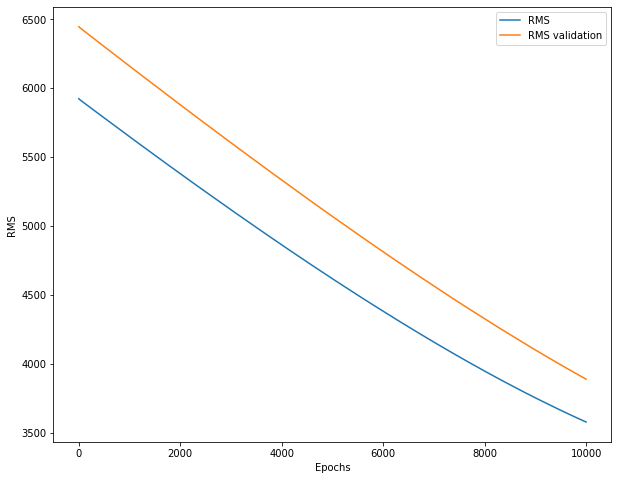

In [21]:
X = circular_database.drop(columns=['8012','8022', 'precipitation', 'avg_temperature', 'delta_temperature'])
y = circular_database[['8012','8022']].sum(axis=1)
#create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

model = Sequential()
hist = History()

# topologia 23-23-10-5-1
model.add(Dense(23, activation='tanh', input_dim = X_train.shape[1], use_bias=True))
model.add(Dense(10, activation='tanh'))
model.add(Dense(5, activation='tanh'))
model.add(Dense(1, activation='linear'))

adam = optimizers.Adam(lr=0.001)
model.compile(optimizer=adam,
              loss='mse', 
              metrics=['mse', 'mape'])

model.fit(X_train, y_train, epochs = 10000, validation_split = .1, callbacks = [hist])

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print('\ntrain RMS:\t%.2f' % np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('test RMS:\t%.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))
print('test R2:\t%.2f\n' % r2_score(y_test, y_pred))

plt.figure(figsize=(10,8))
ax0 = plt.subplot(111)
ax0.plot(np.sqrt(hist.history['mean_squared_error']))
ax0.plot(np.sqrt(hist.history['val_mean_squared_error']))
plt.xlabel('Epochs')
plt.ylabel('RMS')
plt.legend(['RMS', 'RMS validation'])
"""ax1 = ax0.twinx()
ax1.plot(hist.history['mean_absolute_percentage_error'], '--C2')
ax1.plot(hist.history['val_mean_absolute_percentage_error'], '--C3')
plt.ylabel('MAPE')
plt.legend(['MAPE', 'MAPE validation'])"""

## Outras topologias de rede neural

In [6]:
X = circular_database.drop(columns=['8012','8022', 'precipitation', 'avg_temperature', 'delta_temperature'])
y = circular_database[['8012','8022']].sum(axis=1)
#create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

if not os.path.exists('./model_scores/no_climate'):
    os.makedirs('./model_scores/no_climate')
if not os.path.exists('./model_scores/no_climate/images'):
    os.makedirs('./model_scores/no_climate/images')

for i in range(12, 17):
    for j in range(3, 11):
            
        start = time.time()
        model = Sequential()
        hist = History()
        model.add(Dense(i, activation='relu', input_dim = X_train.shape[1]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(j, activation='relu'))
        model.add(Dense(1, activation='linear'))
        
        filename = str(i) + '-' + str(10) + '-' + str(j)
        
        with open('./model_scores/no_climate/{filename}'.format(filename=filename) + '.txt','w') as fh:
            model.summary(print_fn = lambda x: fh.write(x + '\n'))
        
        model.compile(optimizer=optimizers.Adam(lr=0.001),loss='mse', metrics=['mse', 'mape'])
        
        print('Training ' + filename)
        model.fit(X_train, y_train, epochs = 300, validation_split = .1, verbose = 0, callbacks = [hist])
        y_pred = model.predict(X_test)
        train_RMS = np.sqrt(hist.history['mean_squared_error'][-1])
        val_RMS = np.sqrt(hist.history['val_mean_squared_error'][-1])
        test_RMS = np.sqrt(mean_squared_error(y_test, y_pred))
        test_r2 = r2_score(y_test, y_pred)
        
        with open('./model_scores/no_climate/{filename}'.format(filename=filename) + '.txt','a') as fh:
            fh.write('train_rms=' + str(train_RMS) + '\n')
            fh.write('val_rms=' + str(val_RMS) + '\n')
            fh.write('test_rms=' + str(test_RMS) + '\n')
            fh.write('test_r2=' + str(test_r2) + '\n')
          
        with open('./model_scores/no_climate/ranking.txt','a') as fh:
            fh.write(str(i) + ',' + str(j) + ',' + str(test_RMS) + ',' + str(test_r2) + '\n')
        
        plt.figure(figsize=(10,8))
        ax0 = plt.subplot(111)
        ax0.plot(np.sqrt(hist.history['mean_squared_error']))
        ax0.plot(np.sqrt(hist.history['val_mean_squared_error']))
        plt.xlabel('Epochs')
        plt.ylabel('RMS')
        plt.legend(['RMS', 'RMS validation'])
        ax1 = ax0.twinx()
        ax1.plot(hist.history['mean_absolute_percentage_error'], '--C2')
        plt.ylabel('MAPE')
        plt.legend(['MAPE train'])
        plt.savefig('./model_scores/no_climate/images/{filename}'.format(filename=filename) + '.png')
        plt.close()
        
        end = time.time()
        print('\t Time taken (seconds): %.0f' % (end - start))


Training 12-10-3
	 Time taken (seconds): 41
Training 12-10-4


KeyboardInterrupt: 

## Random Forest

RMS train:	1369.15
RMS test:	1863.42
Variance score:	0.62

Features sorted by their score:
[(0.4, 'weekday_6'), (0.3, 'weekday_5'), (0.22, 'week'), (0.03, 'month_7'), (0.01, 'weekday_4'), (0.01, 'weekday_3'), (0.01, 'weekday_2'), (0.01, 'weekday_1'), (0.01, 'weekday_0'), (0.0, 'month_9'), (0.0, 'month_8'), (0.0, 'month_6'), (0.0, 'month_5'), (0.0, 'month_4'), (0.0, 'month_3'), (0.0, 'month_2'), (0.0, 'month_12'), (0.0, 'month_11'), (0.0, 'month_10'), (0.0, 'month_1')]


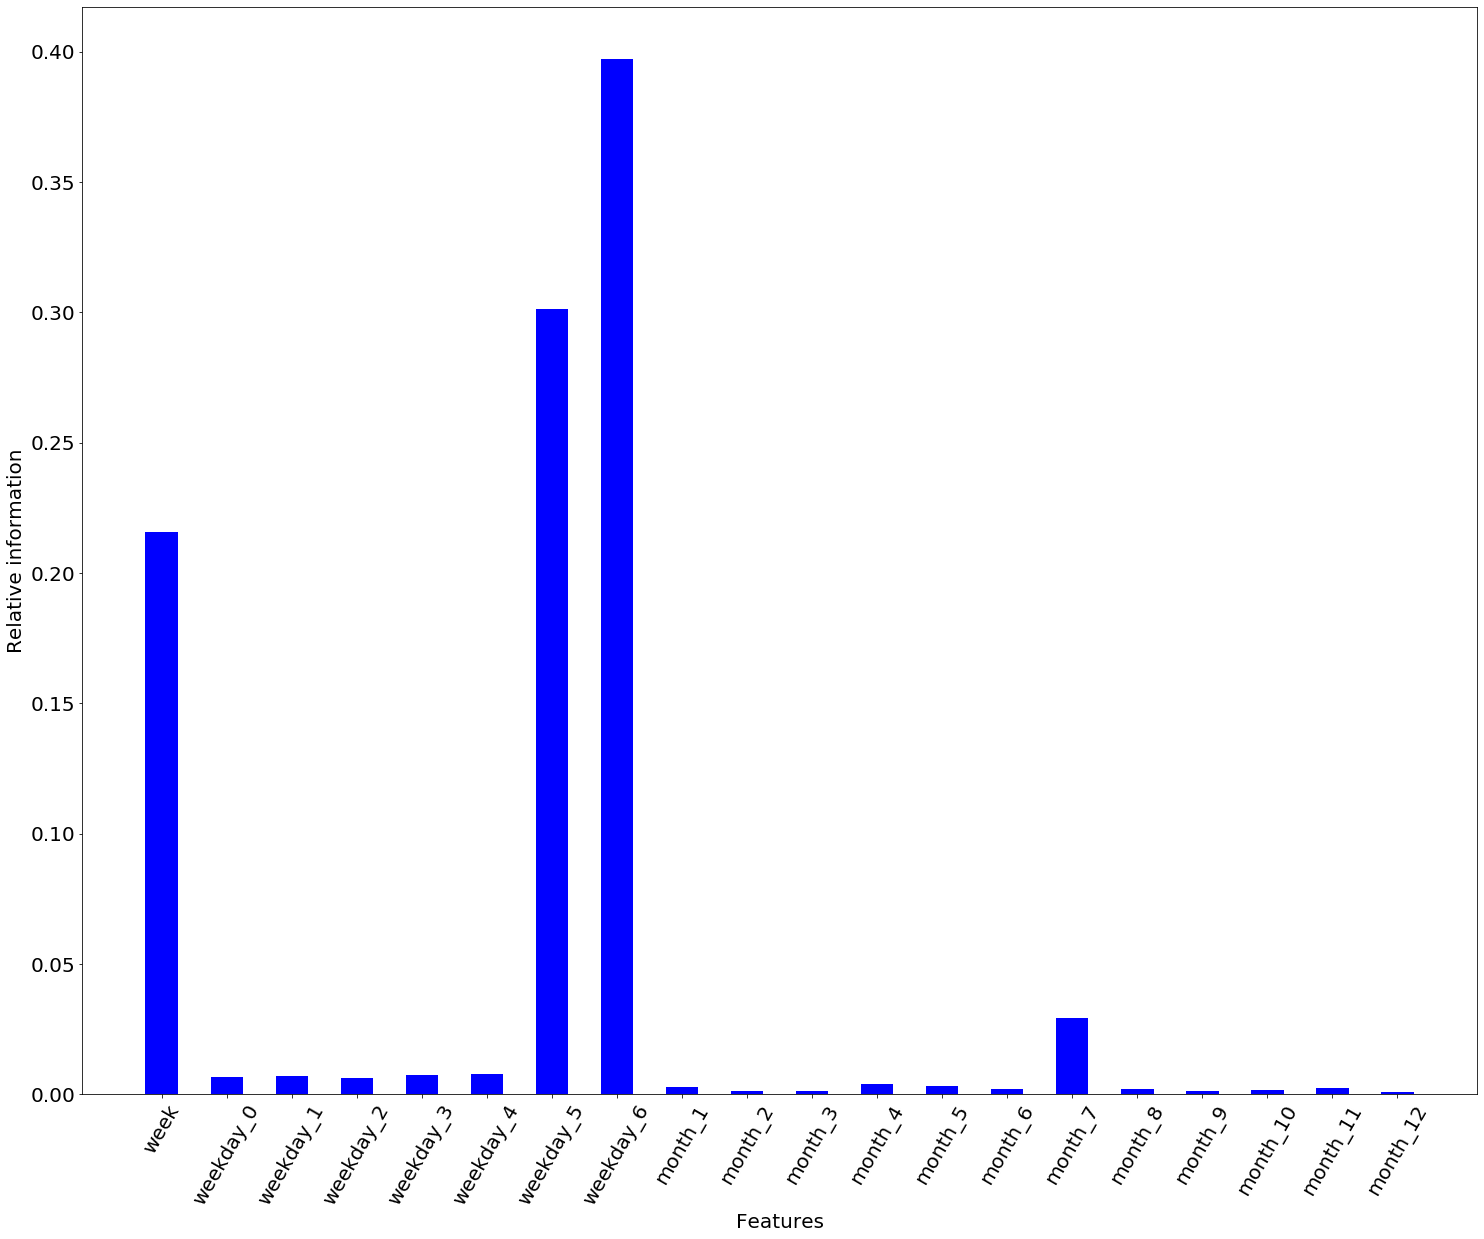

In [9]:
X = circular_database.drop(columns=['8012','8022', 'precipitation', 'avg_temperature', 'delta_temperature'])
y = circular_database[['8012','8022']].sum(axis=1)
#create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

rfr = RandomForestRegressor(n_estimators=1000)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
 
print('RMS train:\t%.2f' % np.sqrt(mean_squared_error(y_train, rfr.predict(X_train))))
print('RMS test:\t%.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))
print('Variance score:\t%.2f' % r2_score(y_test, y_pred))

# Analyze feature importance
features = X.columns
plt_x = np.linspace(0,len(features)-1,len(features))
print("\nFeatures sorted by their score:")
print(sorted(zip(map(lambda x: float("{0:.2f}".format(round(x, 4))), rfr.feature_importances_), features),
             reverse=True))

fig, ax = plt.subplots(figsize=(25,20))
plt.bar(plt_x, rfr.feature_importances_, width=0.5, color='blue',align='center')
plt.gca().set_xticklabels(plt_x, rotation=60 )
plt.xticks(plt_x, features)
plt.ylabel('Relative information')
plt.xlabel('Features')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

# Modelo final escolhido


train RMS:	1692.12
test RMS:	1684.71
test R2:	0.66



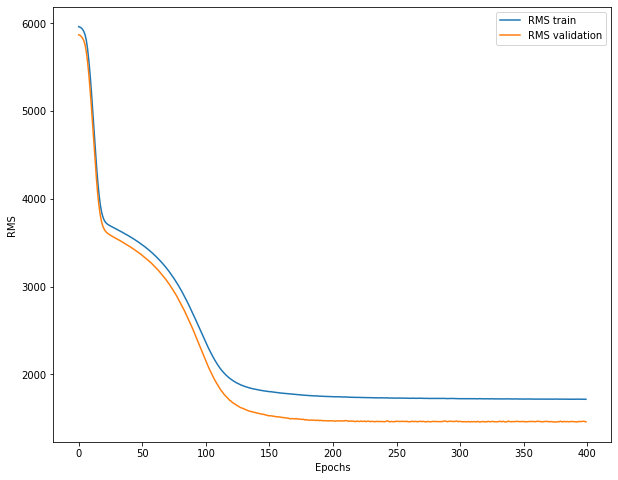

In [10]:
X = circular_database.drop(columns=['8012','8022', 'precipitation', 'avg_temperature', 'delta_temperature'])
y = circular_database[['8012','8022']].sum(axis=1)
#create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

model = Sequential()
hist = History()

# topologia 20-12-8-1
model.add(Dense(12, activation='relu', input_dim = X_train.shape[1]))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

adam = optimizers.Adam(lr=0.001)
model.compile(optimizer=adam,
              loss='mse', 
              metrics=['mse', 'mape'])

model.fit(X_train, y_train, epochs = 400, validation_split = .1, callbacks = [hist], verbose=0)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print('\ntrain RMS:\t%.2f' % np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('test RMS:\t%.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))
print('test R2:\t%.2f\n' % r2_score(y_test, y_pred))

plt.figure(figsize=(10,8))
ax0 = plt.subplot(111)
ax0.plot(np.sqrt(hist.history['mean_squared_error']))
ax0.plot(np.sqrt(hist.history['val_mean_squared_error']))
plt.xlabel('Epochs')
plt.ylabel('RMS')
plt.legend(['RMS train', 'RMS validation'])


Text(0, 0.5, 'RS')

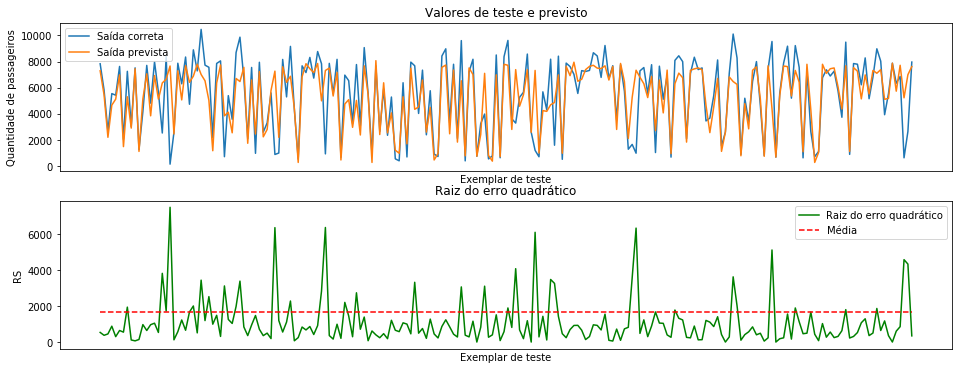

In [11]:
# Plot outputs
df = pd.DataFrame(index=y_test.index, columns=['y_test', 'y_pred'])
df['y_test'] = y_test
df['y_pred'] = y_pred
df.sort_index()

plt.figure(figsize=(16,6))

ax0 = plt.subplot(211)
plt.title('Valores de teste e previsto')
plt.plot(df.index, df['y_test'], df.index, df['y_pred'])
plt.xticks(())
plt.xlabel('Exemplar de teste')
plt.ylabel('Quantidade de passageiros')
plt.legend(['Saída correta', 'Saída prevista'])

plt.subplot(212, sharex=ax0)
plt.title('Raiz do erro quadrático')
plt.plot(df.index,
         np.sqrt(np.square(df['y_test']-df['y_pred'])), '-g',
         df.index,
         np.ones(len(df)) * np.sqrt(mean_squared_error(y_test, y_pred)), '--r')
plt.legend(['Raiz do erro quadrático', 'Média'])
plt.xticks(())
plt.xlabel('Exemplar de teste')
plt.ylabel('RS')